In [1]:
import glob
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model

In [2]:
print(tf.__version__)
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2.3.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1670623787764997425]

In [3]:
# MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# dt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import pydotplus
from sklearn.tree import export_graphviz
from IPython.core.display import Image

import matplotlib.pyplot as plt

# SVM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import PolynomialFeatures

# rf
from sklearn.ensemble import RandomForestClassifier

In [4]:
seed = 0
tf.random.set_seed(seed)

model_metrics = 'acc'    # acc, mse, mae (epoch마다 표시)
num_epochs = 10
num_batch = 100
num_split = 0.2


org_input_num = 12

In [5]:
#txt 파일 불러오기 : fpPrintStat_TT_H.txt ('\t'로 구분된 파일)
V_path= '../feature extract/V/'
V_files = glob.glob(os.path.join(V_path, "*.txt"))
print(V_files)
V_each_file = (pd.read_csv(f, sep='\t', header=None) for f in V_files) 

['../feature extract/V\\NPS_fpPrintStat_TT_V2.txt', '../feature extract/V\\POS_fpPrintStat_TT_V2.txt']


In [6]:
#class별 비율 확인
V_file_list = list(V_each_file)

ratio = 2
sampling_ratio_V = []

for i in V_file_list:
    class0 = len(i[i[org_input_num]==0]) 
    class1 = len(i[i[org_input_num]==1])
    print("class0: ", class0)
    print("class1: ", class1)
    print("class0/class1: ", '%0.2f' %(class0/class1))
    print("sampling ratio: ", '%0.2f' %(ratio*class1/class0), '\n')
    sampling_ratio_V.append(ratio*class1/class0)

class0:  2010718
class1:  187979
class0/class1:  10.70
sampling ratio:  0.19 

class0:  757192
class1:  163316
class0/class1:  4.64
sampling ratio:  0.43 



In [7]:
#subsampling
df = pd.DataFrame()
for data, smp_ratio in  zip(V_file_list, sampling_ratio_V):
    df_class0 = data[data[org_input_num]==0].sample(frac=smp_ratio)
    print("0: ", len(df_class0))
    df_class1 = data[data[org_input_num]==1]
    print("1: ", len(df_class1))
    df = pd.concat([df, df_class0, df_class1], ignore_index = True)
    print("concat: ", len(df), '\n')

0:  375958
1:  187979
concat:  563937 

0:  326632
1:  163316
concat:  1053885 



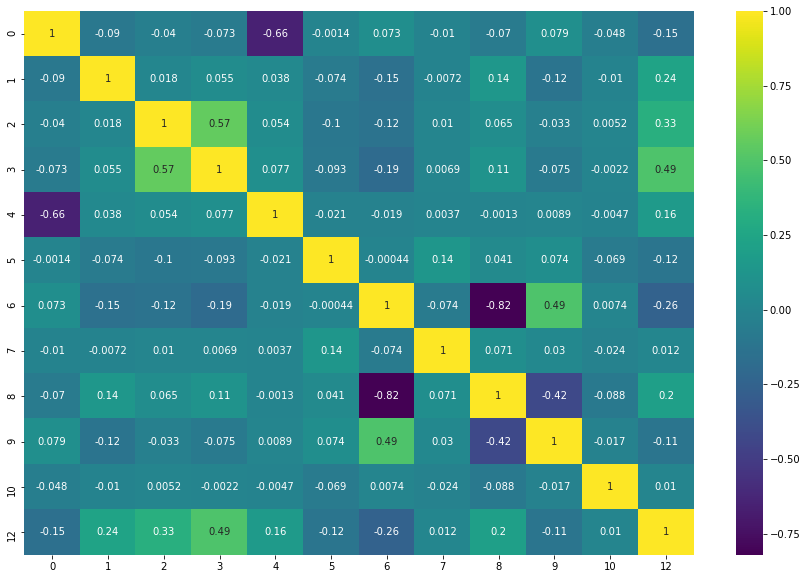

In [8]:
#pcc 분석(11번째 열 제거)
import seaborn as sns
df = df.drop([df.columns[11]], axis = 1)
plt.figure(figsize = (15, 10))
corr = df.corr()
#print(corr)
sns.heatmap(corr, cmap = 'viridis', annot = True)
plt.show()

In [9]:
#train, val data 나누기
df = df.to_numpy()
inp_num = 11

x = df[:, 0:inp_num]
y = df[:, inp_num]

X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=seed)

In [10]:
#test set 경로
test_V_path= '../feature extract/test_V/'
test_V_files = glob.glob(os.path.join(test_V_path, "*.txt"))
print(test_V_files)
test_V_each_file = (pd.read_csv(f, sep='\t', header=None, error_bad_lines=False, warn_bad_lines=False) for f in test_V_files) 

['../feature extract/test_V\\BHJ_fpPrintStat_TT_V2.txt', '../feature extract/test_V\\krs_fpPrintStat_TT_V2.txt']


In [11]:
#class 별 비율 확인
test_V_file_list = list(test_V_each_file)

ratio = 2
test_sampling_ratio_V = []

for i in test_V_file_list:
    class0 = len(i[i[org_input_num]==0]) 
    class1 = len(i[i[org_input_num]==1])
    print("class0: ", class0)
    print("class1: ", class1)
    print("class0/class1: ", '%0.2f' %(class0/class1))
    print("sampling ratio: ", '%0.2f' %(ratio*class1/class0), '\n')
    test_sampling_ratio_V.append(ratio*class1/class0)

class0:  600952
class1:  57309
class0/class1:  10.49
sampling ratio:  0.19 

class0:  871840
class1:  126033
class0/class1:  6.92
sampling ratio:  0.29 



In [12]:
#4가지 test set 만들기
test_df_0 = pd.DataFrame() # 1) class0만 있는 test set
test_df_1 = pd.DataFrame() # 2) class1만 있는 test set
test_df_sub = pd.DataFrame()# 3)class0, class1 각각 2:1로 구성된 test set
test_df = pd.DataFrame() # subsampling x test set

for data, smp_ratio in  zip(test_V_file_list, test_sampling_ratio_V):
    df_class0_sub = data[data[org_input_num]==0].sample(frac=smp_ratio)
    print("sub 0: ", len(df_class0_sub))
    df_class0 = data[data[org_input_num]==0]
    print("org 0: ", len(df_class0))
    #class0만 있는 test set
    test_df_0 = pd.concat([test_df_0, df_class0], ignore_index = True)
    print("only 0 concat: ", len(test_df_0), '\n')
                           
    df_class1 = data[data[org_input_num]==1]
    print("1: ", len(df_class1))
    #class1만 있는 test set
    test_df_1 = pd.concat([test_df_1, df_class1], ignore_index = True)
    print("only 1 concat: ", len(test_df_1), '\n')
          
    #class0, class1 각각 2:1로 구성된 test set
    test_df_sub = pd.concat([test_df_sub,df_class0_sub, df_class1], ignore_index = True)
    print("sub concat: ", len(test_df_sub), '\n')
          
    # subsampling x test set
    test_df = pd.concat([test_df,df_class0, df_class1], ignore_index = True)
    print("org concat: ", len(test_df), '\n')

sub 0:  114618
org 0:  600952
only 0 concat:  600952 

1:  57309
only 1 concat:  57309 

sub concat:  171927 

org concat:  658261 

sub 0:  252066
org 0:  871840
only 0 concat:  1472792 

1:  126033
only 1 concat:  183342 

sub concat:  550026 

org concat:  1656134 



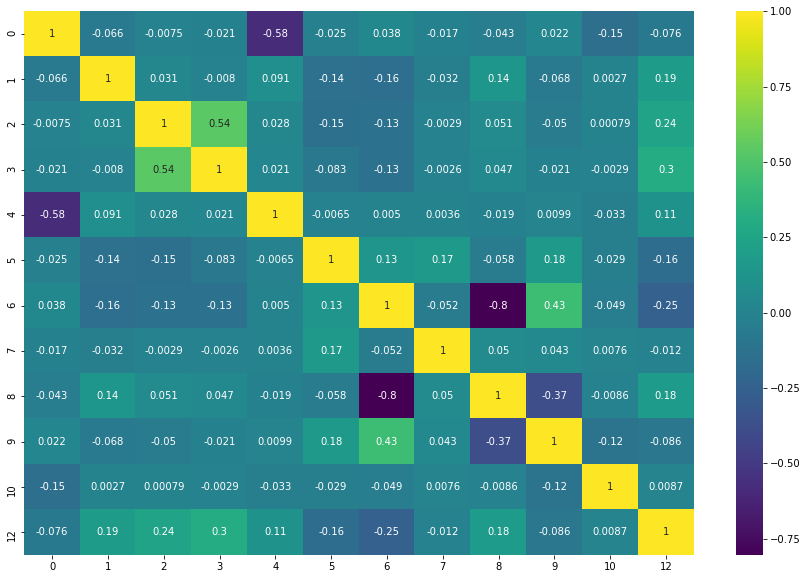

In [13]:
#pcc 분석(11번째 열 제거)
import seaborn as sns
test_df = test_df.drop([test_df.columns[11]], axis = 1)
test_df_0 = test_df_0.drop([test_df_0.columns[11]], axis = 1)
test_df_1 = test_df_1.drop([test_df_1.columns[11]], axis = 1)
test_df_sub = test_df_sub.drop([test_df_sub.columns[11]], axis = 1)
plt.figure(figsize = (15, 10))
corr = test_df.corr()
#print(corr)
sns.heatmap(corr, cmap = 'viridis', annot = True)
plt.show()

In [14]:
test_df_0 = test_df_0.to_numpy()
test_df_1 = test_df_1.to_numpy()
test_df_sub = test_df_sub.to_numpy()
test_df = test_df.to_numpy()    

In [15]:
#4개의 test set
inp_num=11
#only class0
x_class0 = test_df_0[:, 0:inp_num]
y_class0 = test_df_0[:, inp_num]

#only class1
x_class1 = test_df_1[:, 0:inp_num]
x_class1 = test_df_1[:, inp_num]

#subsampling
x_sub = test_df_sub[:, 0:inp_num]
y_sub = test_df_sub[:, inp_num]

#original
x = test_df[:, 0:inp_num]
y = test_df[:, inp_num]

In [22]:
# MLP: 12x30x1 - 100 epochs
num_epochs = 100

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])
history = []
history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_100.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/100
8432/8432 [==============================] - 4s 434us/step - loss: 0.2094 - acc: 0.6669 - val_loss: 0.1901 - val_acc: 0.6920
Epoch 2/100
8432/8432 [==============================] - 4s 425us/step - loss: 0.1776 - acc: 0.7258 - val_loss: 0.1693 - val_acc: 0.7406
Epoch 3/100
8432/8432 [==============================] - 4s 418us/step - loss: 0.1651 - acc: 0.7557 - val_loss: 0.1620 - val_acc: 0.7613
Epoch 4/100
8432/8432 [==============================] - 3s 409us/step - loss: 0.1600 - acc: 0.7625 - val_loss: 0.1583 - val_acc: 0.7641
Epoch 5/100
8432/8432 [==============================] - 4s 445us/step - loss: 0.1569 - acc: 0.7648 - val_loss: 0.1557 - val_acc: 0.7667
Epoch 6/100
8432/8432 [==============================] - 4s 444us/step - loss: 0.1547 - acc: 0.7680 - val_loss: 0.1536 - val_acc: 0.7692
Epoch 7/100
8432/8432 [==============================] - 4s 423us/step - loss: 0.1529 - acc: 0.7700 - val_loss: 0.1521 - val_acc: 0.7709
Epoch 8/100
8432/8432 [==================

In [23]:
# MLP: 12x30x1 - 200 epochs
num_epochs = 200

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_200.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/200
8432/8432 [==============================] - 4s 444us/step - loss: 0.2049 - acc: 0.6722 - val_loss: 0.1887 - val_acc: 0.7039
Epoch 2/200
8432/8432 [==============================] - 4s 452us/step - loss: 0.1780 - acc: 0.7285 - val_loss: 0.1705 - val_acc: 0.7422
Epoch 3/200
8432/8432 [==============================] - 4s 431us/step - loss: 0.1665 - acc: 0.7496 - val_loss: 0.1635 - val_acc: 0.7608
Epoch 4/200
8432/8432 [==============================] - 4s 461us/step - loss: 0.1614 - acc: 0.7619 - val_loss: 0.1596 - val_acc: 0.7636
Epoch 5/200
8432/8432 [==============================] - 4s 443us/step - loss: 0.1582 - acc: 0.7643 - val_loss: 0.1568 - val_acc: 0.7652
Epoch 6/200
8432/8432 [==============================] - 4s 439us/step - loss: 0.1558 - acc: 0.7666 - val_loss: 0.1547 - val_acc: 0.7680
Epoch 7/200
8432/8432 [==============================] - 4s 486us/step - loss: 0.1539 - acc: 0.7687 - val_loss: 0.1529 - val_acc: 0.7699
Epoch 8/200
8432/8432 [==================

8432/8432 [==============================] - 4s 431us/step - loss: 0.1463 - acc: 0.7769 - val_loss: 0.1461 - val_acc: 0.7771
Epoch 120/200
8432/8432 [==============================] - 4s 430us/step - loss: 0.1463 - acc: 0.7769 - val_loss: 0.1461 - val_acc: 0.7771
Epoch 121/200
8432/8432 [==============================] - 4s 430us/step - loss: 0.1463 - acc: 0.7770 - val_loss: 0.1460 - val_acc: 0.7770
Epoch 122/200
8432/8432 [==============================] - 4s 427us/step - loss: 0.1463 - acc: 0.7771 - val_loss: 0.1460 - val_acc: 0.7772
Epoch 123/200
8432/8432 [==============================] - 3s 415us/step - loss: 0.1463 - acc: 0.7772 - val_loss: 0.1461 - val_acc: 0.7782
Epoch 124/200
8432/8432 [==============================] - 4s 418us/step - loss: 0.1463 - acc: 0.7771 - val_loss: 0.1460 - val_acc: 0.7771
Epoch 125/200
8432/8432 [==============================] - 4s 429us/step - loss: 0.1463 - acc: 0.7771 - val_loss: 0.1460 - val_acc: 0.7770
Epoch 126/200
8432/8432 [================

8432/8432 [==============================] - 4s 431us/step - loss: 0.1456 - acc: 0.7793 - val_loss: 0.1454 - val_acc: 0.7799
Epoch 179/200
8432/8432 [==============================] - 4s 433us/step - loss: 0.1456 - acc: 0.7795 - val_loss: 0.1453 - val_acc: 0.7798
Epoch 180/200
8432/8432 [==============================] - 4s 455us/step - loss: 0.1456 - acc: 0.7794 - val_loss: 0.1453 - val_acc: 0.7791
Epoch 181/200
8432/8432 [==============================] - 3s 410us/step - loss: 0.1456 - acc: 0.7795 - val_loss: 0.1453 - val_acc: 0.7796
Epoch 182/200
8432/8432 [==============================] - 4s 455us/step - loss: 0.1456 - acc: 0.7794 - val_loss: 0.1453 - val_acc: 0.7800
Epoch 183/200
8432/8432 [==============================] - 4s 438us/step - loss: 0.1455 - acc: 0.7796 - val_loss: 0.1453 - val_acc: 0.7796
Epoch 184/200
8432/8432 [==============================] - 4s 467us/step - loss: 0.1455 - acc: 0.7795 - val_loss: 0.1453 - val_acc: 0.7799
Epoch 185/200
8432/8432 [================

In [24]:
# MLP: 12x30x30x1 - 100 epochs
num_epochs = 100

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='sigmoid'))
model.add(Dense(30, input_dim=inp_num, activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_30x30_100.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/100
8432/8432 [==============================] - 4s 527us/step - loss: 0.2196 - acc: 0.6667 - val_loss: 0.2169 - val_acc: 0.6667
Epoch 2/100
8432/8432 [==============================] - 4s 490us/step - loss: 0.2118 - acc: 0.6667 - val_loss: 0.2046 - val_acc: 0.6667
Epoch 3/100
8432/8432 [==============================] - 4s 476us/step - loss: 0.1923 - acc: 0.6884 - val_loss: 0.1792 - val_acc: 0.7185
Epoch 4/100
8432/8432 [==============================] - 4s 459us/step - loss: 0.1705 - acc: 0.7398 - val_loss: 0.1647 - val_acc: 0.7592
Epoch 5/100
8432/8432 [==============================] - 4s 468us/step - loss: 0.1618 - acc: 0.7608 - val_loss: 0.1595 - val_acc: 0.7624
Epoch 6/100
8432/8432 [==============================] - 4s 470us/step - loss: 0.1580 - acc: 0.7637 - val_loss: 0.1565 - val_acc: 0.7649
Epoch 7/100
8432/8432 [==============================] - 4s 469us/step - loss: 0.1553 - acc: 0.7671 - val_loss: 0.1541 - val_acc: 0.7688
Epoch 8/100
8432/8432 [==================

In [25]:
# MLP: 12x120x1 - 100 epochs
num_epochs = 100

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(120, input_dim=inp_num, activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_120_100.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/100
8432/8432 [==============================] - 4s 462us/step - loss: 0.2034 - acc: 0.6737 - val_loss: 0.1851 - val_acc: 0.6998
Epoch 2/100
8432/8432 [==============================] - 4s 436us/step - loss: 0.1742 - acc: 0.7330 - val_loss: 0.1671 - val_acc: 0.7558
Epoch 3/100
8432/8432 [==============================] - 4s 431us/step - loss: 0.1636 - acc: 0.7586 - val_loss: 0.1609 - val_acc: 0.7609
Epoch 4/100
8432/8432 [==============================] - 4s 465us/step - loss: 0.1591 - acc: 0.7629 - val_loss: 0.1574 - val_acc: 0.7645
Epoch 5/100
8432/8432 [==============================] - 4s 473us/step - loss: 0.1562 - acc: 0.7659 - val_loss: 0.1549 - val_acc: 0.7685
Epoch 6/100
8432/8432 [==============================] - 4s 462us/step - loss: 0.1540 - acc: 0.7687 - val_loss: 0.1530 - val_acc: 0.7691
Epoch 7/100
8432/8432 [==============================] - 4s 459us/step - loss: 0.1524 - acc: 0.7694 - val_loss: 0.1515 - val_acc: 0.7702
Epoch 8/100
8432/8432 [==================

In [26]:
# MLP: 12x30x1 - 1000 epochs
num_epochs = 1000

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_1000.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/1000
8432/8432 [==============================] - 4s 434us/step - loss: 0.2046 - acc: 0.6710 - val_loss: 0.1885 - val_acc: 0.7040
Epoch 2/1000
8432/8432 [==============================] - 4s 422us/step - loss: 0.1774 - acc: 0.7248 - val_loss: 0.1698 - val_acc: 0.7387
Epoch 3/1000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1659 - acc: 0.7546 - val_loss: 0.1630 - val_acc: 0.7593
Epoch 4/1000
8432/8432 [==============================] - 4s 422us/step - loss: 0.1610 - acc: 0.7605 - val_loss: 0.1593 - val_acc: 0.7620
Epoch 5/1000
8432/8432 [==============================] - 4s 416us/step - loss: 0.1579 - acc: 0.7637 - val_loss: 0.1566 - val_acc: 0.7654
Epoch 6/1000
8432/8432 [==============================] - 4s 419us/step - loss: 0.1555 - acc: 0.7670 - val_loss: 0.1544 - val_acc: 0.7683
Epoch 7/1000
8432/8432 [==============================] - 4s 421us/step - loss: 0.1536 - acc: 0.7689 - val_loss: 0.1527 - val_acc: 0.7693
Epoch 8/1000
8432/8432 [==========

8432/8432 [==============================] - 4s 432us/step - loss: 0.1470 - acc: 0.7767 - val_loss: 0.1467 - val_acc: 0.7767
Epoch 61/1000
8432/8432 [==============================] - 4s 433us/step - loss: 0.1470 - acc: 0.7767 - val_loss: 0.1467 - val_acc: 0.7761
Epoch 62/1000
8432/8432 [==============================] - 4s 434us/step - loss: 0.1469 - acc: 0.7766 - val_loss: 0.1467 - val_acc: 0.7767
Epoch 63/1000
8432/8432 [==============================] - 4s 422us/step - loss: 0.1469 - acc: 0.7767 - val_loss: 0.1467 - val_acc: 0.7768
Epoch 64/1000
8432/8432 [==============================] - 4s 454us/step - loss: 0.1469 - acc: 0.7767 - val_loss: 0.1466 - val_acc: 0.7767
Epoch 65/1000
8432/8432 [==============================] - 4s 445us/step - loss: 0.1469 - acc: 0.7767 - val_loss: 0.1466 - val_acc: 0.7767
Epoch 66/1000
8432/8432 [==============================] - 4s 443us/step - loss: 0.1469 - acc: 0.7767 - val_loss: 0.1466 - val_acc: 0.7767
Epoch 67/1000
8432/8432 [================

Epoch 119/1000
8432/8432 [==============================] - 4s 425us/step - loss: 0.1462 - acc: 0.7781 - val_loss: 0.1459 - val_acc: 0.7782
Epoch 120/1000
8432/8432 [==============================] - 4s 426us/step - loss: 0.1462 - acc: 0.7781 - val_loss: 0.1459 - val_acc: 0.7783
Epoch 121/1000
8432/8432 [==============================] - 4s 418us/step - loss: 0.1462 - acc: 0.7782 - val_loss: 0.1459 - val_acc: 0.7782
Epoch 122/1000
8432/8432 [==============================] - 4s 420us/step - loss: 0.1462 - acc: 0.7782 - val_loss: 0.1459 - val_acc: 0.7783
Epoch 123/1000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1462 - acc: 0.7784 - val_loss: 0.1460 - val_acc: 0.7793
Epoch 124/1000
8432/8432 [==============================] - 4s 426us/step - loss: 0.1461 - acc: 0.7782 - val_loss: 0.1459 - val_acc: 0.7782
Epoch 125/1000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1461 - acc: 0.7782 - val_loss: 0.1459 - val_acc: 0.7782
Epoch 126/1000
8432/

8432/8432 [==============================] - 4s 426us/step - loss: 0.1449 - acc: 0.7801 - val_loss: 0.1447 - val_acc: 0.7803
Epoch 236/1000
8432/8432 [==============================] - 4s 433us/step - loss: 0.1449 - acc: 0.7802 - val_loss: 0.1447 - val_acc: 0.7806
Epoch 237/1000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1449 - acc: 0.7801 - val_loss: 0.1447 - val_acc: 0.7806
Epoch 238/1000
8432/8432 [==============================] - 4s 416us/step - loss: 0.1449 - acc: 0.7802 - val_loss: 0.1446 - val_acc: 0.7803
Epoch 239/1000
8432/8432 [==============================] - 4s 422us/step - loss: 0.1449 - acc: 0.7801 - val_loss: 0.1447 - val_acc: 0.7806
Epoch 240/1000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1449 - acc: 0.7803 - val_loss: 0.1446 - val_acc: 0.7804
Epoch 241/1000
8432/8432 [==============================] - 4s 430us/step - loss: 0.1449 - acc: 0.7801 - val_loss: 0.1446 - val_acc: 0.7800
Epoch 242/1000
8432/8432 [=========

8432/8432 [==============================] - 4s 425us/step - loss: 0.1442 - acc: 0.7806 - val_loss: 0.1439 - val_acc: 0.7812
Epoch 352/1000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1442 - acc: 0.7806 - val_loss: 0.1439 - val_acc: 0.7809
Epoch 353/1000
8432/8432 [==============================] - 4s 417us/step - loss: 0.1442 - acc: 0.7807 - val_loss: 0.1439 - val_acc: 0.7807
Epoch 354/1000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1442 - acc: 0.7806 - val_loss: 0.1439 - val_acc: 0.7810
Epoch 355/1000
8432/8432 [==============================] - 4s 419us/step - loss: 0.1442 - acc: 0.7806 - val_loss: 0.1440 - val_acc: 0.7804
Epoch 356/1000
8432/8432 [==============================] - 4s 422us/step - loss: 0.1442 - acc: 0.7807 - val_loss: 0.1439 - val_acc: 0.7810
Epoch 357/1000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1442 - acc: 0.7806 - val_loss: 0.1439 - val_acc: 0.7811
Epoch 358/1000
8432/8432 [=========

8432/8432 [==============================] - 4s 421us/step - loss: 0.1438 - acc: 0.7808 - val_loss: 0.1435 - val_acc: 0.7811
Epoch 468/1000
8432/8432 [==============================] - 4s 437us/step - loss: 0.1438 - acc: 0.7809 - val_loss: 0.1435 - val_acc: 0.7812
Epoch 469/1000
8432/8432 [==============================] - 4s 432us/step - loss: 0.1438 - acc: 0.7809 - val_loss: 0.1435 - val_acc: 0.7812
Epoch 470/1000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1438 - acc: 0.7808 - val_loss: 0.1435 - val_acc: 0.7811
Epoch 471/1000
8432/8432 [==============================] - 3s 411us/step - loss: 0.1438 - acc: 0.7808 - val_loss: 0.1435 - val_acc: 0.7812
Epoch 472/1000
8432/8432 [==============================] - 4s 423us/step - loss: 0.1438 - acc: 0.7808 - val_loss: 0.1435 - val_acc: 0.7812
Epoch 473/1000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1438 - acc: 0.7809 - val_loss: 0.1435 - val_acc: 0.7812
Epoch 474/1000
8432/8432 [=========

8432/8432 [==============================] - 4s 446us/step - loss: 0.1435 - acc: 0.7811 - val_loss: 0.1432 - val_acc: 0.7815
Epoch 584/1000
8432/8432 [==============================] - 4s 459us/step - loss: 0.1435 - acc: 0.7810 - val_loss: 0.1432 - val_acc: 0.7815
Epoch 585/1000
8432/8432 [==============================] - 4s 488us/step - loss: 0.1435 - acc: 0.7810 - val_loss: 0.1432 - val_acc: 0.7815
Epoch 586/1000
8432/8432 [==============================] - 4s 440us/step - loss: 0.1435 - acc: 0.7811 - val_loss: 0.1432 - val_acc: 0.7816
Epoch 587/1000
8432/8432 [==============================] - 4s 436us/step - loss: 0.1435 - acc: 0.7811 - val_loss: 0.1432 - val_acc: 0.7816
Epoch 588/1000
8432/8432 [==============================] - 4s 430us/step - loss: 0.1435 - acc: 0.7811 - val_loss: 0.1432 - val_acc: 0.7814
Epoch 589/1000
8432/8432 [==============================] - 4s 430us/step - loss: 0.1435 - acc: 0.7810 - val_loss: 0.1432 - val_acc: 0.7815
Epoch 590/1000
8432/8432 [=========

8432/8432 [==============================] - 4s 427us/step - loss: 0.1432 - acc: 0.7814 - val_loss: 0.1430 - val_acc: 0.7819
Epoch 700/1000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1432 - acc: 0.7814 - val_loss: 0.1430 - val_acc: 0.7819
Epoch 701/1000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1432 - acc: 0.7814 - val_loss: 0.1430 - val_acc: 0.7819
Epoch 702/1000
8432/8432 [==============================] - 4s 434us/step - loss: 0.1432 - acc: 0.7814 - val_loss: 0.1430 - val_acc: 0.7819
Epoch 703/1000
8432/8432 [==============================] - 4s 421us/step - loss: 0.1432 - acc: 0.7814 - val_loss: 0.1429 - val_acc: 0.7819
Epoch 704/1000
8432/8432 [==============================] - 4s 433us/step - loss: 0.1432 - acc: 0.7815 - val_loss: 0.1429 - val_acc: 0.7819
Epoch 705/1000
8432/8432 [==============================] - 4s 435us/step - loss: 0.1432 - acc: 0.7814 - val_loss: 0.1429 - val_acc: 0.7819
Epoch 706/1000
8432/8432 [=========

8432/8432 [==============================] - 3s 411us/step - loss: 0.1431 - acc: 0.7817 - val_loss: 0.1428 - val_acc: 0.7818
Epoch 816/1000
8432/8432 [==============================] - 4s 421us/step - loss: 0.1431 - acc: 0.7817 - val_loss: 0.1428 - val_acc: 0.7818
Epoch 817/1000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1431 - acc: 0.7816 - val_loss: 0.1428 - val_acc: 0.7819
Epoch 818/1000
8432/8432 [==============================] - 4s 422us/step - loss: 0.1430 - acc: 0.7816 - val_loss: 0.1428 - val_acc: 0.7819
Epoch 819/1000
8432/8432 [==============================] - 4s 422us/step - loss: 0.1430 - acc: 0.7816 - val_loss: 0.1428 - val_acc: 0.7822
Epoch 820/1000
8432/8432 [==============================] - 3s 414us/step - loss: 0.1430 - acc: 0.7817 - val_loss: 0.1428 - val_acc: 0.7821
Epoch 821/1000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1430 - acc: 0.7817 - val_loss: 0.1428 - val_acc: 0.7819
Epoch 822/1000
8432/8432 [=========

8432/8432 [==============================] - 4s 428us/step - loss: 0.1429 - acc: 0.7818 - val_loss: 0.1427 - val_acc: 0.7823
Epoch 932/1000
8432/8432 [==============================] - 3s 413us/step - loss: 0.1429 - acc: 0.7818 - val_loss: 0.1426 - val_acc: 0.7822
Epoch 933/1000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1429 - acc: 0.7818 - val_loss: 0.1426 - val_acc: 0.7820
Epoch 934/1000
8432/8432 [==============================] - 4s 423us/step - loss: 0.1429 - acc: 0.7818 - val_loss: 0.1426 - val_acc: 0.7820
Epoch 935/1000
8432/8432 [==============================] - 4s 425us/step - loss: 0.1429 - acc: 0.7818 - val_loss: 0.1426 - val_acc: 0.7821
Epoch 936/1000
8432/8432 [==============================] - 4s 430us/step - loss: 0.1429 - acc: 0.7818 - val_loss: 0.1426 - val_acc: 0.7821
Epoch 937/1000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1429 - acc: 0.7818 - val_loss: 0.1426 - val_acc: 0.7819
Epoch 938/1000
8432/8432 [=========

In [27]:
# MLP: 12x30x1 - 2000 epochs
num_epochs = 2000

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_2000.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/2000
8432/8432 [==============================] - 4s 441us/step - loss: 0.2072 - acc: 0.6657 - val_loss: 0.1885 - val_acc: 0.6898
Epoch 2/2000
8432/8432 [==============================] - 4s 428us/step - loss: 0.1757 - acc: 0.7277 - val_loss: 0.1671 - val_acc: 0.7473
Epoch 3/2000
8432/8432 [==============================] - 3s 414us/step - loss: 0.1632 - acc: 0.7588 - val_loss: 0.1604 - val_acc: 0.7632
Epoch 4/2000
8432/8432 [==============================] - 4s 420us/step - loss: 0.1586 - acc: 0.7644 - val_loss: 0.1570 - val_acc: 0.7658
Epoch 5/2000
8432/8432 [==============================] - 4s 434us/step - loss: 0.1559 - acc: 0.7669 - val_loss: 0.1547 - val_acc: 0.7691
Epoch 6/2000
8432/8432 [==============================] - 4s 434us/step - loss: 0.1538 - acc: 0.7692 - val_loss: 0.1529 - val_acc: 0.7698
Epoch 7/2000
8432/8432 [==============================] - 4s 434us/step - loss: 0.1523 - acc: 0.7703 - val_loss: 0.1515 - val_acc: 0.7708
Epoch 8/2000
8432/8432 [==========

8432/8432 [==============================] - 4s 423us/step - loss: 0.1471 - acc: 0.7764 - val_loss: 0.1468 - val_acc: 0.7767
Epoch 61/2000
8432/8432 [==============================] - 3s 411us/step - loss: 0.1471 - acc: 0.7764 - val_loss: 0.1469 - val_acc: 0.7757
Epoch 62/2000
8432/8432 [==============================] - 4s 420us/step - loss: 0.1471 - acc: 0.7765 - val_loss: 0.1468 - val_acc: 0.7766
Epoch 63/2000
8432/8432 [==============================] - 4s 430us/step - loss: 0.1470 - acc: 0.7765 - val_loss: 0.1468 - val_acc: 0.7765
Epoch 64/2000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1470 - acc: 0.7765 - val_loss: 0.1468 - val_acc: 0.7766
Epoch 65/2000
8432/8432 [==============================] - 4s 433us/step - loss: 0.1470 - acc: 0.7765 - val_loss: 0.1468 - val_acc: 0.7767
Epoch 66/2000
8432/8432 [==============================] - 4s 420us/step - loss: 0.1470 - acc: 0.7766 - val_loss: 0.1467 - val_acc: 0.7765
Epoch 67/2000
8432/8432 [================

Epoch 119/2000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1463 - acc: 0.7775 - val_loss: 0.1460 - val_acc: 0.7776
Epoch 120/2000
8432/8432 [==============================] - 3s 413us/step - loss: 0.1463 - acc: 0.7774 - val_loss: 0.1460 - val_acc: 0.7776
Epoch 121/2000
8432/8432 [==============================] - 4s 432us/step - loss: 0.1463 - acc: 0.7775 - val_loss: 0.1460 - val_acc: 0.7779
Epoch 122/2000
8432/8432 [==============================] - 4s 432us/step - loss: 0.1463 - acc: 0.7777 - val_loss: 0.1460 - val_acc: 0.7778
Epoch 123/2000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1463 - acc: 0.7777 - val_loss: 0.1461 - val_acc: 0.7786
Epoch 124/2000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1463 - acc: 0.7777 - val_loss: 0.1460 - val_acc: 0.7773
Epoch 125/2000
8432/8432 [==============================] - 3s 413us/step - loss: 0.1462 - acc: 0.7777 - val_loss: 0.1460 - val_acc: 0.7773
Epoch 126/2000
8432/

8432/8432 [==============================] - 4s 415us/step - loss: 0.1452 - acc: 0.7799 - val_loss: 0.1450 - val_acc: 0.7800
Epoch 236/2000
8432/8432 [==============================] - 3s 411us/step - loss: 0.1452 - acc: 0.7800 - val_loss: 0.1450 - val_acc: 0.7802
Epoch 237/2000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1452 - acc: 0.7800 - val_loss: 0.1450 - val_acc: 0.7802
Epoch 238/2000
8432/8432 [==============================] - 4s 429us/step - loss: 0.1452 - acc: 0.7800 - val_loss: 0.1449 - val_acc: 0.7799
Epoch 239/2000
8432/8432 [==============================] - 4s 429us/step - loss: 0.1452 - acc: 0.7800 - val_loss: 0.1450 - val_acc: 0.7802
Epoch 240/2000
8432/8432 [==============================] - 4s 429us/step - loss: 0.1452 - acc: 0.7799 - val_loss: 0.1449 - val_acc: 0.7800
Epoch 241/2000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1452 - acc: 0.7800 - val_loss: 0.1449 - val_acc: 0.7792
Epoch 242/2000
8432/8432 [=========

8432/8432 [==============================] - 4s 426us/step - loss: 0.1443 - acc: 0.7802 - val_loss: 0.1441 - val_acc: 0.7813
Epoch 352/2000
8432/8432 [==============================] - 3s 411us/step - loss: 0.1443 - acc: 0.7804 - val_loss: 0.1441 - val_acc: 0.7811
Epoch 353/2000
8432/8432 [==============================] - 3s 415us/step - loss: 0.1443 - acc: 0.7805 - val_loss: 0.1441 - val_acc: 0.7804
Epoch 354/2000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1443 - acc: 0.7804 - val_loss: 0.1441 - val_acc: 0.7808
Epoch 355/2000
8432/8432 [==============================] - 4s 432us/step - loss: 0.1443 - acc: 0.7804 - val_loss: 0.1441 - val_acc: 0.7797
Epoch 356/2000
8432/8432 [==============================] - 4s 435us/step - loss: 0.1443 - acc: 0.7804 - val_loss: 0.1441 - val_acc: 0.7813
Epoch 357/2000
8432/8432 [==============================] - 4s 423us/step - loss: 0.1443 - acc: 0.7804 - val_loss: 0.1441 - val_acc: 0.7808
Epoch 358/2000
8432/8432 [=========

8432/8432 [==============================] - 4s 434us/step - loss: 0.1439 - acc: 0.7811 - val_loss: 0.1436 - val_acc: 0.7812
Epoch 468/2000
8432/8432 [==============================] - 3s 414us/step - loss: 0.1439 - acc: 0.7811 - val_loss: 0.1436 - val_acc: 0.7811
Epoch 469/2000
8432/8432 [==============================] - 3s 411us/step - loss: 0.1439 - acc: 0.7811 - val_loss: 0.1436 - val_acc: 0.7813
Epoch 470/2000
8432/8432 [==============================] - 4s 428us/step - loss: 0.1439 - acc: 0.7811 - val_loss: 0.1436 - val_acc: 0.7813
Epoch 471/2000
8432/8432 [==============================] - 4s 430us/step - loss: 0.1439 - acc: 0.7811 - val_loss: 0.1436 - val_acc: 0.7812
Epoch 472/2000
8432/8432 [==============================] - 4s 434us/step - loss: 0.1438 - acc: 0.7811 - val_loss: 0.1436 - val_acc: 0.7812
Epoch 473/2000
8432/8432 [==============================] - 4s 433us/step - loss: 0.1438 - acc: 0.7811 - val_loss: 0.1436 - val_acc: 0.7812
Epoch 474/2000
8432/8432 [=========

8432/8432 [==============================] - 4s 440us/step - loss: 0.1436 - acc: 0.7809 - val_loss: 0.1434 - val_acc: 0.7811
Epoch 584/2000
8432/8432 [==============================] - 4s 429us/step - loss: 0.1436 - acc: 0.7811 - val_loss: 0.1434 - val_acc: 0.7803
Epoch 585/2000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1436 - acc: 0.7810 - val_loss: 0.1434 - val_acc: 0.7812
Epoch 586/2000
8432/8432 [==============================] - 4s 419us/step - loss: 0.1436 - acc: 0.7810 - val_loss: 0.1433 - val_acc: 0.7813
Epoch 587/2000
8432/8432 [==============================] - 4s 432us/step - loss: 0.1436 - acc: 0.7810 - val_loss: 0.1434 - val_acc: 0.7813
Epoch 588/2000
8432/8432 [==============================] - 4s 433us/step - loss: 0.1436 - acc: 0.7810 - val_loss: 0.1433 - val_acc: 0.7812
Epoch 589/2000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1436 - acc: 0.7810 - val_loss: 0.1433 - val_acc: 0.7812
Epoch 590/2000
8432/8432 [=========

8432/8432 [==============================] - 4s 426us/step - loss: 0.1434 - acc: 0.7810 - val_loss: 0.1431 - val_acc: 0.7813
Epoch 700/2000
8432/8432 [==============================] - 4s 430us/step - loss: 0.1434 - acc: 0.7810 - val_loss: 0.1431 - val_acc: 0.7814
Epoch 701/2000
8432/8432 [==============================] - 3s 413us/step - loss: 0.1434 - acc: 0.7811 - val_loss: 0.1432 - val_acc: 0.7816
Epoch 702/2000
8432/8432 [==============================] - 3s 414us/step - loss: 0.1434 - acc: 0.7811 - val_loss: 0.1432 - val_acc: 0.7816
Epoch 703/2000
8432/8432 [==============================] - 4s 433us/step - loss: 0.1434 - acc: 0.7811 - val_loss: 0.1431 - val_acc: 0.7814
Epoch 704/2000
8432/8432 [==============================] - 4s 433us/step - loss: 0.1434 - acc: 0.7809 - val_loss: 0.1431 - val_acc: 0.7815
Epoch 705/2000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1434 - acc: 0.7810 - val_loss: 0.1431 - val_acc: 0.7814
Epoch 706/2000
8432/8432 [=========

8432/8432 [==============================] - 4s 427us/step - loss: 0.1432 - acc: 0.7813 - val_loss: 0.1429 - val_acc: 0.7819
Epoch 816/2000
8432/8432 [==============================] - 4s 425us/step - loss: 0.1432 - acc: 0.7815 - val_loss: 0.1430 - val_acc: 0.7818
Epoch 817/2000
8432/8432 [==============================] - 4s 416us/step - loss: 0.1432 - acc: 0.7815 - val_loss: 0.1429 - val_acc: 0.7819
Epoch 818/2000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1432 - acc: 0.7814 - val_loss: 0.1429 - val_acc: 0.7819
Epoch 819/2000
8432/8432 [==============================] - 4s 422us/step - loss: 0.1432 - acc: 0.7814 - val_loss: 0.1430 - val_acc: 0.7817
Epoch 820/2000
8432/8432 [==============================] - 4s 426us/step - loss: 0.1432 - acc: 0.7814 - val_loss: 0.1429 - val_acc: 0.7818
Epoch 821/2000
8432/8432 [==============================] - 4s 428us/step - loss: 0.1432 - acc: 0.7814 - val_loss: 0.1430 - val_acc: 0.7817
Epoch 822/2000
8432/8432 [=========

8432/8432 [==============================] - 4s 430us/step - loss: 0.1430 - acc: 0.7816 - val_loss: 0.1428 - val_acc: 0.7818
Epoch 932/2000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1430 - acc: 0.7817 - val_loss: 0.1428 - val_acc: 0.7822
Epoch 933/2000
8432/8432 [==============================] - 4s 417us/step - loss: 0.1430 - acc: 0.7816 - val_loss: 0.1428 - val_acc: 0.7818
Epoch 934/2000
8432/8432 [==============================] - 3s 411us/step - loss: 0.1430 - acc: 0.7817 - val_loss: 0.1428 - val_acc: 0.7819
Epoch 935/2000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1430 - acc: 0.7816 - val_loss: 0.1428 - val_acc: 0.7821
Epoch 936/2000
8432/8432 [==============================] - 4s 430us/step - loss: 0.1430 - acc: 0.7817 - val_loss: 0.1428 - val_acc: 0.7822
Epoch 937/2000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1430 - acc: 0.7817 - val_loss: 0.1428 - val_acc: 0.7818
Epoch 938/2000
8432/8432 [=========

8432/8432 [==============================] - 4s 430us/step - loss: 0.1429 - acc: 0.7819 - val_loss: 0.1426 - val_acc: 0.7821
Epoch 1048/2000
8432/8432 [==============================] - 4s 433us/step - loss: 0.1429 - acc: 0.7817 - val_loss: 0.1426 - val_acc: 0.7822
Epoch 1049/2000
8432/8432 [==============================] - 4s 430us/step - loss: 0.1429 - acc: 0.7818 - val_loss: 0.1426 - val_acc: 0.7820
Epoch 1050/2000
8432/8432 [==============================] - 4s 428us/step - loss: 0.1429 - acc: 0.7818 - val_loss: 0.1426 - val_acc: 0.7822
Epoch 1051/2000
8432/8432 [==============================] - 4s 415us/step - loss: 0.1429 - acc: 0.7818 - val_loss: 0.1426 - val_acc: 0.7822
Epoch 1052/2000
8432/8432 [==============================] - 4s 433us/step - loss: 0.1429 - acc: 0.7819 - val_loss: 0.1427 - val_acc: 0.7822
Epoch 1053/2000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1429 - acc: 0.7818 - val_loss: 0.1426 - val_acc: 0.7821
Epoch 1054/2000
8432/8432 [==

8432/8432 [==============================] - 4s 434us/step - loss: 0.1427 - acc: 0.7819 - val_loss: 0.1425 - val_acc: 0.7821
Epoch 1164/2000
8432/8432 [==============================] - 4s 434us/step - loss: 0.1427 - acc: 0.7819 - val_loss: 0.1425 - val_acc: 0.7818
Epoch 1165/2000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1427 - acc: 0.7820 - val_loss: 0.1425 - val_acc: 0.7821
Epoch 1166/2000
8432/8432 [==============================] - 3s 415us/step - loss: 0.1427 - acc: 0.7821 - val_loss: 0.1425 - val_acc: 0.7818
Epoch 1167/2000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1427 - acc: 0.7819 - val_loss: 0.1425 - val_acc: 0.7822
Epoch 1168/2000
8432/8432 [==============================] - 4s 428us/step - loss: 0.1427 - acc: 0.7820 - val_loss: 0.1425 - val_acc: 0.7824
Epoch 1169/2000
8432/8432 [==============================] - 4s 432us/step - loss: 0.1427 - acc: 0.7820 - val_loss: 0.1425 - val_acc: 0.7820
Epoch 1170/2000
8432/8432 [==

8432/8432 [==============================] - 4s 428us/step - loss: 0.1426 - acc: 0.7820 - val_loss: 0.1424 - val_acc: 0.7822
Epoch 1280/2000
8432/8432 [==============================] - 4s 429us/step - loss: 0.1426 - acc: 0.7819 - val_loss: 0.1424 - val_acc: 0.7822
Epoch 1281/2000
8432/8432 [==============================] - 4s 429us/step - loss: 0.1426 - acc: 0.7820 - val_loss: 0.1424 - val_acc: 0.7823
Epoch 1282/2000
8432/8432 [==============================] - 4s 423us/step - loss: 0.1426 - acc: 0.7822 - val_loss: 0.1424 - val_acc: 0.7823
Epoch 1283/2000
8432/8432 [==============================] - 3s 411us/step - loss: 0.1426 - acc: 0.7820 - val_loss: 0.1424 - val_acc: 0.7825
Epoch 1284/2000
8432/8432 [==============================] - 4s 416us/step - loss: 0.1426 - acc: 0.7821 - val_loss: 0.1424 - val_acc: 0.7822
Epoch 1285/2000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1426 - acc: 0.7820 - val_loss: 0.1424 - val_acc: 0.7821
Epoch 1286/2000
8432/8432 [==

8432/8432 [==============================] - 4s 432us/step - loss: 0.1425 - acc: 0.7821 - val_loss: 0.1423 - val_acc: 0.7823
Epoch 1396/2000
8432/8432 [==============================] - 4s 433us/step - loss: 0.1425 - acc: 0.7821 - val_loss: 0.1423 - val_acc: 0.7825
Epoch 1397/2000
8432/8432 [==============================] - 4s 434us/step - loss: 0.1425 - acc: 0.7821 - val_loss: 0.1423 - val_acc: 0.7824
Epoch 1398/2000
8432/8432 [==============================] - 4s 429us/step - loss: 0.1425 - acc: 0.7820 - val_loss: 0.1423 - val_acc: 0.7824
Epoch 1399/2000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1425 - acc: 0.7822 - val_loss: 0.1423 - val_acc: 0.7824
Epoch 1400/2000
8432/8432 [==============================] - 3s 414us/step - loss: 0.1425 - acc: 0.7820 - val_loss: 0.1423 - val_acc: 0.7824
Epoch 1401/2000
8432/8432 [==============================] - 4s 430us/step - loss: 0.1425 - acc: 0.7821 - val_loss: 0.1423 - val_acc: 0.7825
Epoch 1402/2000
8432/8432 [==

8432/8432 [==============================] - 4s 423us/step - loss: 0.1424 - acc: 0.7821 - val_loss: 0.1422 - val_acc: 0.7824
Epoch 1512/2000
8432/8432 [==============================] - 4s 432us/step - loss: 0.1424 - acc: 0.7821 - val_loss: 0.1422 - val_acc: 0.7823
Epoch 1513/2000
8432/8432 [==============================] - 4s 432us/step - loss: 0.1424 - acc: 0.7822 - val_loss: 0.1422 - val_acc: 0.7828
Epoch 1514/2000
8432/8432 [==============================] - 4s 433us/step - loss: 0.1424 - acc: 0.7822 - val_loss: 0.1423 - val_acc: 0.7816
Epoch 1515/2000
8432/8432 [==============================] - 4s 416us/step - loss: 0.1424 - acc: 0.7823 - val_loss: 0.1422 - val_acc: 0.7827
Epoch 1516/2000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1424 - acc: 0.7822 - val_loss: 0.1422 - val_acc: 0.7823
Epoch 1517/2000
8432/8432 [==============================] - 4s 429us/step - loss: 0.1424 - acc: 0.7822 - val_loss: 0.1422 - val_acc: 0.7822
Epoch 1518/2000
8432/8432 [==

8432/8432 [==============================] - 4s 416us/step - loss: 0.1423 - acc: 0.7823 - val_loss: 0.1421 - val_acc: 0.7824
Epoch 1628/2000
8432/8432 [==============================] - 4s 432us/step - loss: 0.1423 - acc: 0.7821 - val_loss: 0.1421 - val_acc: 0.7827
Epoch 1629/2000
8432/8432 [==============================] - 4s 435us/step - loss: 0.1423 - acc: 0.7822 - val_loss: 0.1421 - val_acc: 0.7823
Epoch 1630/2000
8432/8432 [==============================] - 4s 434us/step - loss: 0.1423 - acc: 0.7821 - val_loss: 0.1421 - val_acc: 0.7826
Epoch 1631/2000
8432/8432 [==============================] - 4s 425us/step - loss: 0.1423 - acc: 0.7822 - val_loss: 0.1422 - val_acc: 0.7829
Epoch 1632/2000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1423 - acc: 0.7821 - val_loss: 0.1421 - val_acc: 0.7827
Epoch 1633/2000
8432/8432 [==============================] - 4s 419us/step - loss: 0.1423 - acc: 0.7822 - val_loss: 0.1421 - val_acc: 0.7823
Epoch 1634/2000
8432/8432 [==

8432/8432 [==============================] - 3s 411us/step - loss: 0.1423 - acc: 0.7823 - val_loss: 0.1420 - val_acc: 0.7828
Epoch 1744/2000
8432/8432 [==============================] - 4s 428us/step - loss: 0.1423 - acc: 0.7823 - val_loss: 0.1420 - val_acc: 0.7827
Epoch 1745/2000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1423 - acc: 0.7822 - val_loss: 0.1421 - val_acc: 0.7830
Epoch 1746/2000
8432/8432 [==============================] - 4s 433us/step - loss: 0.1423 - acc: 0.7823 - val_loss: 0.1420 - val_acc: 0.7828
Epoch 1747/2000
8432/8432 [==============================] - 4s 432us/step - loss: 0.1423 - acc: 0.7822 - val_loss: 0.1420 - val_acc: 0.7827
Epoch 1748/2000
8432/8432 [==============================] - 3s 411us/step - loss: 0.1422 - acc: 0.7823 - val_loss: 0.1421 - val_acc: 0.7831
Epoch 1749/2000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1423 - acc: 0.7823 - val_loss: 0.1420 - val_acc: 0.7827
Epoch 1750/2000
8432/8432 [==

8432/8432 [==============================] - 4s 422us/step - loss: 0.1422 - acc: 0.7824 - val_loss: 0.1420 - val_acc: 0.7828
Epoch 1860/2000
8432/8432 [==============================] - 4s 443us/step - loss: 0.1422 - acc: 0.7824 - val_loss: 0.1420 - val_acc: 0.7828
Epoch 1861/2000
8432/8432 [==============================] - 4s 441us/step - loss: 0.1422 - acc: 0.7823 - val_loss: 0.1420 - val_acc: 0.7818
Epoch 1862/2000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1422 - acc: 0.7822 - val_loss: 0.1420 - val_acc: 0.7832
Epoch 1863/2000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1422 - acc: 0.7823 - val_loss: 0.1420 - val_acc: 0.7828
Epoch 1864/2000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1422 - acc: 0.7822 - val_loss: 0.1420 - val_acc: 0.7829
Epoch 1865/2000
8432/8432 [==============================] - 4s 421us/step - loss: 0.1422 - acc: 0.7825 - val_loss: 0.1420 - val_acc: 0.7818
Epoch 1866/2000
8432/8432 [==

8432/8432 [==============================] - 4s 439us/step - loss: 0.1421 - acc: 0.7825 - val_loss: 0.1419 - val_acc: 0.7827
Epoch 1976/2000
8432/8432 [==============================] - 4s 441us/step - loss: 0.1421 - acc: 0.7824 - val_loss: 0.1420 - val_acc: 0.7834
Epoch 1977/2000
8432/8432 [==============================] - 4s 437us/step - loss: 0.1421 - acc: 0.7825 - val_loss: 0.1419 - val_acc: 0.7829
Epoch 1978/2000
8432/8432 [==============================] - 4s 419us/step - loss: 0.1421 - acc: 0.7823 - val_loss: 0.1419 - val_acc: 0.7829
Epoch 1979/2000
8432/8432 [==============================] - 4s 417us/step - loss: 0.1421 - acc: 0.7825 - val_loss: 0.1419 - val_acc: 0.7831
Epoch 1980/2000
8432/8432 [==============================] - 4s 439us/step - loss: 0.1421 - acc: 0.7824 - val_loss: 0.1419 - val_acc: 0.7829
Epoch 1981/2000
8432/8432 [==============================] - 4s 439us/step - loss: 0.1421 - acc: 0.7824 - val_loss: 0.1419 - val_acc: 0.7829
Epoch 1982/2000
8432/8432 [==

In [28]:
# MLP: 12x30x1 - 6000 epochs
num_epochs = 6000

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_6000.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/6000
8432/8432 [==============================] - 4s 424us/step - loss: 0.2050 - acc: 0.6747 - val_loss: 0.1882 - val_acc: 0.7005
Epoch 2/6000
8432/8432 [==============================] - 4s 416us/step - loss: 0.1773 - acc: 0.7294 - val_loss: 0.1700 - val_acc: 0.7434
Epoch 3/6000
8432/8432 [==============================] - 4s 430us/step - loss: 0.1663 - acc: 0.7506 - val_loss: 0.1635 - val_acc: 0.7595
Epoch 4/6000
8432/8432 [==============================] - 4s 430us/step - loss: 0.1615 - acc: 0.7606 - val_loss: 0.1598 - val_acc: 0.7619
Epoch 5/6000
8432/8432 [==============================] - 4s 426us/step - loss: 0.1584 - acc: 0.7636 - val_loss: 0.1570 - val_acc: 0.7652
Epoch 6/6000
8432/8432 [==============================] - 4s 420us/step - loss: 0.1559 - acc: 0.7667 - val_loss: 0.1547 - val_acc: 0.7681
Epoch 7/6000
8432/8432 [==============================] - 4s 416us/step - loss: 0.1539 - acc: 0.7688 - val_loss: 0.1529 - val_acc: 0.7688
Epoch 8/6000
8432/8432 [==========

8432/8432 [==============================] - 4s 434us/step - loss: 0.1469 - acc: 0.7766 - val_loss: 0.1467 - val_acc: 0.7768
Epoch 61/6000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1469 - acc: 0.7766 - val_loss: 0.1467 - val_acc: 0.7763
Epoch 62/6000
8432/8432 [==============================] - 4s 448us/step - loss: 0.1469 - acc: 0.7766 - val_loss: 0.1466 - val_acc: 0.7768
Epoch 63/6000
8432/8432 [==============================] - 4s 460us/step - loss: 0.1469 - acc: 0.7766 - val_loss: 0.1466 - val_acc: 0.7768
Epoch 64/6000
8432/8432 [==============================] - 4s 464us/step - loss: 0.1469 - acc: 0.7766 - val_loss: 0.1466 - val_acc: 0.7768
Epoch 65/6000
8432/8432 [==============================] - 4s 445us/step - loss: 0.1469 - acc: 0.7766 - val_loss: 0.1466 - val_acc: 0.7767
Epoch 66/6000
8432/8432 [==============================] - 4s 448us/step - loss: 0.1468 - acc: 0.7767 - val_loss: 0.1466 - val_acc: 0.7768
Epoch 67/6000
8432/8432 [================

Epoch 119/6000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1462 - acc: 0.7776 - val_loss: 0.1459 - val_acc: 0.7779
Epoch 120/6000
8432/8432 [==============================] - 4s 422us/step - loss: 0.1462 - acc: 0.7775 - val_loss: 0.1459 - val_acc: 0.7776
Epoch 121/6000
8432/8432 [==============================] - 3s 414us/step - loss: 0.1462 - acc: 0.7777 - val_loss: 0.1459 - val_acc: 0.7779
Epoch 122/6000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1462 - acc: 0.7778 - val_loss: 0.1459 - val_acc: 0.7780
Epoch 123/6000
8432/8432 [==============================] - 4s 432us/step - loss: 0.1462 - acc: 0.7779 - val_loss: 0.1460 - val_acc: 0.7792
Epoch 124/6000
8432/8432 [==============================] - 4s 428us/step - loss: 0.1462 - acc: 0.7778 - val_loss: 0.1459 - val_acc: 0.7777
Epoch 125/6000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1461 - acc: 0.7778 - val_loss: 0.1459 - val_acc: 0.7775
Epoch 126/6000
8432/

8432/8432 [==============================] - 4s 427us/step - loss: 0.1450 - acc: 0.7800 - val_loss: 0.1447 - val_acc: 0.7801
Epoch 236/6000
8432/8432 [==============================] - 3s 415us/step - loss: 0.1450 - acc: 0.7801 - val_loss: 0.1447 - val_acc: 0.7803
Epoch 237/6000
8432/8432 [==============================] - 3s 415us/step - loss: 0.1449 - acc: 0.7801 - val_loss: 0.1448 - val_acc: 0.7801
Epoch 238/6000
8432/8432 [==============================] - 4s 428us/step - loss: 0.1449 - acc: 0.7800 - val_loss: 0.1446 - val_acc: 0.7801
Epoch 239/6000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1449 - acc: 0.7799 - val_loss: 0.1447 - val_acc: 0.7801
Epoch 240/6000
8432/8432 [==============================] - 4s 426us/step - loss: 0.1449 - acc: 0.7800 - val_loss: 0.1446 - val_acc: 0.7801
Epoch 241/6000
8432/8432 [==============================] - 4s 425us/step - loss: 0.1449 - acc: 0.7800 - val_loss: 0.1446 - val_acc: 0.7798
Epoch 242/6000
8432/8432 [=========

8432/8432 [==============================] - 4s 425us/step - loss: 0.1441 - acc: 0.7809 - val_loss: 0.1439 - val_acc: 0.7814
Epoch 352/6000
8432/8432 [==============================] - 3s 414us/step - loss: 0.1441 - acc: 0.7808 - val_loss: 0.1438 - val_acc: 0.7811
Epoch 353/6000
8432/8432 [==============================] - 3s 413us/step - loss: 0.1441 - acc: 0.7809 - val_loss: 0.1438 - val_acc: 0.7811
Epoch 354/6000
8432/8432 [==============================] - 4s 425us/step - loss: 0.1441 - acc: 0.7809 - val_loss: 0.1438 - val_acc: 0.7812
Epoch 355/6000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1441 - acc: 0.7809 - val_loss: 0.1439 - val_acc: 0.7805
Epoch 356/6000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1441 - acc: 0.7808 - val_loss: 0.1438 - val_acc: 0.7811
Epoch 357/6000
8432/8432 [==============================] - 4s 423us/step - loss: 0.1441 - acc: 0.7809 - val_loss: 0.1438 - val_acc: 0.7811
Epoch 358/6000
8432/8432 [=========

8432/8432 [==============================] - 4s 419us/step - loss: 0.1437 - acc: 0.7808 - val_loss: 0.1434 - val_acc: 0.7812
Epoch 468/6000
8432/8432 [==============================] - 4s 423us/step - loss: 0.1437 - acc: 0.7808 - val_loss: 0.1434 - val_acc: 0.7804
Epoch 469/6000
8432/8432 [==============================] - 4s 429us/step - loss: 0.1437 - acc: 0.7807 - val_loss: 0.1434 - val_acc: 0.7812
Epoch 470/6000
8432/8432 [==============================] - 4s 428us/step - loss: 0.1437 - acc: 0.7808 - val_loss: 0.1434 - val_acc: 0.7812
Epoch 471/6000
8432/8432 [==============================] - 4s 428us/step - loss: 0.1437 - acc: 0.7809 - val_loss: 0.1434 - val_acc: 0.7812
Epoch 472/6000
8432/8432 [==============================] - 4s 416us/step - loss: 0.1437 - acc: 0.7808 - val_loss: 0.1434 - val_acc: 0.7812
Epoch 473/6000
8432/8432 [==============================] - 3s 411us/step - loss: 0.1437 - acc: 0.7808 - val_loss: 0.1434 - val_acc: 0.7804
Epoch 474/6000
8432/8432 [=========

8432/8432 [==============================] - 4s 436us/step - loss: 0.1434 - acc: 0.7810 - val_loss: 0.1431 - val_acc: 0.7806
Epoch 584/6000
8432/8432 [==============================] - 4s 430us/step - loss: 0.1434 - acc: 0.7810 - val_loss: 0.1431 - val_acc: 0.7808
Epoch 585/6000
8432/8432 [==============================] - 4s 429us/step - loss: 0.1434 - acc: 0.7809 - val_loss: 0.1431 - val_acc: 0.7815
Epoch 586/6000
8432/8432 [==============================] - 4s 416us/step - loss: 0.1434 - acc: 0.7809 - val_loss: 0.1431 - val_acc: 0.7814
Epoch 587/6000
8432/8432 [==============================] - 4s 421us/step - loss: 0.1434 - acc: 0.7810 - val_loss: 0.1431 - val_acc: 0.7815
Epoch 588/6000
8432/8432 [==============================] - 4s 432us/step - loss: 0.1434 - acc: 0.7809 - val_loss: 0.1431 - val_acc: 0.7813
Epoch 589/6000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1434 - acc: 0.7811 - val_loss: 0.1431 - val_acc: 0.7815
Epoch 590/6000
8432/8432 [=========

8432/8432 [==============================] - 4s 431us/step - loss: 0.1431 - acc: 0.7814 - val_loss: 0.1429 - val_acc: 0.7820
Epoch 700/6000
8432/8432 [==============================] - 4s 418us/step - loss: 0.1431 - acc: 0.7814 - val_loss: 0.1429 - val_acc: 0.7818
Epoch 701/6000
8432/8432 [==============================] - 3s 413us/step - loss: 0.1431 - acc: 0.7814 - val_loss: 0.1429 - val_acc: 0.7820
Epoch 702/6000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1431 - acc: 0.7814 - val_loss: 0.1429 - val_acc: 0.7821
Epoch 703/6000
8432/8432 [==============================] - 4s 434us/step - loss: 0.1431 - acc: 0.7814 - val_loss: 0.1429 - val_acc: 0.7820
Epoch 704/6000
8432/8432 [==============================] - 4s 430us/step - loss: 0.1431 - acc: 0.7814 - val_loss: 0.1429 - val_acc: 0.7818
Epoch 705/6000
8432/8432 [==============================] - 4s 441us/step - loss: 0.1431 - acc: 0.7815 - val_loss: 0.1429 - val_acc: 0.7821
Epoch 706/6000
8432/8432 [=========

8432/8432 [==============================] - 3s 415us/step - loss: 0.1430 - acc: 0.7817 - val_loss: 0.1427 - val_acc: 0.7820
Epoch 816/6000
8432/8432 [==============================] - 3s 414us/step - loss: 0.1429 - acc: 0.7817 - val_loss: 0.1427 - val_acc: 0.7813
Epoch 817/6000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1429 - acc: 0.7818 - val_loss: 0.1427 - val_acc: 0.7821
Epoch 818/6000
8432/8432 [==============================] - 4s 428us/step - loss: 0.1429 - acc: 0.7816 - val_loss: 0.1427 - val_acc: 0.7821
Epoch 819/6000
8432/8432 [==============================] - 4s 426us/step - loss: 0.1429 - acc: 0.7817 - val_loss: 0.1427 - val_acc: 0.7823
Epoch 820/6000
8432/8432 [==============================] - 4s 428us/step - loss: 0.1429 - acc: 0.7817 - val_loss: 0.1427 - val_acc: 0.7825
Epoch 821/6000
8432/8432 [==============================] - 4s 420us/step - loss: 0.1429 - acc: 0.7817 - val_loss: 0.1427 - val_acc: 0.7812
Epoch 822/6000
8432/8432 [=========

8432/8432 [==============================] - 4s 435us/step - loss: 0.1428 - acc: 0.7819 - val_loss: 0.1426 - val_acc: 0.7823
Epoch 932/6000
8432/8432 [==============================] - 4s 457us/step - loss: 0.1428 - acc: 0.7819 - val_loss: 0.1425 - val_acc: 0.7825
Epoch 933/6000
8432/8432 [==============================] - 4s 435us/step - loss: 0.1428 - acc: 0.7819 - val_loss: 0.1426 - val_acc: 0.7813
Epoch 934/6000
8432/8432 [==============================] - 4s 461us/step - loss: 0.1428 - acc: 0.7819 - val_loss: 0.1425 - val_acc: 0.7822
Epoch 935/6000
8432/8432 [==============================] - 4s 419us/step - loss: 0.1428 - acc: 0.7820 - val_loss: 0.1426 - val_acc: 0.7825
Epoch 936/6000
8432/8432 [==============================] - 4s 428us/step - loss: 0.1428 - acc: 0.7819 - val_loss: 0.1425 - val_acc: 0.7824
Epoch 937/6000
8432/8432 [==============================] - 4s 430us/step - loss: 0.1428 - acc: 0.7819 - val_loss: 0.1425 - val_acc: 0.7821
Epoch 938/6000
8432/8432 [=========

8432/8432 [==============================] - 4s 433us/step - loss: 0.1427 - acc: 0.7821 - val_loss: 0.1424 - val_acc: 0.7825
Epoch 1048/6000
8432/8432 [==============================] - 4s 434us/step - loss: 0.1427 - acc: 0.7820 - val_loss: 0.1424 - val_acc: 0.7825
Epoch 1049/6000
8432/8432 [==============================] - 4s 421us/step - loss: 0.1427 - acc: 0.7820 - val_loss: 0.1424 - val_acc: 0.7824
Epoch 1050/6000
8432/8432 [==============================] - 4s 418us/step - loss: 0.1427 - acc: 0.7821 - val_loss: 0.1424 - val_acc: 0.7824
Epoch 1051/6000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1427 - acc: 0.7820 - val_loss: 0.1424 - val_acc: 0.7825
Epoch 1052/6000
8432/8432 [==============================] - 4s 436us/step - loss: 0.1427 - acc: 0.7822 - val_loss: 0.1425 - val_acc: 0.7824
Epoch 1053/6000
8432/8432 [==============================] - 4s 436us/step - loss: 0.1427 - acc: 0.7821 - val_loss: 0.1424 - val_acc: 0.7823
Epoch 1054/6000
8432/8432 [==

8432/8432 [==============================] - 4s 423us/step - loss: 0.1426 - acc: 0.7822 - val_loss: 0.1423 - val_acc: 0.7824
Epoch 1164/6000
8432/8432 [==============================] - 4s 421us/step - loss: 0.1426 - acc: 0.7822 - val_loss: 0.1423 - val_acc: 0.7824
Epoch 1165/6000
8432/8432 [==============================] - 4s 438us/step - loss: 0.1426 - acc: 0.7822 - val_loss: 0.1423 - val_acc: 0.7825
Epoch 1166/6000
8432/8432 [==============================] - 4s 437us/step - loss: 0.1426 - acc: 0.7822 - val_loss: 0.1423 - val_acc: 0.7823
Epoch 1167/6000
8432/8432 [==============================] - 4s 435us/step - loss: 0.1426 - acc: 0.7822 - val_loss: 0.1423 - val_acc: 0.7825
Epoch 1168/6000
8432/8432 [==============================] - 4s 430us/step - loss: 0.1426 - acc: 0.7821 - val_loss: 0.1424 - val_acc: 0.7825
Epoch 1169/6000
8432/8432 [==============================] - 4s 417us/step - loss: 0.1426 - acc: 0.7821 - val_loss: 0.1423 - val_acc: 0.7825
Epoch 1170/6000
8432/8432 [==

8432/8432 [==============================] - 4s 419us/step - loss: 0.1425 - acc: 0.7822 - val_loss: 0.1423 - val_acc: 0.7825
Epoch 1280/6000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1425 - acc: 0.7823 - val_loss: 0.1423 - val_acc: 0.7826
Epoch 1281/6000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1425 - acc: 0.7823 - val_loss: 0.1423 - val_acc: 0.7825
Epoch 1282/6000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1425 - acc: 0.7823 - val_loss: 0.1423 - val_acc: 0.7824
Epoch 1283/6000
8432/8432 [==============================] - 4s 419us/step - loss: 0.1425 - acc: 0.7822 - val_loss: 0.1423 - val_acc: 0.7826
Epoch 1284/6000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1425 - acc: 0.7822 - val_loss: 0.1423 - val_acc: 0.7825
Epoch 1285/6000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1425 - acc: 0.7822 - val_loss: 0.1423 - val_acc: 0.7819
Epoch 1286/6000
8432/8432 [==

8432/8432 [==============================] - 4s 437us/step - loss: 0.1424 - acc: 0.7824 - val_loss: 0.1422 - val_acc: 0.7826
Epoch 1396/6000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1424 - acc: 0.7823 - val_loss: 0.1422 - val_acc: 0.7827
Epoch 1397/6000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1424 - acc: 0.7824 - val_loss: 0.1422 - val_acc: 0.7826
Epoch 1398/6000
8432/8432 [==============================] - 4s 422us/step - loss: 0.1424 - acc: 0.7823 - val_loss: 0.1422 - val_acc: 0.7827
Epoch 1399/6000
8432/8432 [==============================] - 4s 418us/step - loss: 0.1424 - acc: 0.7823 - val_loss: 0.1422 - val_acc: 0.7827
Epoch 1400/6000
8432/8432 [==============================] - 4s 425us/step - loss: 0.1424 - acc: 0.7822 - val_loss: 0.1422 - val_acc: 0.7826
Epoch 1401/6000
8432/8432 [==============================] - 4s 432us/step - loss: 0.1424 - acc: 0.7823 - val_loss: 0.1422 - val_acc: 0.7826
Epoch 1402/6000
8432/8432 [==

8432/8432 [==============================] - 4s 444us/step - loss: 0.1423 - acc: 0.7823 - val_loss: 0.1421 - val_acc: 0.7827
Epoch 1512/6000
8432/8432 [==============================] - 4s 437us/step - loss: 0.1423 - acc: 0.7823 - val_loss: 0.1421 - val_acc: 0.7826
Epoch 1513/6000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1423 - acc: 0.7823 - val_loss: 0.1421 - val_acc: 0.7828
Epoch 1514/6000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1423 - acc: 0.7824 - val_loss: 0.1422 - val_acc: 0.7817
Epoch 1515/6000
8432/8432 [==============================] - 4s 433us/step - loss: 0.1423 - acc: 0.7824 - val_loss: 0.1421 - val_acc: 0.7827
Epoch 1516/6000
8432/8432 [==============================] - 4s 435us/step - loss: 0.1423 - acc: 0.7824 - val_loss: 0.1421 - val_acc: 0.7827
Epoch 1517/6000
8432/8432 [==============================] - 4s 438us/step - loss: 0.1423 - acc: 0.7823 - val_loss: 0.1421 - val_acc: 0.7826
Epoch 1518/6000
8432/8432 [==

8432/8432 [==============================] - 4s 432us/step - loss: 0.1423 - acc: 0.7824 - val_loss: 0.1421 - val_acc: 0.7824
Epoch 1628/6000
8432/8432 [==============================] - 4s 433us/step - loss: 0.1423 - acc: 0.7823 - val_loss: 0.1420 - val_acc: 0.7829
Epoch 1629/6000
8432/8432 [==============================] - 4s 441us/step - loss: 0.1423 - acc: 0.7824 - val_loss: 0.1421 - val_acc: 0.7825
Epoch 1630/6000
8432/8432 [==============================] - 4s 437us/step - loss: 0.1423 - acc: 0.7823 - val_loss: 0.1420 - val_acc: 0.7828
Epoch 1631/6000
8432/8432 [==============================] - 4s 441us/step - loss: 0.1423 - acc: 0.7823 - val_loss: 0.1421 - val_acc: 0.7828
Epoch 1632/6000
8432/8432 [==============================] - 4s 447us/step - loss: 0.1423 - acc: 0.7824 - val_loss: 0.1420 - val_acc: 0.7827
Epoch 1633/6000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1423 - acc: 0.7823 - val_loss: 0.1421 - val_acc: 0.7824
Epoch 1634/6000
8432/8432 [==

8432/8432 [==============================] - 4s 438us/step - loss: 0.1422 - acc: 0.7824 - val_loss: 0.1420 - val_acc: 0.7828
Epoch 1744/6000
8432/8432 [==============================] - 4s 429us/step - loss: 0.1422 - acc: 0.7825 - val_loss: 0.1420 - val_acc: 0.7827
Epoch 1745/6000
8432/8432 [==============================] - 4s 430us/step - loss: 0.1422 - acc: 0.7823 - val_loss: 0.1420 - val_acc: 0.7828
Epoch 1746/6000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1422 - acc: 0.7824 - val_loss: 0.1420 - val_acc: 0.7829
Epoch 1747/6000
8432/8432 [==============================] - 4s 429us/step - loss: 0.1422 - acc: 0.7824 - val_loss: 0.1420 - val_acc: 0.7827
Epoch 1748/6000
8432/8432 [==============================] - 4s 431us/step - loss: 0.1422 - acc: 0.7825 - val_loss: 0.1420 - val_acc: 0.7829
Epoch 1749/6000
8432/8432 [==============================] - 4s 430us/step - loss: 0.1422 - acc: 0.7824 - val_loss: 0.1420 - val_acc: 0.7829
Epoch 1750/6000
8432/8432 [==

8432/8432 [==============================] - 4s 431us/step - loss: 0.1421 - acc: 0.7825 - val_loss: 0.1419 - val_acc: 0.7829
Epoch 1860/6000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1421 - acc: 0.7825 - val_loss: 0.1419 - val_acc: 0.7827
Epoch 1861/6000
8432/8432 [==============================] - 4s 452us/step - loss: 0.1421 - acc: 0.7824 - val_loss: 0.1420 - val_acc: 0.7822
Epoch 1862/6000
8432/8432 [==============================] - 4s 434us/step - loss: 0.1421 - acc: 0.7824 - val_loss: 0.1420 - val_acc: 0.7829
Epoch 1863/6000
8432/8432 [==============================] - 4s 454us/step - loss: 0.1421 - acc: 0.7823 - val_loss: 0.1419 - val_acc: 0.7829
Epoch 1864/6000
8432/8432 [==============================] - 4s 436us/step - loss: 0.1421 - acc: 0.7824 - val_loss: 0.1419 - val_acc: 0.7829
Epoch 1865/6000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1421 - acc: 0.7825 - val_loss: 0.1419 - val_acc: 0.7820
Epoch 1866/6000
8432/8432 [==

8432/8432 [==============================] - 4s 428us/step - loss: 0.1421 - acc: 0.7825 - val_loss: 0.1419 - val_acc: 0.7826
Epoch 1976/6000
8432/8432 [==============================] - 4s 423us/step - loss: 0.1421 - acc: 0.7824 - val_loss: 0.1419 - val_acc: 0.7829
Epoch 1977/6000
8432/8432 [==============================] - 4s 421us/step - loss: 0.1421 - acc: 0.7827 - val_loss: 0.1419 - val_acc: 0.7827
Epoch 1978/6000
8432/8432 [==============================] - 3s 396us/step - loss: 0.1421 - acc: 0.7823 - val_loss: 0.1419 - val_acc: 0.7828
Epoch 1979/6000
8432/8432 [==============================] - 3s 396us/step - loss: 0.1421 - acc: 0.7825 - val_loss: 0.1419 - val_acc: 0.7830
Epoch 1980/6000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1421 - acc: 0.7826 - val_loss: 0.1419 - val_acc: 0.7827
Epoch 1981/6000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1421 - acc: 0.7825 - val_loss: 0.1419 - val_acc: 0.7827
Epoch 1982/6000
8432/8432 [==

8432/8432 [==============================] - 3s 392us/step - loss: 0.1420 - acc: 0.7826 - val_loss: 0.1418 - val_acc: 0.7829
Epoch 2092/6000
8432/8432 [==============================] - 3s 392us/step - loss: 0.1420 - acc: 0.7824 - val_loss: 0.1419 - val_acc: 0.7830
Epoch 2093/6000
8432/8432 [==============================] - 4s 426us/step - loss: 0.1420 - acc: 0.7826 - val_loss: 0.1419 - val_acc: 0.7830
Epoch 2094/6000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1420 - acc: 0.7827 - val_loss: 0.1418 - val_acc: 0.7828
Epoch 2095/6000
8432/8432 [==============================] - 4s 450us/step - loss: 0.1420 - acc: 0.7826 - val_loss: 0.1418 - val_acc: 0.7828
Epoch 2096/6000
8432/8432 [==============================] - 4s 460us/step - loss: 0.1420 - acc: 0.7825 - val_loss: 0.1418 - val_acc: 0.7827
Epoch 2097/6000
8432/8432 [==============================] - 4s 440us/step - loss: 0.1420 - acc: 0.7826 - val_loss: 0.1418 - val_acc: 0.7826
Epoch 2098/6000
8432/8432 [==

8432/8432 [==============================] - 4s 419us/step - loss: 0.1420 - acc: 0.7828 - val_loss: 0.1418 - val_acc: 0.7829
Epoch 2208/6000
8432/8432 [==============================] - 3s 404us/step - loss: 0.1420 - acc: 0.7827 - val_loss: 0.1418 - val_acc: 0.7828
Epoch 2209/6000
8432/8432 [==============================] - 3s 411us/step - loss: 0.1420 - acc: 0.7827 - val_loss: 0.1418 - val_acc: 0.7829
Epoch 2210/6000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1420 - acc: 0.7827 - val_loss: 0.1418 - val_acc: 0.7832
Epoch 2211/6000
8432/8432 [==============================] - 4s 430us/step - loss: 0.1420 - acc: 0.7827 - val_loss: 0.1418 - val_acc: 0.7830
Epoch 2212/6000
8432/8432 [==============================] - 4s 426us/step - loss: 0.1420 - acc: 0.7827 - val_loss: 0.1418 - val_acc: 0.7828
Epoch 2213/6000
8432/8432 [==============================] - 3s 414us/step - loss: 0.1420 - acc: 0.7827 - val_loss: 0.1418 - val_acc: 0.7829
Epoch 2214/6000
8432/8432 [==

8432/8432 [==============================] - 4s 428us/step - loss: 0.1419 - acc: 0.7828 - val_loss: 0.1417 - val_acc: 0.7830
Epoch 2324/6000
8432/8432 [==============================] - 3s 409us/step - loss: 0.1419 - acc: 0.7828 - val_loss: 0.1417 - val_acc: 0.7830
Epoch 2325/6000
8432/8432 [==============================] - 3s 399us/step - loss: 0.1419 - acc: 0.7828 - val_loss: 0.1417 - val_acc: 0.7830
Epoch 2326/6000
8432/8432 [==============================] - 3s 413us/step - loss: 0.1419 - acc: 0.7829 - val_loss: 0.1417 - val_acc: 0.7829
Epoch 2327/6000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1419 - acc: 0.7828 - val_loss: 0.1417 - val_acc: 0.7829
Epoch 2328/6000
8432/8432 [==============================] - 4s 429us/step - loss: 0.1419 - acc: 0.7828 - val_loss: 0.1417 - val_acc: 0.7829
Epoch 2329/6000
8432/8432 [==============================] - 4s 425us/step - loss: 0.1419 - acc: 0.7828 - val_loss: 0.1417 - val_acc: 0.7830
Epoch 2330/6000
8432/8432 [==

8432/8432 [==============================] - 4s 419us/step - loss: 0.1418 - acc: 0.7829 - val_loss: 0.1416 - val_acc: 0.7831
Epoch 2440/6000
8432/8432 [==============================] - 4s 418us/step - loss: 0.1418 - acc: 0.7830 - val_loss: 0.1416 - val_acc: 0.7831
Epoch 2441/6000
8432/8432 [==============================] - 3s 404us/step - loss: 0.1418 - acc: 0.7829 - val_loss: 0.1416 - val_acc: 0.7831
Epoch 2442/6000
8432/8432 [==============================] - 3s 384us/step - loss: 0.1418 - acc: 0.7830 - val_loss: 0.1416 - val_acc: 0.7830
Epoch 2443/6000
8432/8432 [==============================] - 3s 395us/step - loss: 0.1418 - acc: 0.7829 - val_loss: 0.1416 - val_acc: 0.7830
Epoch 2444/6000
8432/8432 [==============================] - 4s 417us/step - loss: 0.1418 - acc: 0.7829 - val_loss: 0.1416 - val_acc: 0.7830
Epoch 2445/6000
8432/8432 [==============================] - 4s 417us/step - loss: 0.1418 - acc: 0.7830 - val_loss: 0.1416 - val_acc: 0.7823
Epoch 2446/6000
8432/8432 [==

8432/8432 [==============================] - 4s 427us/step - loss: 0.1417 - acc: 0.7832 - val_loss: 0.1415 - val_acc: 0.7833
Epoch 2556/6000
8432/8432 [==============================] - 3s 395us/step - loss: 0.1417 - acc: 0.7831 - val_loss: 0.1415 - val_acc: 0.7831
Epoch 2557/6000
8432/8432 [==============================] - 4s 416us/step - loss: 0.1417 - acc: 0.7832 - val_loss: 0.1415 - val_acc: 0.7834
Epoch 2558/6000
8432/8432 [==============================] - 4s 423us/step - loss: 0.1417 - acc: 0.7831 - val_loss: 0.1415 - val_acc: 0.7832
Epoch 2559/6000
8432/8432 [==============================] - 4s 419us/step - loss: 0.1417 - acc: 0.7832 - val_loss: 0.1415 - val_acc: 0.7836
Epoch 2560/6000
8432/8432 [==============================] - 3s 409us/step - loss: 0.1417 - acc: 0.7832 - val_loss: 0.1415 - val_acc: 0.7832
Epoch 2561/6000
8432/8432 [==============================] - 3s 387us/step - loss: 0.1417 - acc: 0.7831 - val_loss: 0.1415 - val_acc: 0.7832
Epoch 2562/6000
8432/8432 [==

8432/8432 [==============================] - 4s 428us/step - loss: 0.1415 - acc: 0.7834 - val_loss: 0.1413 - val_acc: 0.7836
Epoch 2672/6000
8432/8432 [==============================] - 4s 420us/step - loss: 0.1415 - acc: 0.7835 - val_loss: 0.1413 - val_acc: 0.7830
Epoch 2673/6000
8432/8432 [==============================] - 3s 414us/step - loss: 0.1415 - acc: 0.7835 - val_loss: 0.1413 - val_acc: 0.7836
Epoch 2674/6000
8432/8432 [==============================] - 3s 388us/step - loss: 0.1415 - acc: 0.7834 - val_loss: 0.1413 - val_acc: 0.7830
Epoch 2675/6000
8432/8432 [==============================] - 3s 389us/step - loss: 0.1415 - acc: 0.7834 - val_loss: 0.1413 - val_acc: 0.7836
Epoch 2676/6000
8432/8432 [==============================] - 3s 411us/step - loss: 0.1415 - acc: 0.7834 - val_loss: 0.1413 - val_acc: 0.7836
Epoch 2677/6000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1415 - acc: 0.7834 - val_loss: 0.1413 - val_acc: 0.7835
Epoch 2678/6000
8432/8432 [==

8432/8432 [==============================] - 3s 408us/step - loss: 0.1413 - acc: 0.7837 - val_loss: 0.1411 - val_acc: 0.7839
Epoch 2788/6000
8432/8432 [==============================] - 3s 389us/step - loss: 0.1413 - acc: 0.7837 - val_loss: 0.1411 - val_acc: 0.7840
Epoch 2789/6000
8432/8432 [==============================] - 3s 395us/step - loss: 0.1413 - acc: 0.7836 - val_loss: 0.1411 - val_acc: 0.7840
Epoch 2790/6000
8432/8432 [==============================] - 4s 428us/step - loss: 0.1413 - acc: 0.7837 - val_loss: 0.1411 - val_acc: 0.7838
Epoch 2791/6000
8432/8432 [==============================] - 4s 420us/step - loss: 0.1413 - acc: 0.7838 - val_loss: 0.1411 - val_acc: 0.7841
Epoch 2792/6000
8432/8432 [==============================] - 4s 420us/step - loss: 0.1413 - acc: 0.7838 - val_loss: 0.1411 - val_acc: 0.7841
Epoch 2793/6000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1413 - acc: 0.7838 - val_loss: 0.1412 - val_acc: 0.7833
Epoch 2794/6000
8432/8432 [==

8432/8432 [==============================] - 4s 419us/step - loss: 0.1412 - acc: 0.7840 - val_loss: 0.1410 - val_acc: 0.7842
Epoch 2904/6000
8432/8432 [==============================] - 3s 414us/step - loss: 0.1412 - acc: 0.7840 - val_loss: 0.1410 - val_acc: 0.7842
Epoch 2905/6000
8432/8432 [==============================] - 3s 415us/step - loss: 0.1412 - acc: 0.7841 - val_loss: 0.1410 - val_acc: 0.7844
Epoch 2906/6000
8432/8432 [==============================] - 3s 402us/step - loss: 0.1412 - acc: 0.7840 - val_loss: 0.1410 - val_acc: 0.7842
Epoch 2907/6000
8432/8432 [==============================] - 3s 385us/step - loss: 0.1412 - acc: 0.7841 - val_loss: 0.1410 - val_acc: 0.7843
Epoch 2908/6000
8432/8432 [==============================] - 3s 388us/step - loss: 0.1412 - acc: 0.7839 - val_loss: 0.1410 - val_acc: 0.7842
Epoch 2909/6000
8432/8432 [==============================] - 4s 418us/step - loss: 0.1412 - acc: 0.7840 - val_loss: 0.1410 - val_acc: 0.7847
Epoch 2910/6000
8432/8432 [==

8432/8432 [==============================] - 4s 416us/step - loss: 0.1411 - acc: 0.7842 - val_loss: 0.1410 - val_acc: 0.7846
Epoch 3020/6000
8432/8432 [==============================] - 3s 389us/step - loss: 0.1411 - acc: 0.7841 - val_loss: 0.1409 - val_acc: 0.7842
Epoch 3021/6000
8432/8432 [==============================] - 3s 386us/step - loss: 0.1411 - acc: 0.7841 - val_loss: 0.1409 - val_acc: 0.7844
Epoch 3022/6000
8432/8432 [==============================] - 3s 409us/step - loss: 0.1411 - acc: 0.7841 - val_loss: 0.1409 - val_acc: 0.7845
Epoch 3023/6000
8432/8432 [==============================] - 4s 418us/step - loss: 0.1411 - acc: 0.7841 - val_loss: 0.1409 - val_acc: 0.7846
Epoch 3024/6000
8432/8432 [==============================] - 4s 415us/step - loss: 0.1411 - acc: 0.7841 - val_loss: 0.1409 - val_acc: 0.7846
Epoch 3025/6000
8432/8432 [==============================] - 4s 417us/step - loss: 0.1411 - acc: 0.7841 - val_loss: 0.1409 - val_acc: 0.7843
Epoch 3026/6000
8432/8432 [==

8432/8432 [==============================] - 3s 393us/step - loss: 0.1411 - acc: 0.7842 - val_loss: 0.1408 - val_acc: 0.7845
Epoch 3136/6000
8432/8432 [==============================] - 3s 414us/step - loss: 0.1411 - acc: 0.7843 - val_loss: 0.1408 - val_acc: 0.7844
Epoch 3137/6000
8432/8432 [==============================] - 4s 417us/step - loss: 0.1411 - acc: 0.7841 - val_loss: 0.1408 - val_acc: 0.7846
Epoch 3138/6000
8432/8432 [==============================] - 4s 416us/step - loss: 0.1411 - acc: 0.7842 - val_loss: 0.1409 - val_acc: 0.7844
Epoch 3139/6000
8432/8432 [==============================] - 3s 402us/step - loss: 0.1411 - acc: 0.7843 - val_loss: 0.1408 - val_acc: 0.7844
Epoch 3140/6000
8432/8432 [==============================] - 3s 386us/step - loss: 0.1411 - acc: 0.7841 - val_loss: 0.1408 - val_acc: 0.7845
Epoch 3141/6000
8432/8432 [==============================] - 3s 390us/step - loss: 0.1411 - acc: 0.7842 - val_loss: 0.1408 - val_acc: 0.7843
Epoch 3142/6000
8432/8432 [==

8432/8432 [==============================] - 4s 421us/step - loss: 0.1410 - acc: 0.7843 - val_loss: 0.1408 - val_acc: 0.7843
Epoch 3252/6000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1410 - acc: 0.7843 - val_loss: 0.1408 - val_acc: 0.7844
Epoch 3253/6000
8432/8432 [==============================] - 3s 388us/step - loss: 0.1410 - acc: 0.7842 - val_loss: 0.1408 - val_acc: 0.7844
Epoch 3254/6000
8432/8432 [==============================] - 3s 390us/step - loss: 0.1410 - acc: 0.7842 - val_loss: 0.1408 - val_acc: 0.7847
Epoch 3255/6000
8432/8432 [==============================] - 4s 423us/step - loss: 0.1410 - acc: 0.7844 - val_loss: 0.1408 - val_acc: 0.7846
Epoch 3256/6000
8432/8432 [==============================] - 4s 425us/step - loss: 0.1410 - acc: 0.7843 - val_loss: 0.1408 - val_acc: 0.7845
Epoch 3257/6000
8432/8432 [==============================] - 4s 420us/step - loss: 0.1410 - acc: 0.7843 - val_loss: 0.1408 - val_acc: 0.7843
Epoch 3258/6000
8432/8432 [==

8432/8432 [==============================] - 3s 388us/step - loss: 0.1410 - acc: 0.7843 - val_loss: 0.1408 - val_acc: 0.7843
Epoch 3368/6000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1410 - acc: 0.7843 - val_loss: 0.1408 - val_acc: 0.7846
Epoch 3369/6000
8432/8432 [==============================] - 4s 416us/step - loss: 0.1410 - acc: 0.7842 - val_loss: 0.1408 - val_acc: 0.7845
Epoch 3370/6000
8432/8432 [==============================] - 4s 419us/step - loss: 0.1410 - acc: 0.7843 - val_loss: 0.1408 - val_acc: 0.7845
Epoch 3371/6000
8432/8432 [==============================] - 4s 422us/step - loss: 0.1410 - acc: 0.7842 - val_loss: 0.1408 - val_acc: 0.7843
Epoch 3372/6000
8432/8432 [==============================] - 3s 396us/step - loss: 0.1410 - acc: 0.7843 - val_loss: 0.1408 - val_acc: 0.7842
Epoch 3373/6000
8432/8432 [==============================] - 3s 390us/step - loss: 0.1410 - acc: 0.7844 - val_loss: 0.1408 - val_acc: 0.7844
Epoch 3374/6000
8432/8432 [==

8432/8432 [==============================] - 4s 420us/step - loss: 0.1410 - acc: 0.7843 - val_loss: 0.1407 - val_acc: 0.7844
Epoch 3484/6000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1410 - acc: 0.7843 - val_loss: 0.1407 - val_acc: 0.7843
Epoch 3485/6000
8432/8432 [==============================] - 3s 408us/step - loss: 0.1410 - acc: 0.7842 - val_loss: 0.1407 - val_acc: 0.7844
Epoch 3486/6000
8432/8432 [==============================] - 3s 386us/step - loss: 0.1410 - acc: 0.7843 - val_loss: 0.1407 - val_acc: 0.7843
Epoch 3487/6000
8432/8432 [==============================] - 3s 394us/step - loss: 0.1410 - acc: 0.7843 - val_loss: 0.1407 - val_acc: 0.7845
Epoch 3488/6000
8432/8432 [==============================] - 4s 428us/step - loss: 0.1410 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7843
Epoch 3489/6000
8432/8432 [==============================] - 4s 422us/step - loss: 0.1410 - acc: 0.7845 - val_loss: 0.1407 - val_acc: 0.7843
Epoch 3490/6000
8432/8432 [==

8432/8432 [==============================] - 3s 384us/step - loss: 0.1410 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7843
Epoch 3600/6000
8432/8432 [==============================] - 3s 384us/step - loss: 0.1410 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7846
Epoch 3601/6000
8432/8432 [==============================] - 3s 412us/step - loss: 0.1410 - acc: 0.7843 - val_loss: 0.1407 - val_acc: 0.7847
Epoch 3602/6000
8432/8432 [==============================] - 4s 418us/step - loss: 0.1410 - acc: 0.7843 - val_loss: 0.1407 - val_acc: 0.7844
Epoch 3603/6000
8432/8432 [==============================] - 3s 413us/step - loss: 0.1410 - acc: 0.7844 - val_loss: 0.1408 - val_acc: 0.7842
Epoch 3604/6000
8432/8432 [==============================] - 4s 416us/step - loss: 0.1410 - acc: 0.7845 - val_loss: 0.1408 - val_acc: 0.7844
Epoch 3605/6000
8432/8432 [==============================] - 3s 387us/step - loss: 0.1410 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7843
Epoch 3606/6000
8432/8432 [==

8432/8432 [==============================] - 4s 417us/step - loss: 0.1410 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7843
Epoch 3716/6000
8432/8432 [==============================] - 3s 414us/step - loss: 0.1410 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7844
Epoch 3717/6000
8432/8432 [==============================] - 4s 415us/step - loss: 0.1410 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7845
Epoch 3718/6000
8432/8432 [==============================] - 3s 395us/step - loss: 0.1410 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7847
Epoch 3719/6000
8432/8432 [==============================] - 3s 384us/step - loss: 0.1410 - acc: 0.7843 - val_loss: 0.1407 - val_acc: 0.7845
Epoch 3720/6000
8432/8432 [==============================] - 3s 396us/step - loss: 0.1410 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7845
Epoch 3721/6000
8432/8432 [==============================] - 4s 419us/step - loss: 0.1410 - acc: 0.7843 - val_loss: 0.1407 - val_acc: 0.7843
Epoch 3722/6000
8432/8432 [==

8432/8432 [==============================] - 4s 420us/step - loss: 0.1409 - acc: 0.7843 - val_loss: 0.1407 - val_acc: 0.7846
Epoch 3832/6000
8432/8432 [==============================] - 3s 387us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7844
Epoch 3833/6000
8432/8432 [==============================] - 3s 389us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7842
Epoch 3834/6000
8432/8432 [==============================] - 4s 418us/step - loss: 0.1409 - acc: 0.7843 - val_loss: 0.1407 - val_acc: 0.7841
Epoch 3835/6000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1409 - acc: 0.7843 - val_loss: 0.1407 - val_acc: 0.7842
Epoch 3836/6000
8432/8432 [==============================] - 4s 423us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7846
Epoch 3837/6000
8432/8432 [==============================] - 3s 410us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7845
Epoch 3838/6000
8432/8432 [==

8432/8432 [==============================] - 3s 399us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7843
Epoch 3948/6000
8432/8432 [==============================] - 4s 422us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7842
Epoch 3949/6000
8432/8432 [==============================] - 4s 423us/step - loss: 0.1409 - acc: 0.7843 - val_loss: 0.1407 - val_acc: 0.7845
Epoch 3950/6000
8432/8432 [==============================] - 4s 425us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7843
Epoch 3951/6000
8432/8432 [==============================] - 3s 407us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7843
Epoch 3952/6000
8432/8432 [==============================] - 3s 387us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7845
Epoch 3953/6000
8432/8432 [==============================] - 3s 402us/step - loss: 0.1409 - acc: 0.7843 - val_loss: 0.1407 - val_acc: 0.7843
Epoch 3954/6000
8432/8432 [==

8432/8432 [==============================] - 4s 422us/step - loss: 0.1409 - acc: 0.7843 - val_loss: 0.1407 - val_acc: 0.7841
Epoch 4064/6000
8432/8432 [==============================] - 4s 418us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7844
Epoch 4065/6000
8432/8432 [==============================] - 3s 396us/step - loss: 0.1409 - acc: 0.7845 - val_loss: 0.1407 - val_acc: 0.7844
Epoch 4066/6000
8432/8432 [==============================] - 3s 387us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7846
Epoch 4067/6000
8432/8432 [==============================] - 3s 411us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7845
Epoch 4068/6000
8432/8432 [==============================] - 4s 426us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7846
Epoch 4069/6000
8432/8432 [==============================] - 4s 422us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7841
Epoch 4070/6000
8432/8432 [==

8432/8432 [==============================] - 3s 386us/step - loss: 0.1409 - acc: 0.7843 - val_loss: 0.1407 - val_acc: 0.7841
Epoch 4180/6000
8432/8432 [==============================] - 3s 385us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7842
Epoch 4181/6000
8432/8432 [==============================] - 4s 419us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7842
Epoch 4182/6000
8432/8432 [==============================] - 4s 422us/step - loss: 0.1409 - acc: 0.7845 - val_loss: 0.1407 - val_acc: 0.7847
Epoch 4183/6000
8432/8432 [==============================] - 3s 410us/step - loss: 0.1409 - acc: 0.7843 - val_loss: 0.1407 - val_acc: 0.7845
Epoch 4184/6000
8432/8432 [==============================] - 3s 413us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7842
Epoch 4185/6000
8432/8432 [==============================] - 3s 389us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1407 - val_acc: 0.7848
Epoch 4186/6000
8432/8432 [==

8432/8432 [==============================] - 4s 418us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1406 - val_acc: 0.7843
Epoch 4296/6000
8432/8432 [==============================] - 3s 415us/step - loss: 0.1409 - acc: 0.7843 - val_loss: 0.1407 - val_acc: 0.7846
Epoch 4297/6000
8432/8432 [==============================] - 4s 418us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1406 - val_acc: 0.7844
Epoch 4298/6000
8432/8432 [==============================] - 3s 390us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1406 - val_acc: 0.7847
Epoch 4299/6000
8432/8432 [==============================] - 3s 383us/step - loss: 0.1409 - acc: 0.7843 - val_loss: 0.1407 - val_acc: 0.7848
Epoch 4300/6000
8432/8432 [==============================] - 3s 405us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1406 - val_acc: 0.7847
Epoch 4301/6000
8432/8432 [==============================] - 4s 420us/step - loss: 0.1409 - acc: 0.7845 - val_loss: 0.1407 - val_acc: 0.7848
Epoch 4302/6000
8432/8432 [==

8432/8432 [==============================] - 3s 408us/step - loss: 0.1409 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7844
Epoch 4412/6000
8432/8432 [==============================] - 3s 387us/step - loss: 0.1409 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7846
Epoch 4413/6000
8432/8432 [==============================] - 3s 385us/step - loss: 0.1409 - acc: 0.7843 - val_loss: 0.1406 - val_acc: 0.7846
Epoch 4414/6000
8432/8432 [==============================] - 3s 415us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1406 - val_acc: 0.7845
Epoch 4415/6000
8432/8432 [==============================] - 3s 413us/step - loss: 0.1409 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7844
Epoch 4416/6000
8432/8432 [==============================] - 3s 415us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1406 - val_acc: 0.7843
Epoch 4417/6000
8432/8432 [==============================] - 3s 409us/step - loss: 0.1409 - acc: 0.7844 - val_loss: 0.1406 - val_acc: 0.7843
Epoch 4418/6000
8432/8432 [==

8432/8432 [==============================] - 3s 407us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7844
Epoch 4528/6000
8432/8432 [==============================] - 4s 422us/step - loss: 0.1408 - acc: 0.7844 - val_loss: 0.1406 - val_acc: 0.7842
Epoch 4529/6000
8432/8432 [==============================] - 4s 422us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7847
Epoch 4530/6000
8432/8432 [==============================] - 4s 423us/step - loss: 0.1408 - acc: 0.7844 - val_loss: 0.1406 - val_acc: 0.7842
Epoch 4531/6000
8432/8432 [==============================] - 3s 395us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7844
Epoch 4532/6000
8432/8432 [==============================] - 3s 387us/step - loss: 0.1408 - acc: 0.7844 - val_loss: 0.1406 - val_acc: 0.7847
Epoch 4533/6000
8432/8432 [==============================] - 3s 409us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7847
Epoch 4534/6000
8432/8432 [==

8432/8432 [==============================] - 4s 419us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7843
Epoch 4644/6000
8432/8432 [==============================] - 4s 421us/step - loss: 0.1408 - acc: 0.7844 - val_loss: 0.1406 - val_acc: 0.7847
Epoch 4645/6000
8432/8432 [==============================] - 3s 391us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7847
Epoch 4646/6000
8432/8432 [==============================] - 3s 389us/step - loss: 0.1408 - acc: 0.7844 - val_loss: 0.1406 - val_acc: 0.7844
Epoch 4647/6000
8432/8432 [==============================] - 3s 409us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7848
Epoch 4648/6000
8432/8432 [==============================] - 4s 422us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7847
Epoch 4649/6000
8432/8432 [==============================] - 4s 418us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7848
Epoch 4650/6000
8432/8432 [==

8432/8432 [==============================] - 3s 386us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7847
Epoch 4760/6000
8432/8432 [==============================] - 3s 388us/step - loss: 0.1408 - acc: 0.7846 - val_loss: 0.1406 - val_acc: 0.7846
Epoch 4761/6000
8432/8432 [==============================] - 4s 423us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7846
Epoch 4762/6000
8432/8432 [==============================] - 4s 423us/step - loss: 0.1408 - acc: 0.7846 - val_loss: 0.1406 - val_acc: 0.7848
Epoch 4763/6000
8432/8432 [==============================] - 4s 421us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7844
Epoch 4764/6000
8432/8432 [==============================] - 3s 411us/step - loss: 0.1408 - acc: 0.7844 - val_loss: 0.1406 - val_acc: 0.7848
Epoch 4765/6000
8432/8432 [==============================] - 3s 391us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7846
Epoch 4766/6000
8432/8432 [==

8432/8432 [==============================] - 4s 418us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7844
Epoch 4876/6000
8432/8432 [==============================] - 4s 419us/step - loss: 0.1408 - acc: 0.7846 - val_loss: 0.1406 - val_acc: 0.7844
Epoch 4877/6000
8432/8432 [==============================] - 3s 414us/step - loss: 0.1408 - acc: 0.7846 - val_loss: 0.1406 - val_acc: 0.7845
Epoch 4878/6000
8432/8432 [==============================] - 3s 393us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7848
Epoch 4879/6000
8432/8432 [==============================] - 3s 383us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7849
Epoch 4880/6000
8432/8432 [==============================] - 3s 405us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7848
Epoch 4881/6000
8432/8432 [==============================] - 4s 418us/step - loss: 0.1408 - acc: 0.7846 - val_loss: 0.1406 - val_acc: 0.7845
Epoch 4882/6000
8432/8432 [==

8432/8432 [==============================] - 3s 403us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7848
Epoch 4992/6000
8432/8432 [==============================] - 3s 394us/step - loss: 0.1408 - acc: 0.7846 - val_loss: 0.1406 - val_acc: 0.7849
Epoch 4993/6000
8432/8432 [==============================] - 3s 395us/step - loss: 0.1408 - acc: 0.7846 - val_loss: 0.1406 - val_acc: 0.7844
Epoch 4994/6000
8432/8432 [==============================] - 3s 415us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1405 - val_acc: 0.7848
Epoch 4995/6000
8432/8432 [==============================] - 4s 416us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1405 - val_acc: 0.7848
Epoch 4996/6000
8432/8432 [==============================] - 4s 416us/step - loss: 0.1408 - acc: 0.7847 - val_loss: 0.1406 - val_acc: 0.7848
Epoch 4997/6000
8432/8432 [==============================] - 3s 400us/step - loss: 0.1408 - acc: 0.7847 - val_loss: 0.1406 - val_acc: 0.7843
Epoch 4998/6000
8432/8432 [==

8432/8432 [==============================] - 3s 408us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1405 - val_acc: 0.7849
Epoch 5108/6000
8432/8432 [==============================] - 4s 429us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1405 - val_acc: 0.7848
Epoch 5109/6000
8432/8432 [==============================] - 4s 421us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7849
Epoch 5110/6000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1405 - val_acc: 0.7846
Epoch 5111/6000
8432/8432 [==============================] - 3s 398us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1406 - val_acc: 0.7844
Epoch 5112/6000
8432/8432 [==============================] - 3s 385us/step - loss: 0.1408 - acc: 0.7846 - val_loss: 0.1406 - val_acc: 0.7843
Epoch 5113/6000
8432/8432 [==============================] - 3s 408us/step - loss: 0.1408 - acc: 0.7846 - val_loss: 0.1405 - val_acc: 0.7848
Epoch 5114/6000
8432/8432 [==

8432/8432 [==============================] - 4s 423us/step - loss: 0.1408 - acc: 0.7846 - val_loss: 0.1405 - val_acc: 0.7846
Epoch 5224/6000
8432/8432 [==============================] - 4s 420us/step - loss: 0.1408 - acc: 0.7847 - val_loss: 0.1407 - val_acc: 0.7852
Epoch 5225/6000
8432/8432 [==============================] - 3s 387us/step - loss: 0.1408 - acc: 0.7845 - val_loss: 0.1405 - val_acc: 0.7844
Epoch 5226/6000
8432/8432 [==============================] - 3s 386us/step - loss: 0.1408 - acc: 0.7846 - val_loss: 0.1405 - val_acc: 0.7848
Epoch 5227/6000
8432/8432 [==============================] - 4s 420us/step - loss: 0.1408 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7847
Epoch 5228/6000
8432/8432 [==============================] - 4s 423us/step - loss: 0.1408 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7848
Epoch 5229/6000
8432/8432 [==============================] - 4s 418us/step - loss: 0.1408 - acc: 0.7846 - val_loss: 0.1406 - val_acc: 0.7849
Epoch 5230/6000
8432/8432 [==

8432/8432 [==============================] - 3s 389us/step - loss: 0.1407 - acc: 0.7846 - val_loss: 0.1406 - val_acc: 0.7849
Epoch 5340/6000
8432/8432 [==============================] - 3s 392us/step - loss: 0.1407 - acc: 0.7846 - val_loss: 0.1405 - val_acc: 0.7848
Epoch 5341/6000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1407 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7847
Epoch 5342/6000
8432/8432 [==============================] - 4s 427us/step - loss: 0.1407 - acc: 0.7846 - val_loss: 0.1405 - val_acc: 0.7849
Epoch 5343/6000
8432/8432 [==============================] - 4s 417us/step - loss: 0.1407 - acc: 0.7846 - val_loss: 0.1405 - val_acc: 0.7848
Epoch 5344/6000
8432/8432 [==============================] - 3s 406us/step - loss: 0.1407 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7848
Epoch 5345/6000
8432/8432 [==============================] - 3s 386us/step - loss: 0.1407 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7845
Epoch 5346/6000
8432/8432 [==

8432/8432 [==============================] - 4s 416us/step - loss: 0.1407 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7849
Epoch 5456/6000
8432/8432 [==============================] - 3s 415us/step - loss: 0.1407 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7845
Epoch 5457/6000
8432/8432 [==============================] - 3s 414us/step - loss: 0.1407 - acc: 0.7846 - val_loss: 0.1405 - val_acc: 0.7850
Epoch 5458/6000
8432/8432 [==============================] - 3s 395us/step - loss: 0.1407 - acc: 0.7846 - val_loss: 0.1405 - val_acc: 0.7849
Epoch 5459/6000
8432/8432 [==============================] - 3s 389us/step - loss: 0.1407 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7848
Epoch 5460/6000
8432/8432 [==============================] - 3s 406us/step - loss: 0.1407 - acc: 0.7846 - val_loss: 0.1406 - val_acc: 0.7848
Epoch 5461/6000
8432/8432 [==============================] - 4s 419us/step - loss: 0.1407 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7849
Epoch 5462/6000
8432/8432 [==

8432/8432 [==============================] - 4s 417us/step - loss: 0.1407 - acc: 0.7846 - val_loss: 0.1405 - val_acc: 0.7844
Epoch 5572/6000
8432/8432 [==============================] - 3s 387us/step - loss: 0.1407 - acc: 0.7848 - val_loss: 0.1405 - val_acc: 0.7848
Epoch 5573/6000
8432/8432 [==============================] - 3s 385us/step - loss: 0.1407 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7847
Epoch 5574/6000
8432/8432 [==============================] - 3s 403us/step - loss: 0.1407 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7849
Epoch 5575/6000
8432/8432 [==============================] - 4s 416us/step - loss: 0.1407 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7848
Epoch 5576/6000
8432/8432 [==============================] - 4s 421us/step - loss: 0.1407 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7850
Epoch 5577/6000
8432/8432 [==============================] - 4s 418us/step - loss: 0.1407 - acc: 0.7846 - val_loss: 0.1405 - val_acc: 0.7849
Epoch 5578/6000
8432/8432 [==

8432/8432 [==============================] - 3s 387us/step - loss: 0.1407 - acc: 0.7846 - val_loss: 0.1405 - val_acc: 0.7850
Epoch 5688/6000
8432/8432 [==============================] - 4s 421us/step - loss: 0.1407 - acc: 0.7846 - val_loss: 0.1405 - val_acc: 0.7847
Epoch 5689/6000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1407 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7849
Epoch 5690/6000
8432/8432 [==============================] - 4s 416us/step - loss: 0.1407 - acc: 0.7846 - val_loss: 0.1405 - val_acc: 0.7848
Epoch 5691/6000
8432/8432 [==============================] - 3s 411us/step - loss: 0.1407 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7849
Epoch 5692/6000
8432/8432 [==============================] - 3s 384us/step - loss: 0.1407 - acc: 0.7846 - val_loss: 0.1405 - val_acc: 0.7844
Epoch 5693/6000
8432/8432 [==============================] - 3s 390us/step - loss: 0.1407 - acc: 0.7846 - val_loss: 0.1405 - val_acc: 0.7845
Epoch 5694/6000
8432/8432 [==

8432/8432 [==============================] - 4s 425us/step - loss: 0.1407 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7849
Epoch 5804/6000
8432/8432 [==============================] - 4s 419us/step - loss: 0.1407 - acc: 0.7846 - val_loss: 0.1405 - val_acc: 0.7849
Epoch 5805/6000
8432/8432 [==============================] - 3s 393us/step - loss: 0.1407 - acc: 0.7846 - val_loss: 0.1405 - val_acc: 0.7849
Epoch 5806/6000
8432/8432 [==============================] - 3s 387us/step - loss: 0.1407 - acc: 0.7848 - val_loss: 0.1405 - val_acc: 0.7850
Epoch 5807/6000
8432/8432 [==============================] - 3s 406us/step - loss: 0.1407 - acc: 0.7848 - val_loss: 0.1405 - val_acc: 0.7849
Epoch 5808/6000
8432/8432 [==============================] - 4s 424us/step - loss: 0.1407 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7850
Epoch 5809/6000
8432/8432 [==============================] - 4s 423us/step - loss: 0.1407 - acc: 0.7846 - val_loss: 0.1405 - val_acc: 0.7848
Epoch 5810/6000
8432/8432 [==

8432/8432 [==============================] - 3s 387us/step - loss: 0.1407 - acc: 0.7848 - val_loss: 0.1407 - val_acc: 0.7850
Epoch 5920/6000
8432/8432 [==============================] - 3s 388us/step - loss: 0.1407 - acc: 0.7846 - val_loss: 0.1405 - val_acc: 0.7846
Epoch 5921/6000
8432/8432 [==============================] - 3s 413us/step - loss: 0.1407 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7851
Epoch 5922/6000
8432/8432 [==============================] - 4s 418us/step - loss: 0.1407 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7850
Epoch 5923/6000
8432/8432 [==============================] - 3s 414us/step - loss: 0.1407 - acc: 0.7848 - val_loss: 0.1405 - val_acc: 0.7851
Epoch 5924/6000
8432/8432 [==============================] - 4s 417us/step - loss: 0.1407 - acc: 0.7847 - val_loss: 0.1405 - val_acc: 0.7848
Epoch 5925/6000
8432/8432 [==============================] - 3s 387us/step - loss: 0.1407 - acc: 0.7848 - val_loss: 0.1405 - val_acc: 0.7850
Epoch 5926/6000
8432/8432 [==

In [29]:
# MLP: 12x30x1 - 100 epochs
num_epochs = 100

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='relu'))
model.add(Dense(1,activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_relu_100.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/100
8432/8432 [==============================] - 4s 507us/step - loss: 0.4460 - acc: 0.7709 - val_loss: 0.4358 - val_acc: 0.7755
Epoch 2/100
8432/8432 [==============================] - 4s 476us/step - loss: 0.4359 - acc: 0.7761 - val_loss: 0.4283 - val_acc: 0.7789
Epoch 3/100
8432/8432 [==============================] - 4s 466us/step - loss: 0.4323 - acc: 0.7779 - val_loss: 0.4366 - val_acc: 0.7745
Epoch 4/100
8432/8432 [==============================] - 4s 481us/step - loss: 0.4367 - acc: 0.7751 - val_loss: 0.4250 - val_acc: 0.7802
Epoch 5/100
8432/8432 [==============================] - 4s 490us/step - loss: 0.4278 - acc: 0.7787 - val_loss: 0.4271 - val_acc: 0.7810
Epoch 6/100
8432/8432 [==============================] - 4s 488us/step - loss: 0.4569 - acc: 0.7715 - val_loss: 0.4270 - val_acc: 0.7796
Epoch 7/100
8432/8432 [==============================] - 4s 488us/step - loss: 0.4336 - acc: 0.7770 - val_loss: 0.4304 - val_acc: 0.7800
Epoch 8/100
8432/8432 [==================

In [30]:
# MLP: 12x30x1 - 200 epochs
num_epochs = 200

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='relu'))
model.add(Dense(1,activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_relu_200.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간


Epoch 1/200
8432/8432 [==============================] - 4s 484us/step - loss: 0.4806 - acc: 0.7583 - val_loss: 0.4560 - val_acc: 0.7674
Epoch 2/200
8432/8432 [==============================] - 4s 493us/step - loss: 0.4377 - acc: 0.7773 - val_loss: 0.4371 - val_acc: 0.7730
Epoch 3/200
8432/8432 [==============================] - 4s 497us/step - loss: 0.4539 - acc: 0.7750 - val_loss: 0.4444 - val_acc: 0.7710
Epoch 4/200
8432/8432 [==============================] - 4s 488us/step - loss: 0.4476 - acc: 0.7734 - val_loss: 0.4318 - val_acc: 0.7782
Epoch 5/200
8432/8432 [==============================] - 4s 483us/step - loss: 0.4332 - acc: 0.7796 - val_loss: 0.4444 - val_acc: 0.7763
Epoch 6/200
8432/8432 [==============================] - 4s 468us/step - loss: 0.4376 - acc: 0.7761 - val_loss: 0.4691 - val_acc: 0.7635
Epoch 7/200
8432/8432 [==============================] - 4s 474us/step - loss: 0.4325 - acc: 0.7792 - val_loss: 0.4271 - val_acc: 0.7808
Epoch 8/200
8432/8432 [==================

8432/8432 [==============================] - 4s 477us/step - loss: 0.4188 - acc: 0.7846 - val_loss: 0.4170 - val_acc: 0.7851
Epoch 120/200
8432/8432 [==============================] - 4s 468us/step - loss: 0.4184 - acc: 0.7851 - val_loss: 0.4181 - val_acc: 0.7847
Epoch 121/200
8432/8432 [==============================] - 4s 481us/step - loss: 0.4189 - acc: 0.7849 - val_loss: 0.4169 - val_acc: 0.7855
Epoch 122/200
8432/8432 [==============================] - 4s 492us/step - loss: 0.4183 - acc: 0.7849 - val_loss: 0.4175 - val_acc: 0.7852
Epoch 123/200
8432/8432 [==============================] - 4s 490us/step - loss: 0.4187 - acc: 0.7850 - val_loss: 0.4189 - val_acc: 0.7856
Epoch 124/200
8432/8432 [==============================] - 4s 485us/step - loss: 0.4187 - acc: 0.7849 - val_loss: 0.4170 - val_acc: 0.7857
Epoch 125/200
8432/8432 [==============================] - 4s 472us/step - loss: 0.4186 - acc: 0.7851 - val_loss: 0.4186 - val_acc: 0.7856
Epoch 126/200
8432/8432 [================

8432/8432 [==============================] - 4s 475us/step - loss: 0.4181 - acc: 0.7851 - val_loss: 0.4175 - val_acc: 0.7851
Epoch 179/200
8432/8432 [==============================] - 4s 491us/step - loss: 0.4187 - acc: 0.7852 - val_loss: 0.4171 - val_acc: 0.7853
Epoch 180/200
8432/8432 [==============================] - 4s 492us/step - loss: 0.4180 - acc: 0.7853 - val_loss: 0.4197 - val_acc: 0.7845
Epoch 181/200
8432/8432 [==============================] - 4s 485us/step - loss: 0.4185 - acc: 0.7850 - val_loss: 0.4177 - val_acc: 0.7857
Epoch 182/200
8432/8432 [==============================] - 4s 484us/step - loss: 0.4181 - acc: 0.7852 - val_loss: 0.4693 - val_acc: 0.7798
Epoch 183/200
8432/8432 [==============================] - 4s 472us/step - loss: 0.4183 - acc: 0.7849 - val_loss: 0.4178 - val_acc: 0.7846
Epoch 184/200
8432/8432 [==============================] - 4s 484us/step - loss: 0.4197 - acc: 0.7846 - val_loss: 0.4184 - val_acc: 0.7848
Epoch 185/200
8432/8432 [================

In [31]:
# MLP: 12x30x1 - 1000 epochs
num_epochs = 1000

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='relu'))
model.add(Dense(1,activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_relu_1000.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/1000
8432/8432 [==============================] - 4s 507us/step - loss: 0.4477 - acc: 0.7736 - val_loss: 0.4340 - val_acc: 0.7779
Epoch 2/1000
8432/8432 [==============================] - 4s 518us/step - loss: 0.4416 - acc: 0.7769 - val_loss: 0.4340 - val_acc: 0.7747
Epoch 3/1000
8432/8432 [==============================] - 4s 516us/step - loss: 0.4404 - acc: 0.7748 - val_loss: 0.4746 - val_acc: 0.7422
Epoch 4/1000
8432/8432 [==============================] - 4s 511us/step - loss: 0.4345 - acc: 0.7757 - val_loss: 0.4276 - val_acc: 0.7795
Epoch 5/1000
8432/8432 [==============================] - 4s 484us/step - loss: 0.4294 - acc: 0.7782 - val_loss: 0.4278 - val_acc: 0.7804
Epoch 6/1000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4286 - acc: 0.7791 - val_loss: 0.4243 - val_acc: 0.7803
Epoch 7/1000
8432/8432 [==============================] - 4s 506us/step - loss: 0.4268 - acc: 0.7798 - val_loss: 0.4245 - val_acc: 0.7810
Epoch 8/1000
8432/8432 [==========

8432/8432 [==============================] - 4s 493us/step - loss: 0.4214 - acc: 0.7828 - val_loss: 0.4199 - val_acc: 0.7828
Epoch 61/1000
8432/8432 [==============================] - 4s 490us/step - loss: 0.4284 - acc: 0.7795 - val_loss: 0.4237 - val_acc: 0.7814
Epoch 62/1000
8432/8432 [==============================] - 4s 470us/step - loss: 0.4226 - acc: 0.7818 - val_loss: 0.4203 - val_acc: 0.7821
Epoch 63/1000
8432/8432 [==============================] - 4s 476us/step - loss: 0.4215 - acc: 0.7825 - val_loss: 0.4198 - val_acc: 0.7834
Epoch 64/1000
8432/8432 [==============================] - 4s 501us/step - loss: 0.4222 - acc: 0.7824 - val_loss: 0.4196 - val_acc: 0.7835
Epoch 65/1000
8432/8432 [==============================] - 4s 496us/step - loss: 0.4260 - acc: 0.7802 - val_loss: 0.4196 - val_acc: 0.7832
Epoch 66/1000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4211 - acc: 0.7824 - val_loss: 0.4193 - val_acc: 0.7826
Epoch 67/1000
8432/8432 [================

Epoch 119/1000
8432/8432 [==============================] - 4s 472us/step - loss: 0.4216 - acc: 0.7834 - val_loss: 0.4199 - val_acc: 0.7841
Epoch 120/1000
8432/8432 [==============================] - 4s 477us/step - loss: 0.4208 - acc: 0.7839 - val_loss: 0.4194 - val_acc: 0.7843
Epoch 121/1000
8432/8432 [==============================] - 4s 494us/step - loss: 0.4204 - acc: 0.7837 - val_loss: 0.4184 - val_acc: 0.7842
Epoch 122/1000
8432/8432 [==============================] - 4s 493us/step - loss: 0.4204 - acc: 0.7841 - val_loss: 0.4191 - val_acc: 0.7841
Epoch 123/1000
8432/8432 [==============================] - 4s 490us/step - loss: 0.4205 - acc: 0.7837 - val_loss: 0.4210 - val_acc: 0.7836
Epoch 124/1000
8432/8432 [==============================] - 4s 484us/step - loss: 0.4215 - acc: 0.7837 - val_loss: 0.4190 - val_acc: 0.7842
Epoch 125/1000
8432/8432 [==============================] - 4s 468us/step - loss: 0.4204 - acc: 0.7839 - val_loss: 0.4206 - val_acc: 0.7842
Epoch 126/1000
8432/

8432/8432 [==============================] - 4s 477us/step - loss: 0.4203 - acc: 0.7840 - val_loss: 0.4197 - val_acc: 0.7835
Epoch 236/1000
8432/8432 [==============================] - 4s 495us/step - loss: 0.4206 - acc: 0.7839 - val_loss: 0.4226 - val_acc: 0.7836
Epoch 237/1000
8432/8432 [==============================] - 4s 490us/step - loss: 0.4206 - acc: 0.7840 - val_loss: 0.4196 - val_acc: 0.7837
Epoch 238/1000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4204 - acc: 0.7840 - val_loss: 0.4204 - val_acc: 0.7837
Epoch 239/1000
8432/8432 [==============================] - 4s 478us/step - loss: 0.4214 - acc: 0.7840 - val_loss: 0.4203 - val_acc: 0.7837
Epoch 240/1000
8432/8432 [==============================] - 4s 465us/step - loss: 0.4212 - acc: 0.7842 - val_loss: 0.4191 - val_acc: 0.7836
Epoch 241/1000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4215 - acc: 0.7836 - val_loss: 0.4223 - val_acc: 0.7825
Epoch 242/1000
8432/8432 [=========

8432/8432 [==============================] - 4s 495us/step - loss: 0.4203 - acc: 0.7842 - val_loss: 0.4190 - val_acc: 0.7835
Epoch 352/1000
8432/8432 [==============================] - 4s 492us/step - loss: 0.4203 - acc: 0.7841 - val_loss: 0.4191 - val_acc: 0.7842
Epoch 353/1000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4201 - acc: 0.7842 - val_loss: 0.4201 - val_acc: 0.7841
Epoch 354/1000
8432/8432 [==============================] - 4s 472us/step - loss: 0.4202 - acc: 0.7842 - val_loss: 0.4517 - val_acc: 0.7789
Epoch 355/1000
8432/8432 [==============================] - 4s 466us/step - loss: 0.4208 - acc: 0.7842 - val_loss: 0.4201 - val_acc: 0.7837
Epoch 356/1000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4205 - acc: 0.7840 - val_loss: 0.4196 - val_acc: 0.7843
Epoch 357/1000
8432/8432 [==============================] - 4s 492us/step - loss: 0.4201 - acc: 0.7842 - val_loss: 0.4198 - val_acc: 0.7835
Epoch 358/1000
8432/8432 [=========

8432/8432 [==============================] - 4s 492us/step - loss: 0.4202 - acc: 0.7840 - val_loss: 0.4216 - val_acc: 0.7836
Epoch 468/1000
8432/8432 [==============================] - 4s 482us/step - loss: 0.4204 - acc: 0.7842 - val_loss: 0.4190 - val_acc: 0.7840
Epoch 469/1000
8432/8432 [==============================] - 4s 471us/step - loss: 0.4202 - acc: 0.7842 - val_loss: 0.4198 - val_acc: 0.7841
Epoch 470/1000
8432/8432 [==============================] - 4s 475us/step - loss: 0.4207 - acc: 0.7839 - val_loss: 0.4197 - val_acc: 0.7841
Epoch 471/1000
8432/8432 [==============================] - 4s 496us/step - loss: 0.4202 - acc: 0.7842 - val_loss: 0.4218 - val_acc: 0.7832
Epoch 472/1000
8432/8432 [==============================] - 4s 494us/step - loss: 0.4208 - acc: 0.7840 - val_loss: 0.4189 - val_acc: 0.7841
Epoch 473/1000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4204 - acc: 0.7841 - val_loss: 0.4190 - val_acc: 0.7840
Epoch 474/1000
8432/8432 [=========

8432/8432 [==============================] - 4s 472us/step - loss: 0.4200 - acc: 0.7843 - val_loss: 0.4200 - val_acc: 0.7841
Epoch 584/1000
8432/8432 [==============================] - 4s 468us/step - loss: 0.4203 - acc: 0.7840 - val_loss: 0.4196 - val_acc: 0.7844
Epoch 585/1000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4205 - acc: 0.7842 - val_loss: 0.4195 - val_acc: 0.7840
Epoch 586/1000
8432/8432 [==============================] - 4s 496us/step - loss: 0.4214 - acc: 0.7839 - val_loss: 0.4193 - val_acc: 0.7841
Epoch 587/1000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4203 - acc: 0.7842 - val_loss: 0.4254 - val_acc: 0.7829
Epoch 588/1000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4234 - acc: 0.7834 - val_loss: 0.4212 - val_acc: 0.7838
Epoch 589/1000
8432/8432 [==============================] - 4s 470us/step - loss: 0.4202 - acc: 0.7840 - val_loss: 0.4191 - val_acc: 0.7840
Epoch 590/1000
8432/8432 [=========

8432/8432 [==============================] - 4s 472us/step - loss: 0.4205 - acc: 0.7842 - val_loss: 0.4206 - val_acc: 0.7842
Epoch 700/1000
8432/8432 [==============================] - 4s 493us/step - loss: 0.4208 - acc: 0.7841 - val_loss: 0.4190 - val_acc: 0.7845
Epoch 701/1000
8432/8432 [==============================] - 4s 492us/step - loss: 0.4202 - acc: 0.7843 - val_loss: 0.4198 - val_acc: 0.7840
Epoch 702/1000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4208 - acc: 0.7841 - val_loss: 0.4200 - val_acc: 0.7843
Epoch 703/1000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4203 - acc: 0.7842 - val_loss: 0.4207 - val_acc: 0.7844
Epoch 704/1000
8432/8432 [==============================] - 4s 467us/step - loss: 0.4205 - acc: 0.7842 - val_loss: 0.4194 - val_acc: 0.7840
Epoch 705/1000
8432/8432 [==============================] - 4s 476us/step - loss: 0.4205 - acc: 0.7840 - val_loss: 0.4191 - val_acc: 0.7844
Epoch 706/1000
8432/8432 [=========

8432/8432 [==============================] - 4s 495us/step - loss: 0.4209 - acc: 0.7842 - val_loss: 0.4215 - val_acc: 0.7842
Epoch 816/1000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4202 - acc: 0.7843 - val_loss: 0.4687 - val_acc: 0.7611
Epoch 817/1000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4203 - acc: 0.7841 - val_loss: 0.4195 - val_acc: 0.7846
Epoch 818/1000
8432/8432 [==============================] - 4s 474us/step - loss: 0.4202 - acc: 0.7846 - val_loss: 0.4198 - val_acc: 0.7845
Epoch 819/1000
8432/8432 [==============================] - 4s 467us/step - loss: 0.4209 - acc: 0.7842 - val_loss: 0.4190 - val_acc: 0.7845
Epoch 820/1000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4202 - acc: 0.7844 - val_loss: 0.4194 - val_acc: 0.7843
Epoch 821/1000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4202 - acc: 0.7842 - val_loss: 0.4209 - val_acc: 0.7843
Epoch 822/1000
8432/8432 [=========

8432/8432 [==============================] - 4s 494us/step - loss: 0.4214 - acc: 0.7838 - val_loss: 0.4198 - val_acc: 0.7838
Epoch 932/1000
8432/8432 [==============================] - 4s 478us/step - loss: 0.4218 - acc: 0.7837 - val_loss: 0.4214 - val_acc: 0.7841
Epoch 933/1000
8432/8432 [==============================] - 4s 511us/step - loss: 0.4196 - acc: 0.7842 - val_loss: 0.4191 - val_acc: 0.7843
Epoch 934/1000
8432/8432 [==============================] - 4s 492us/step - loss: 0.4203 - acc: 0.7845 - val_loss: 0.4199 - val_acc: 0.7845
Epoch 935/1000
8432/8432 [==============================] - 4s 475us/step - loss: 0.4210 - acc: 0.7840 - val_loss: 0.4189 - val_acc: 0.7845
Epoch 936/1000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4201 - acc: 0.7841 - val_loss: 0.4190 - val_acc: 0.7842
Epoch 937/1000
8432/8432 [==============================] - 4s 497us/step - loss: 0.4201 - acc: 0.7842 - val_loss: 0.4189 - val_acc: 0.7845
Epoch 938/1000
8432/8432 [=========

In [32]:
# MLP: 12x30x1 - 2000 epochs
num_epochs = 2000

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='relu'))
model.add(Dense(1,activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_relu_2000.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/2000
8432/8432 [==============================] - 4s 513us/step - loss: 0.4492 - acc: 0.7696 - val_loss: 0.4354 - val_acc: 0.7754
Epoch 2/2000
8432/8432 [==============================] - 4s 466us/step - loss: 0.4361 - acc: 0.7762 - val_loss: 0.4336 - val_acc: 0.7762
Epoch 3/2000
8432/8432 [==============================] - 4s 480us/step - loss: 0.4344 - acc: 0.7766 - val_loss: 0.4308 - val_acc: 0.7768
Epoch 4/2000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4312 - acc: 0.7770 - val_loss: 0.4262 - val_acc: 0.7791
Epoch 5/2000
8432/8432 [==============================] - 4s 490us/step - loss: 0.4275 - acc: 0.7792 - val_loss: 0.4286 - val_acc: 0.7810
Epoch 6/2000
8432/8432 [==============================] - 4s 490us/step - loss: 0.4284 - acc: 0.7791 - val_loss: 0.4240 - val_acc: 0.7815
Epoch 7/2000
8432/8432 [==============================] - 4s 476us/step - loss: 0.4267 - acc: 0.7796 - val_loss: 0.4239 - val_acc: 0.7812
Epoch 8/2000
8432/8432 [==========

8432/8432 [==============================] - 4s 478us/step - loss: 0.4204 - acc: 0.7828 - val_loss: 0.4202 - val_acc: 0.7826
Epoch 61/2000
8432/8432 [==============================] - 4s 492us/step - loss: 0.4206 - acc: 0.7825 - val_loss: 0.4199 - val_acc: 0.7822
Epoch 62/2000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4207 - acc: 0.7826 - val_loss: 0.4197 - val_acc: 0.7828
Epoch 63/2000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4226 - acc: 0.7818 - val_loss: 0.4209 - val_acc: 0.7827
Epoch 64/2000
8432/8432 [==============================] - 4s 478us/step - loss: 0.4211 - acc: 0.7826 - val_loss: 0.4208 - val_acc: 0.7821
Epoch 65/2000
8432/8432 [==============================] - 4s 468us/step - loss: 0.4216 - acc: 0.7823 - val_loss: 0.4250 - val_acc: 0.7797
Epoch 66/2000
8432/8432 [==============================] - 4s 481us/step - loss: 0.4215 - acc: 0.7823 - val_loss: 0.4208 - val_acc: 0.7810
Epoch 67/2000
8432/8432 [================

Epoch 119/2000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4210 - acc: 0.7830 - val_loss: 0.4206 - val_acc: 0.7837
Epoch 120/2000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4219 - acc: 0.7830 - val_loss: 0.4215 - val_acc: 0.7828
Epoch 121/2000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4210 - acc: 0.7833 - val_loss: 0.4208 - val_acc: 0.7824
Epoch 122/2000
8432/8432 [==============================] - 4s 471us/step - loss: 0.4209 - acc: 0.7832 - val_loss: 0.4206 - val_acc: 0.7828
Epoch 123/2000
8432/8432 [==============================] - 4s 472us/step - loss: 0.4208 - acc: 0.7831 - val_loss: 0.4231 - val_acc: 0.7833
Epoch 124/2000
8432/8432 [==============================] - 4s 493us/step - loss: 0.4216 - acc: 0.7830 - val_loss: 0.4209 - val_acc: 0.7831
Epoch 125/2000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4215 - acc: 0.7833 - val_loss: 0.4224 - val_acc: 0.7828
Epoch 126/2000
8432/

8432/8432 [==============================] - 4s 492us/step - loss: 0.4211 - acc: 0.7832 - val_loss: 0.4198 - val_acc: 0.7834
Epoch 236/2000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4206 - acc: 0.7833 - val_loss: 0.4242 - val_acc: 0.7828
Epoch 237/2000
8432/8432 [==============================] - 4s 473us/step - loss: 0.4205 - acc: 0.7833 - val_loss: 0.4204 - val_acc: 0.7832
Epoch 238/2000
8432/8432 [==============================] - 4s 476us/step - loss: 0.4206 - acc: 0.7834 - val_loss: 0.4198 - val_acc: 0.7832
Epoch 239/2000
8432/8432 [==============================] - 4s 493us/step - loss: 0.4209 - acc: 0.7836 - val_loss: 0.4201 - val_acc: 0.7841
Epoch 240/2000
8432/8432 [==============================] - 4s 492us/step - loss: 0.4205 - acc: 0.7836 - val_loss: 0.4200 - val_acc: 0.7839
Epoch 241/2000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4209 - acc: 0.7834 - val_loss: 0.4200 - val_acc: 0.7834
Epoch 242/2000
8432/8432 [=========

8432/8432 [==============================] - 4s 478us/step - loss: 0.4211 - acc: 0.7832 - val_loss: 0.4196 - val_acc: 0.7838
Epoch 352/2000
8432/8432 [==============================] - 4s 469us/step - loss: 0.4204 - acc: 0.7835 - val_loss: 0.4199 - val_acc: 0.7833
Epoch 353/2000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4207 - acc: 0.7834 - val_loss: 0.4201 - val_acc: 0.7834
Epoch 354/2000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4207 - acc: 0.7836 - val_loss: 0.4218 - val_acc: 0.7835
Epoch 355/2000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4208 - acc: 0.7836 - val_loss: 0.4220 - val_acc: 0.7829
Epoch 356/2000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4207 - acc: 0.7833 - val_loss: 0.4202 - val_acc: 0.7837
Epoch 357/2000
8432/8432 [==============================] - 4s 474us/step - loss: 0.4204 - acc: 0.7837 - val_loss: 0.4204 - val_acc: 0.7834
Epoch 358/2000
8432/8432 [=========

8432/8432 [==============================] - 4s 472us/step - loss: 0.4204 - acc: 0.7836 - val_loss: 0.4205 - val_acc: 0.7834
Epoch 468/2000
8432/8432 [==============================] - 4s 493us/step - loss: 0.4207 - acc: 0.7835 - val_loss: 0.4214 - val_acc: 0.7836
Epoch 469/2000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4230 - acc: 0.7831 - val_loss: 0.4201 - val_acc: 0.7838
Epoch 470/2000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4205 - acc: 0.7834 - val_loss: 0.4205 - val_acc: 0.7835
Epoch 471/2000
8432/8432 [==============================] - 4s 481us/step - loss: 0.4208 - acc: 0.7836 - val_loss: 0.4239 - val_acc: 0.7838
Epoch 472/2000
8432/8432 [==============================] - 4s 471us/step - loss: 0.4211 - acc: 0.7833 - val_loss: 0.4205 - val_acc: 0.7836
Epoch 473/2000
8432/8432 [==============================] - 4s 477us/step - loss: 0.4210 - acc: 0.7833 - val_loss: 0.4197 - val_acc: 0.7826
Epoch 474/2000
8432/8432 [=========

8432/8432 [==============================] - 4s 493us/step - loss: 0.4203 - acc: 0.7837 - val_loss: 0.4210 - val_acc: 0.7824
Epoch 584/2000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4205 - acc: 0.7834 - val_loss: 0.4198 - val_acc: 0.7828
Epoch 585/2000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4208 - acc: 0.7835 - val_loss: 0.4201 - val_acc: 0.7841
Epoch 586/2000
8432/8432 [==============================] - 4s 479us/step - loss: 0.4206 - acc: 0.7834 - val_loss: 0.4208 - val_acc: 0.7838
Epoch 587/2000
8432/8432 [==============================] - 4s 473us/step - loss: 0.4210 - acc: 0.7833 - val_loss: 0.4196 - val_acc: 0.7830
Epoch 588/2000
8432/8432 [==============================] - 4s 482us/step - loss: 0.4204 - acc: 0.7835 - val_loss: 0.4203 - val_acc: 0.7839
Epoch 589/2000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4206 - acc: 0.7835 - val_loss: 0.4208 - val_acc: 0.7834
Epoch 590/2000
8432/8432 [=========

8432/8432 [==============================] - 4s 488us/step - loss: 0.4198 - acc: 0.7842 - val_loss: 0.4193 - val_acc: 0.7840
Epoch 700/2000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4200 - acc: 0.7839 - val_loss: 0.4193 - val_acc: 0.7838
Epoch 701/2000
8432/8432 [==============================] - 4s 482us/step - loss: 0.4200 - acc: 0.7838 - val_loss: 0.4209 - val_acc: 0.7842
Epoch 702/2000
8432/8432 [==============================] - 4s 472us/step - loss: 0.4199 - acc: 0.7842 - val_loss: 0.4206 - val_acc: 0.7850
Epoch 703/2000
8432/8432 [==============================] - 4s 479us/step - loss: 0.4201 - acc: 0.7841 - val_loss: 0.4197 - val_acc: 0.7845
Epoch 704/2000
8432/8432 [==============================] - 4s 493us/step - loss: 0.4198 - acc: 0.7843 - val_loss: 0.4192 - val_acc: 0.7843
Epoch 705/2000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4200 - acc: 0.7838 - val_loss: 0.4199 - val_acc: 0.7846
Epoch 706/2000
8432/8432 [=========

8432/8432 [==============================] - 4s 486us/step - loss: 0.4201 - acc: 0.7843 - val_loss: 0.4186 - val_acc: 0.7848
Epoch 816/2000
8432/8432 [==============================] - 4s 478us/step - loss: 0.4196 - acc: 0.7845 - val_loss: 0.4189 - val_acc: 0.7842
Epoch 817/2000
8432/8432 [==============================] - 4s 481us/step - loss: 0.4198 - acc: 0.7846 - val_loss: 0.4214 - val_acc: 0.7845
Epoch 818/2000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4212 - acc: 0.7846 - val_loss: 0.4190 - val_acc: 0.7846
Epoch 819/2000
8432/8432 [==============================] - 4s 490us/step - loss: 0.4208 - acc: 0.7845 - val_loss: 0.4188 - val_acc: 0.7846
Epoch 820/2000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4204 - acc: 0.7842 - val_loss: 0.4201 - val_acc: 0.7847
Epoch 821/2000
8432/8432 [==============================] - 4s 484us/step - loss: 0.4201 - acc: 0.7845 - val_loss: 0.4209 - val_acc: 0.7839
Epoch 822/2000
8432/8432 [=========

8432/8432 [==============================] - 4s 475us/step - loss: 0.4194 - acc: 0.7844 - val_loss: 0.4193 - val_acc: 0.7849
Epoch 932/2000
8432/8432 [==============================] - 4s 473us/step - loss: 0.4198 - acc: 0.7844 - val_loss: 0.4195 - val_acc: 0.7849
Epoch 933/2000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4193 - acc: 0.7849 - val_loss: 0.4193 - val_acc: 0.7850
Epoch 934/2000
8432/8432 [==============================] - 4s 492us/step - loss: 0.4196 - acc: 0.7848 - val_loss: 0.4203 - val_acc: 0.7840
Epoch 935/2000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4193 - acc: 0.7848 - val_loss: 0.4215 - val_acc: 0.7842
Epoch 936/2000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4197 - acc: 0.7844 - val_loss: 0.4194 - val_acc: 0.7848
Epoch 937/2000
8432/8432 [==============================] - 4s 465us/step - loss: 0.4207 - acc: 0.7844 - val_loss: 0.4191 - val_acc: 0.7839
Epoch 938/2000
8432/8432 [=========

8432/8432 [==============================] - 4s 475us/step - loss: 0.4191 - acc: 0.7848 - val_loss: 0.4194 - val_acc: 0.7847
Epoch 1048/2000
8432/8432 [==============================] - 4s 494us/step - loss: 0.4194 - acc: 0.7843 - val_loss: 0.4190 - val_acc: 0.7842
Epoch 1049/2000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4196 - acc: 0.7846 - val_loss: 0.4204 - val_acc: 0.7838
Epoch 1050/2000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4196 - acc: 0.7845 - val_loss: 0.4187 - val_acc: 0.7845
Epoch 1051/2000
8432/8432 [==============================] - 4s 478us/step - loss: 0.4197 - acc: 0.7845 - val_loss: 0.4189 - val_acc: 0.7839
Epoch 1052/2000
8432/8432 [==============================] - 4s 468us/step - loss: 0.4197 - acc: 0.7848 - val_loss: 0.4187 - val_acc: 0.7849
Epoch 1053/2000
8432/8432 [==============================] - 4s 478us/step - loss: 0.4193 - acc: 0.7845 - val_loss: 0.4201 - val_acc: 0.7845
Epoch 1054/2000
8432/8432 [==

8432/8432 [==============================] - 4s 493us/step - loss: 0.4197 - acc: 0.7844 - val_loss: 0.4200 - val_acc: 0.7837
Epoch 1164/2000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4216 - acc: 0.7833 - val_loss: 0.4187 - val_acc: 0.7846
Epoch 1165/2000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4196 - acc: 0.7846 - val_loss: 0.4193 - val_acc: 0.7847
Epoch 1166/2000
8432/8432 [==============================] - 4s 472us/step - loss: 0.4195 - acc: 0.7846 - val_loss: 0.4204 - val_acc: 0.7835
Epoch 1167/2000
8432/8432 [==============================] - 4s 467us/step - loss: 0.4196 - acc: 0.7844 - val_loss: 0.4191 - val_acc: 0.7847
Epoch 1168/2000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4199 - acc: 0.7844 - val_loss: 0.4215 - val_acc: 0.7846
Epoch 1169/2000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4199 - acc: 0.7845 - val_loss: 0.4201 - val_acc: 0.7838
Epoch 1170/2000
8432/8432 [==

8432/8432 [==============================] - 4s 486us/step - loss: 0.4237 - acc: 0.7830 - val_loss: 0.4226 - val_acc: 0.7842
Epoch 1280/2000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4204 - acc: 0.7844 - val_loss: 0.4189 - val_acc: 0.7846
Epoch 1281/2000
8432/8432 [==============================] - 4s 466us/step - loss: 0.4195 - acc: 0.7844 - val_loss: 0.4189 - val_acc: 0.7848
Epoch 1282/2000
8432/8432 [==============================] - 4s 463us/step - loss: 0.4204 - acc: 0.7843 - val_loss: 0.4193 - val_acc: 0.7839
Epoch 1283/2000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4193 - acc: 0.7847 - val_loss: 0.4193 - val_acc: 0.7849
Epoch 1284/2000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4193 - acc: 0.7846 - val_loss: 0.4197 - val_acc: 0.7846
Epoch 1285/2000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4198 - acc: 0.7845 - val_loss: 0.4216 - val_acc: 0.7832
Epoch 1286/2000
8432/8432 [==

8432/8432 [==============================] - 4s 485us/step - loss: 0.4193 - acc: 0.7846 - val_loss: 0.4203 - val_acc: 0.7850
Epoch 1396/2000
8432/8432 [==============================] - 4s 466us/step - loss: 0.4195 - acc: 0.7845 - val_loss: 0.4199 - val_acc: 0.7836
Epoch 1397/2000
8432/8432 [==============================] - 4s 465us/step - loss: 0.4196 - acc: 0.7845 - val_loss: 0.4198 - val_acc: 0.7848
Epoch 1398/2000
8432/8432 [==============================] - 4s 492us/step - loss: 0.4203 - acc: 0.7840 - val_loss: 0.4203 - val_acc: 0.7840
Epoch 1399/2000
8432/8432 [==============================] - 4s 490us/step - loss: 0.4262 - acc: 0.7829 - val_loss: 0.4188 - val_acc: 0.7845
Epoch 1400/2000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4192 - acc: 0.7844 - val_loss: 0.4194 - val_acc: 0.7848
Epoch 1401/2000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4193 - acc: 0.7847 - val_loss: 0.4191 - val_acc: 0.7847
Epoch 1402/2000
8432/8432 [==

8432/8432 [==============================] - 4s 469us/step - loss: 0.4210 - acc: 0.7839 - val_loss: 0.4224 - val_acc: 0.7830
Epoch 1512/2000
8432/8432 [==============================] - 4s 474us/step - loss: 0.4191 - acc: 0.7845 - val_loss: 0.4221 - val_acc: 0.7824
Epoch 1513/2000
8432/8432 [==============================] - 4s 507us/step - loss: 0.4196 - acc: 0.7845 - val_loss: 0.4191 - val_acc: 0.7846
Epoch 1514/2000
8432/8432 [==============================] - 4s 493us/step - loss: 0.4236 - acc: 0.7817 - val_loss: 0.4195 - val_acc: 0.7840
Epoch 1515/2000
8432/8432 [==============================] - 4s 490us/step - loss: 0.4190 - acc: 0.7845 - val_loss: 0.4203 - val_acc: 0.7846
Epoch 1516/2000
8432/8432 [==============================] - 4s 478us/step - loss: 0.4194 - acc: 0.7843 - val_loss: 0.4196 - val_acc: 0.7830
Epoch 1517/2000
8432/8432 [==============================] - 4s 469us/step - loss: 0.4192 - acc: 0.7843 - val_loss: 0.4200 - val_acc: 0.7839
Epoch 1518/2000
8432/8432 [==

8432/8432 [==============================] - 4s 493us/step - loss: 0.4199 - acc: 0.7843 - val_loss: 0.4191 - val_acc: 0.7843
Epoch 1628/2000
8432/8432 [==============================] - 4s 495us/step - loss: 0.4194 - acc: 0.7848 - val_loss: 0.4200 - val_acc: 0.7840
Epoch 1629/2000
8432/8432 [==============================] - 4s 494us/step - loss: 0.4202 - acc: 0.7841 - val_loss: 0.4190 - val_acc: 0.7842
Epoch 1630/2000
8432/8432 [==============================] - 4s 484us/step - loss: 0.4195 - acc: 0.7843 - val_loss: 0.4191 - val_acc: 0.7840
Epoch 1631/2000
8432/8432 [==============================] - 4s 477us/step - loss: 0.4196 - acc: 0.7844 - val_loss: 0.4197 - val_acc: 0.7840
Epoch 1632/2000
8432/8432 [==============================] - 4s 474us/step - loss: 0.4194 - acc: 0.7844 - val_loss: 0.4195 - val_acc: 0.7843
Epoch 1633/2000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4203 - acc: 0.7842 - val_loss: 0.4188 - val_acc: 0.7846
Epoch 1634/2000
8432/8432 [==

8432/8432 [==============================] - 4s 488us/step - loss: 0.4193 - acc: 0.7845 - val_loss: 0.4191 - val_acc: 0.7847
Epoch 1744/2000
8432/8432 [==============================] - 4s 490us/step - loss: 0.4197 - acc: 0.7843 - val_loss: 0.4210 - val_acc: 0.7841
Epoch 1745/2000
8432/8432 [==============================] - 4s 468us/step - loss: 0.4212 - acc: 0.7834 - val_loss: 0.4195 - val_acc: 0.7842
Epoch 1746/2000
8432/8432 [==============================] - 4s 464us/step - loss: 0.4195 - acc: 0.7844 - val_loss: 0.4200 - val_acc: 0.7844
Epoch 1747/2000
8432/8432 [==============================] - 4s 480us/step - loss: 0.4224 - acc: 0.7833 - val_loss: 0.4197 - val_acc: 0.7838
Epoch 1748/2000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4193 - acc: 0.7845 - val_loss: 0.4197 - val_acc: 0.7843
Epoch 1749/2000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4197 - acc: 0.7842 - val_loss: 0.4206 - val_acc: 0.7843
Epoch 1750/2000
8432/8432 [==

8432/8432 [==============================] - 4s 488us/step - loss: 0.4195 - acc: 0.7847 - val_loss: 0.4203 - val_acc: 0.7849
Epoch 1860/2000
8432/8432 [==============================] - 4s 466us/step - loss: 0.4193 - acc: 0.7845 - val_loss: 0.4193 - val_acc: 0.7842
Epoch 1861/2000
8432/8432 [==============================] - 4s 465us/step - loss: 0.4198 - acc: 0.7843 - val_loss: 0.4196 - val_acc: 0.7837
Epoch 1862/2000
8432/8432 [==============================] - 4s 492us/step - loss: 0.4193 - acc: 0.7844 - val_loss: 0.4190 - val_acc: 0.7845
Epoch 1863/2000
8432/8432 [==============================] - 4s 490us/step - loss: 0.4196 - acc: 0.7845 - val_loss: 0.4194 - val_acc: 0.7846
Epoch 1864/2000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4195 - acc: 0.7844 - val_loss: 0.4197 - val_acc: 0.7844
Epoch 1865/2000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4279 - acc: 0.7786 - val_loss: 0.4218 - val_acc: 0.7834
Epoch 1866/2000
8432/8432 [==

8432/8432 [==============================] - 4s 468us/step - loss: 0.4195 - acc: 0.7845 - val_loss: 0.4194 - val_acc: 0.7845
Epoch 1976/2000
8432/8432 [==============================] - 4s 473us/step - loss: 0.4193 - acc: 0.7842 - val_loss: 0.4203 - val_acc: 0.7842
Epoch 1977/2000
8432/8432 [==============================] - 4s 495us/step - loss: 0.4195 - acc: 0.7844 - val_loss: 0.4191 - val_acc: 0.7844
Epoch 1978/2000
8432/8432 [==============================] - 4s 492us/step - loss: 0.4194 - acc: 0.7842 - val_loss: 0.4192 - val_acc: 0.7845
Epoch 1979/2000
8432/8432 [==============================] - 4s 490us/step - loss: 0.4193 - acc: 0.7846 - val_loss: 0.4211 - val_acc: 0.7840
Epoch 1980/2000
8432/8432 [==============================] - 4s 479us/step - loss: 0.4194 - acc: 0.7844 - val_loss: 0.4218 - val_acc: 0.7829
Epoch 1981/2000
8432/8432 [==============================] - 4s 471us/step - loss: 0.4207 - acc: 0.7843 - val_loss: 0.4246 - val_acc: 0.7832
Epoch 1982/2000
8432/8432 [==

In [33]:
# MLP: 12x30x1 - 6000 epochs
num_epochs = 6000

start = time.time()  # 시작 시간 저장

model = Sequential()
model.add(Dense(30, input_dim=inp_num, activation='relu'))
model.add(Dense(1,activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[model_metrics])

history.append(model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=num_epochs, batch_size=num_batch))
model.save('mlp_relu_6000.h5')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

Epoch 1/6000
8432/8432 [==============================] - 4s 511us/step - loss: 0.4506 - acc: 0.7720 - val_loss: 0.4364 - val_acc: 0.7743
Epoch 2/6000
8432/8432 [==============================] - 4s 498us/step - loss: 0.4338 - acc: 0.7776 - val_loss: 0.4300 - val_acc: 0.7743
Epoch 3/6000
8432/8432 [==============================] - 4s 480us/step - loss: 0.4328 - acc: 0.7772 - val_loss: 0.4335 - val_acc: 0.7771
Epoch 4/6000
8432/8432 [==============================] - 4s 474us/step - loss: 0.4300 - acc: 0.7788 - val_loss: 0.4251 - val_acc: 0.7802
Epoch 5/6000
8432/8432 [==============================] - 4s 494us/step - loss: 0.4269 - acc: 0.7799 - val_loss: 0.4272 - val_acc: 0.7809
Epoch 6/6000
8432/8432 [==============================] - 4s 501us/step - loss: 0.4252 - acc: 0.7810 - val_loss: 0.4243 - val_acc: 0.7836
Epoch 7/6000
8432/8432 [==============================] - 4s 495us/step - loss: 0.4242 - acc: 0.7817 - val_loss: 0.4221 - val_acc: 0.7834
Epoch 8/6000
8432/8432 [==========

8432/8432 [==============================] - 4s 474us/step - loss: 0.4190 - acc: 0.7847 - val_loss: 0.4177 - val_acc: 0.7845
Epoch 61/6000
8432/8432 [==============================] - 4s 459us/step - loss: 0.4193 - acc: 0.7842 - val_loss: 0.4180 - val_acc: 0.7846
Epoch 62/6000
8432/8432 [==============================] - 4s 470us/step - loss: 0.4199 - acc: 0.7843 - val_loss: 0.4179 - val_acc: 0.7842
Epoch 63/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4203 - acc: 0.7841 - val_loss: 0.4197 - val_acc: 0.7842
Epoch 64/6000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4198 - acc: 0.7843 - val_loss: 0.4184 - val_acc: 0.7847
Epoch 65/6000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4201 - acc: 0.7844 - val_loss: 0.4190 - val_acc: 0.7845
Epoch 66/6000
8432/8432 [==============================] - 4s 469us/step - loss: 0.4211 - acc: 0.7839 - val_loss: 0.4184 - val_acc: 0.7846
Epoch 67/6000
8432/8432 [================

Epoch 119/6000
8432/8432 [==============================] - 4s 461us/step - loss: 0.4192 - acc: 0.7844 - val_loss: 0.4185 - val_acc: 0.7849
Epoch 120/6000
8432/8432 [==============================] - 4s 482us/step - loss: 0.4191 - acc: 0.7846 - val_loss: 0.4179 - val_acc: 0.7849
Epoch 121/6000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4188 - acc: 0.7846 - val_loss: 0.4176 - val_acc: 0.7852
Epoch 122/6000
8432/8432 [==============================] - 4s 482us/step - loss: 0.4189 - acc: 0.7847 - val_loss: 0.4179 - val_acc: 0.7844
Epoch 123/6000
8432/8432 [==============================] - 4s 482us/step - loss: 0.4190 - acc: 0.7847 - val_loss: 0.4189 - val_acc: 0.7843
Epoch 124/6000
8432/8432 [==============================] - 4s 463us/step - loss: 0.4190 - acc: 0.7846 - val_loss: 0.4177 - val_acc: 0.7850
Epoch 125/6000
8432/8432 [==============================] - 4s 464us/step - loss: 0.4188 - acc: 0.7847 - val_loss: 0.4183 - val_acc: 0.7846
Epoch 126/6000
8432/

8432/8432 [==============================] - 4s 480us/step - loss: 0.4184 - acc: 0.7851 - val_loss: 0.4179 - val_acc: 0.7852
Epoch 236/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4183 - acc: 0.7851 - val_loss: 0.4203 - val_acc: 0.7849
Epoch 237/6000
8432/8432 [==============================] - 4s 484us/step - loss: 0.4192 - acc: 0.7848 - val_loss: 0.4184 - val_acc: 0.7851
Epoch 238/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4181 - acc: 0.7851 - val_loss: 0.4174 - val_acc: 0.7851
Epoch 239/6000
8432/8432 [==============================] - 4s 464us/step - loss: 0.4187 - acc: 0.7850 - val_loss: 0.4175 - val_acc: 0.7852
Epoch 240/6000
8432/8432 [==============================] - 4s 462us/step - loss: 0.4184 - acc: 0.7853 - val_loss: 0.4182 - val_acc: 0.7854
Epoch 241/6000
8432/8432 [==============================] - 4s 482us/step - loss: 0.4186 - acc: 0.7850 - val_loss: 0.4181 - val_acc: 0.7850
Epoch 242/6000
8432/8432 [=========

8432/8432 [==============================] - 4s 486us/step - loss: 0.4178 - acc: 0.7853 - val_loss: 0.4172 - val_acc: 0.7854
Epoch 352/6000
8432/8432 [==============================] - 4s 484us/step - loss: 0.4181 - acc: 0.7851 - val_loss: 0.4174 - val_acc: 0.7850
Epoch 353/6000
8432/8432 [==============================] - 4s 482us/step - loss: 0.4179 - acc: 0.7851 - val_loss: 0.4200 - val_acc: 0.7850
Epoch 354/6000
8432/8432 [==============================] - 4s 467us/step - loss: 0.4179 - acc: 0.7856 - val_loss: 0.4177 - val_acc: 0.7852
Epoch 355/6000
8432/8432 [==============================] - 4s 462us/step - loss: 0.4189 - acc: 0.7848 - val_loss: 0.4184 - val_acc: 0.7849
Epoch 356/6000
8432/8432 [==============================] - 4s 478us/step - loss: 0.4186 - acc: 0.7848 - val_loss: 0.4173 - val_acc: 0.7851
Epoch 357/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4178 - acc: 0.7853 - val_loss: 0.4173 - val_acc: 0.7853
Epoch 358/6000
8432/8432 [=========

8432/8432 [==============================] - 4s 482us/step - loss: 0.4176 - acc: 0.7854 - val_loss: 0.4202 - val_acc: 0.7854
Epoch 468/6000
8432/8432 [==============================] - 4s 481us/step - loss: 0.4182 - acc: 0.7852 - val_loss: 0.4173 - val_acc: 0.7854
Epoch 469/6000
8432/8432 [==============================] - 4s 470us/step - loss: 0.4182 - acc: 0.7852 - val_loss: 0.4173 - val_acc: 0.7855
Epoch 470/6000
8432/8432 [==============================] - 4s 461us/step - loss: 0.4185 - acc: 0.7850 - val_loss: 0.4166 - val_acc: 0.7855
Epoch 471/6000
8432/8432 [==============================] - 4s 477us/step - loss: 0.4181 - acc: 0.7851 - val_loss: 0.4170 - val_acc: 0.7854
Epoch 472/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4178 - acc: 0.7851 - val_loss: 0.4171 - val_acc: 0.7857
Epoch 473/6000
8432/8432 [==============================] - 4s 482us/step - loss: 0.4180 - acc: 0.7853 - val_loss: 0.4171 - val_acc: 0.7849
Epoch 474/6000
8432/8432 [=========

8432/8432 [==============================] - 4s 479us/step - loss: 0.4183 - acc: 0.7854 - val_loss: 0.4185 - val_acc: 0.7855
Epoch 584/6000
8432/8432 [==============================] - 4s 473us/step - loss: 0.4182 - acc: 0.7853 - val_loss: 0.4176 - val_acc: 0.7853
Epoch 585/6000
8432/8432 [==============================] - 4s 463us/step - loss: 0.4185 - acc: 0.7851 - val_loss: 0.4374 - val_acc: 0.7788
Epoch 586/6000
8432/8432 [==============================] - 4s 470us/step - loss: 0.4188 - acc: 0.7854 - val_loss: 0.4178 - val_acc: 0.7858
Epoch 587/6000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4178 - acc: 0.7852 - val_loss: 0.4170 - val_acc: 0.7855
Epoch 588/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4181 - acc: 0.7854 - val_loss: 0.4169 - val_acc: 0.7856
Epoch 589/6000
8432/8432 [==============================] - 4s 481us/step - loss: 0.4198 - acc: 0.7853 - val_loss: 0.4195 - val_acc: 0.7850
Epoch 590/6000
8432/8432 [=========

8432/8432 [==============================] - 4s 475us/step - loss: 0.4179 - acc: 0.7854 - val_loss: 0.4169 - val_acc: 0.7855
Epoch 700/6000
8432/8432 [==============================] - 4s 462us/step - loss: 0.4180 - acc: 0.7853 - val_loss: 0.4171 - val_acc: 0.7856
Epoch 701/6000
8432/8432 [==============================] - 4s 471us/step - loss: 0.4179 - acc: 0.7855 - val_loss: 0.4176 - val_acc: 0.7856
Epoch 702/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4181 - acc: 0.7854 - val_loss: 0.4194 - val_acc: 0.7851
Epoch 703/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4181 - acc: 0.7857 - val_loss: 0.4192 - val_acc: 0.7859
Epoch 704/6000
8432/8432 [==============================] - 4s 484us/step - loss: 0.4183 - acc: 0.7855 - val_loss: 0.4173 - val_acc: 0.7857
Epoch 705/6000
8432/8432 [==============================] - 4s 468us/step - loss: 0.4177 - acc: 0.7855 - val_loss: 0.4175 - val_acc: 0.7856
Epoch 706/6000
8432/8432 [=========

8432/8432 [==============================] - 4s 467us/step - loss: 0.4180 - acc: 0.7855 - val_loss: 0.4179 - val_acc: 0.7864
Epoch 816/6000
8432/8432 [==============================] - 4s 467us/step - loss: 0.4179 - acc: 0.7853 - val_loss: 0.4211 - val_acc: 0.7854
Epoch 817/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4179 - acc: 0.7855 - val_loss: 0.4182 - val_acc: 0.7856
Epoch 818/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4182 - acc: 0.7854 - val_loss: 0.4183 - val_acc: 0.7853
Epoch 819/6000
8432/8432 [==============================] - 4s 481us/step - loss: 0.4177 - acc: 0.7856 - val_loss: 0.4168 - val_acc: 0.7857
Epoch 820/6000
8432/8432 [==============================] - 4s 469us/step - loss: 0.4184 - acc: 0.7851 - val_loss: 0.4168 - val_acc: 0.7853
Epoch 821/6000
8432/8432 [==============================] - 4s 457us/step - loss: 0.4179 - acc: 0.7853 - val_loss: 0.4179 - val_acc: 0.7847
Epoch 822/6000
8432/8432 [=========

8432/8432 [==============================] - 4s 468us/step - loss: 0.4181 - acc: 0.7858 - val_loss: 0.4177 - val_acc: 0.7861
Epoch 932/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4179 - acc: 0.7854 - val_loss: 0.4178 - val_acc: 0.7858
Epoch 933/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4184 - acc: 0.7854 - val_loss: 0.4184 - val_acc: 0.7843
Epoch 934/6000
8432/8432 [==============================] - 4s 482us/step - loss: 0.4176 - acc: 0.7856 - val_loss: 0.4174 - val_acc: 0.7856
Epoch 935/6000
8432/8432 [==============================] - 4s 473us/step - loss: 0.4179 - acc: 0.7853 - val_loss: 0.4185 - val_acc: 0.7854
Epoch 936/6000
8432/8432 [==============================] - 4s 457us/step - loss: 0.4200 - acc: 0.7848 - val_loss: 0.4187 - val_acc: 0.7848
Epoch 937/6000
8432/8432 [==============================] - 4s 469us/step - loss: 0.4185 - acc: 0.7847 - val_loss: 0.4177 - val_acc: 0.7850
Epoch 938/6000
8432/8432 [=========

8432/8432 [==============================] - 4s 486us/step - loss: 0.4180 - acc: 0.7855 - val_loss: 0.4182 - val_acc: 0.7857
Epoch 1048/6000
8432/8432 [==============================] - 4s 484us/step - loss: 0.4180 - acc: 0.7855 - val_loss: 0.4179 - val_acc: 0.7856
Epoch 1049/6000
8432/8432 [==============================] - 4s 478us/step - loss: 0.4185 - acc: 0.7856 - val_loss: 0.4176 - val_acc: 0.7853
Epoch 1050/6000
8432/8432 [==============================] - 4s 470us/step - loss: 0.4198 - acc: 0.7849 - val_loss: 0.4178 - val_acc: 0.7856
Epoch 1051/6000
8432/8432 [==============================] - 4s 459us/step - loss: 0.4182 - acc: 0.7854 - val_loss: 0.4240 - val_acc: 0.7835
Epoch 1052/6000
8432/8432 [==============================] - 4s 472us/step - loss: 0.4180 - acc: 0.7857 - val_loss: 0.4179 - val_acc: 0.7857
Epoch 1053/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4184 - acc: 0.7857 - val_loss: 0.4192 - val_acc: 0.7858
Epoch 1054/6000
8432/8432 [==

8432/8432 [==============================] - 4s 492us/step - loss: 0.4188 - acc: 0.7854 - val_loss: 0.4183 - val_acc: 0.7856
Epoch 1164/6000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4188 - acc: 0.7857 - val_loss: 0.4183 - val_acc: 0.7860
Epoch 1165/6000
8432/8432 [==============================] - 4s 472us/step - loss: 0.4188 - acc: 0.7859 - val_loss: 0.4197 - val_acc: 0.7858
Epoch 1166/6000
8432/8432 [==============================] - 4s 461us/step - loss: 0.4192 - acc: 0.7859 - val_loss: 0.4199 - val_acc: 0.7849
Epoch 1167/6000
8432/8432 [==============================] - 4s 476us/step - loss: 0.4197 - acc: 0.7858 - val_loss: 0.4182 - val_acc: 0.7858
Epoch 1168/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4189 - acc: 0.7858 - val_loss: 0.4191 - val_acc: 0.7857
Epoch 1169/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4189 - acc: 0.7855 - val_loss: 0.4181 - val_acc: 0.7850
Epoch 1170/6000
8432/8432 [==

8432/8432 [==============================] - 4s 481us/step - loss: 0.4185 - acc: 0.7856 - val_loss: 0.4195 - val_acc: 0.7859
Epoch 1280/6000
8432/8432 [==============================] - 4s 465us/step - loss: 0.4188 - acc: 0.7855 - val_loss: 0.4177 - val_acc: 0.7854
Epoch 1281/6000
8432/8432 [==============================] - 4s 459us/step - loss: 0.4184 - acc: 0.7858 - val_loss: 0.4197 - val_acc: 0.7841
Epoch 1282/6000
8432/8432 [==============================] - 4s 479us/step - loss: 0.4194 - acc: 0.7854 - val_loss: 0.4183 - val_acc: 0.7856
Epoch 1283/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4187 - acc: 0.7856 - val_loss: 0.4180 - val_acc: 0.7860
Epoch 1284/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4185 - acc: 0.7854 - val_loss: 0.4180 - val_acc: 0.7858
Epoch 1285/6000
8432/8432 [==============================] - 4s 481us/step - loss: 0.4185 - acc: 0.7854 - val_loss: 0.4200 - val_acc: 0.7843
Epoch 1286/6000
8432/8432 [==

8432/8432 [==============================] - 4s 465us/step - loss: 0.4189 - acc: 0.7855 - val_loss: 0.4214 - val_acc: 0.7848
Epoch 1396/6000
8432/8432 [==============================] - 4s 460us/step - loss: 0.4192 - acc: 0.7854 - val_loss: 0.4183 - val_acc: 0.7854
Epoch 1397/6000
8432/8432 [==============================] - 4s 480us/step - loss: 0.4189 - acc: 0.7856 - val_loss: 0.4195 - val_acc: 0.7858
Epoch 1398/6000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4186 - acc: 0.7854 - val_loss: 0.4190 - val_acc: 0.7855
Epoch 1399/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4187 - acc: 0.7855 - val_loss: 0.4219 - val_acc: 0.7854
Epoch 1400/6000
8432/8432 [==============================] - 4s 484us/step - loss: 0.4185 - acc: 0.7853 - val_loss: 0.4190 - val_acc: 0.7854
Epoch 1401/6000
8432/8432 [==============================] - 4s 459us/step - loss: 0.4190 - acc: 0.7855 - val_loss: 0.4233 - val_acc: 0.7835
Epoch 1402/6000
8432/8432 [==

8432/8432 [==============================] - 4s 457us/step - loss: 0.4189 - acc: 0.7857 - val_loss: 0.4178 - val_acc: 0.7854
Epoch 1512/6000
8432/8432 [==============================] - 4s 478us/step - loss: 0.4195 - acc: 0.7853 - val_loss: 0.4196 - val_acc: 0.7842
Epoch 1513/6000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4186 - acc: 0.7855 - val_loss: 0.4182 - val_acc: 0.7859
Epoch 1514/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4194 - val_acc: 0.7852
Epoch 1515/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4197 - acc: 0.7852 - val_loss: 0.4179 - val_acc: 0.7857
Epoch 1516/6000
8432/8432 [==============================] - 4s 462us/step - loss: 0.4187 - acc: 0.7855 - val_loss: 0.4185 - val_acc: 0.7853
Epoch 1517/6000
8432/8432 [==============================] - 4s 461us/step - loss: 0.4187 - acc: 0.7856 - val_loss: 0.4185 - val_acc: 0.7848
Epoch 1518/6000
8432/8432 [==

8432/8432 [==============================] - 4s 478us/step - loss: 0.4196 - acc: 0.7852 - val_loss: 0.4181 - val_acc: 0.7854
Epoch 1628/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4184 - acc: 0.7858 - val_loss: 0.4213 - val_acc: 0.7850
Epoch 1629/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4191 - acc: 0.7853 - val_loss: 0.4179 - val_acc: 0.7852
Epoch 1630/6000
8432/8432 [==============================] - 4s 482us/step - loss: 0.4188 - acc: 0.7855 - val_loss: 0.4184 - val_acc: 0.7851
Epoch 1631/6000
8432/8432 [==============================] - 4s 460us/step - loss: 0.4184 - acc: 0.7856 - val_loss: 0.4202 - val_acc: 0.7856
Epoch 1632/6000
8432/8432 [==============================] - 4s 465us/step - loss: 0.4187 - acc: 0.7855 - val_loss: 0.4184 - val_acc: 0.7854
Epoch 1633/6000
8432/8432 [==============================] - 4s 481us/step - loss: 0.4196 - acc: 0.7854 - val_loss: 0.4179 - val_acc: 0.7857
Epoch 1634/6000
8432/8432 [==

8432/8432 [==============================] - 4s 488us/step - loss: 0.4185 - acc: 0.7855 - val_loss: 0.4193 - val_acc: 0.7849
Epoch 1744/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4188 - acc: 0.7854 - val_loss: 0.4181 - val_acc: 0.7856
Epoch 1745/6000
8432/8432 [==============================] - 4s 480us/step - loss: 0.4186 - acc: 0.7857 - val_loss: 0.4183 - val_acc: 0.7858
Epoch 1746/6000
8432/8432 [==============================] - 4s 464us/step - loss: 0.4187 - acc: 0.7856 - val_loss: 0.4186 - val_acc: 0.7859
Epoch 1747/6000
8432/8432 [==============================] - 4s 461us/step - loss: 0.4187 - acc: 0.7856 - val_loss: 0.4188 - val_acc: 0.7850
Epoch 1748/6000
8432/8432 [==============================] - 4s 481us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4198 - val_acc: 0.7848
Epoch 1749/6000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4185 - acc: 0.7856 - val_loss: 0.4240 - val_acc: 0.7833
Epoch 1750/6000
8432/8432 [==

8432/8432 [==============================] - 4s 487us/step - loss: 0.4207 - acc: 0.7850 - val_loss: 0.4195 - val_acc: 0.7852
Epoch 1860/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4185 - acc: 0.7857 - val_loss: 0.4187 - val_acc: 0.7849
Epoch 1861/6000
8432/8432 [==============================] - 4s 466us/step - loss: 0.4188 - acc: 0.7857 - val_loss: 0.4179 - val_acc: 0.7854
Epoch 1862/6000
8432/8432 [==============================] - 4s 460us/step - loss: 0.4194 - acc: 0.7854 - val_loss: 0.4217 - val_acc: 0.7855
Epoch 1863/6000
8432/8432 [==============================] - 4s 481us/step - loss: 0.4187 - acc: 0.7858 - val_loss: 0.4192 - val_acc: 0.7854
Epoch 1864/6000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4194 - acc: 0.7853 - val_loss: 0.4181 - val_acc: 0.7854
Epoch 1865/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4195 - acc: 0.7855 - val_loss: 0.4236 - val_acc: 0.7846
Epoch 1866/6000
8432/8432 [==

8432/8432 [==============================] - 4s 483us/step - loss: 0.4188 - acc: 0.7856 - val_loss: 0.4185 - val_acc: 0.7849
Epoch 1976/6000
8432/8432 [==============================] - 4s 465us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4184 - val_acc: 0.7853
Epoch 1977/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4186 - acc: 0.7855 - val_loss: 0.4184 - val_acc: 0.7852
Epoch 1978/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4187 - acc: 0.7853 - val_loss: 0.4181 - val_acc: 0.7850
Epoch 1979/6000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4187 - acc: 0.7857 - val_loss: 0.4179 - val_acc: 0.7855
Epoch 1980/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4186 - acc: 0.7857 - val_loss: 0.4187 - val_acc: 0.7849
Epoch 1981/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4187 - acc: 0.7857 - val_loss: 0.4242 - val_acc: 0.7840
Epoch 1982/6000
8432/8432 [==

8432/8432 [==============================] - 4s 464us/step - loss: 0.4187 - acc: 0.7854 - val_loss: 0.4199 - val_acc: 0.7853
Epoch 2092/6000
8432/8432 [==============================] - 4s 460us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4192 - val_acc: 0.7854
Epoch 2093/6000
8432/8432 [==============================] - 4s 478us/step - loss: 0.4184 - acc: 0.7854 - val_loss: 0.4182 - val_acc: 0.7860
Epoch 2094/6000
8432/8432 [==============================] - 4s 484us/step - loss: 0.4185 - acc: 0.7855 - val_loss: 0.4181 - val_acc: 0.7855
Epoch 2095/6000
8432/8432 [==============================] - 4s 484us/step - loss: 0.4189 - acc: 0.7855 - val_loss: 0.4183 - val_acc: 0.7851
Epoch 2096/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4185 - acc: 0.7856 - val_loss: 0.4179 - val_acc: 0.7854
Epoch 2097/6000
8432/8432 [==============================] - 4s 463us/step - loss: 0.4187 - acc: 0.7858 - val_loss: 0.4181 - val_acc: 0.7857
Epoch 2098/6000
8432/8432 [==

8432/8432 [==============================] - 4s 462us/step - loss: 0.4185 - acc: 0.7856 - val_loss: 0.4179 - val_acc: 0.7856
Epoch 2208/6000
8432/8432 [==============================] - 4s 480us/step - loss: 0.4187 - acc: 0.7856 - val_loss: 0.4182 - val_acc: 0.7851
Epoch 2209/6000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4185 - acc: 0.7857 - val_loss: 0.4184 - val_acc: 0.7853
Epoch 2210/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4185 - acc: 0.7856 - val_loss: 0.4194 - val_acc: 0.7859
Epoch 2211/6000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4185 - acc: 0.7857 - val_loss: 0.4182 - val_acc: 0.7852
Epoch 2212/6000
8432/8432 [==============================] - 4s 463us/step - loss: 0.4188 - acc: 0.7856 - val_loss: 0.4179 - val_acc: 0.7856
Epoch 2213/6000
8432/8432 [==============================] - 4s 462us/step - loss: 0.4188 - acc: 0.7856 - val_loss: 0.4183 - val_acc: 0.7850
Epoch 2214/6000
8432/8432 [==

8432/8432 [==============================] - 4s 485us/step - loss: 0.4185 - acc: 0.7856 - val_loss: 0.4186 - val_acc: 0.7854
Epoch 2324/6000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4186 - acc: 0.7855 - val_loss: 0.4178 - val_acc: 0.7850
Epoch 2325/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4184 - acc: 0.7855 - val_loss: 0.4178 - val_acc: 0.7854
Epoch 2326/6000
8432/8432 [==============================] - 4s 480us/step - loss: 0.4189 - acc: 0.7856 - val_loss: 0.4182 - val_acc: 0.7852
Epoch 2327/6000
8432/8432 [==============================] - 4s 461us/step - loss: 0.4207 - acc: 0.7850 - val_loss: 0.4195 - val_acc: 0.7852
Epoch 2328/6000
8432/8432 [==============================] - 4s 466us/step - loss: 0.4188 - acc: 0.7856 - val_loss: 0.4184 - val_acc: 0.7856
Epoch 2329/6000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4184 - acc: 0.7858 - val_loss: 0.4175 - val_acc: 0.7857
Epoch 2330/6000
8432/8432 [==

8432/8432 [==============================] - 4s 488us/step - loss: 0.4190 - acc: 0.7855 - val_loss: 0.4183 - val_acc: 0.7856
Epoch 2440/6000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4190 - acc: 0.7856 - val_loss: 0.4206 - val_acc: 0.7855
Epoch 2441/6000
8432/8432 [==============================] - 4s 481us/step - loss: 0.4188 - acc: 0.7856 - val_loss: 0.4187 - val_acc: 0.7860
Epoch 2442/6000
8432/8432 [==============================] - 4s 462us/step - loss: 0.4188 - acc: 0.7857 - val_loss: 0.4182 - val_acc: 0.7856
Epoch 2443/6000
8432/8432 [==============================] - 4s 467us/step - loss: 0.4188 - acc: 0.7858 - val_loss: 0.4179 - val_acc: 0.7849
Epoch 2444/6000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4190 - acc: 0.7855 - val_loss: 0.4189 - val_acc: 0.7850
Epoch 2445/6000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4185 - acc: 0.7856 - val_loss: 0.4182 - val_acc: 0.7853
Epoch 2446/6000
8432/8432 [==

8432/8432 [==============================] - 4s 483us/step - loss: 0.4186 - acc: 0.7854 - val_loss: 0.4180 - val_acc: 0.7854
Epoch 2556/6000
8432/8432 [==============================] - 4s 480us/step - loss: 0.4187 - acc: 0.7857 - val_loss: 0.4182 - val_acc: 0.7859
Epoch 2557/6000
8432/8432 [==============================] - 4s 460us/step - loss: 0.4188 - acc: 0.7855 - val_loss: 0.4183 - val_acc: 0.7852
Epoch 2558/6000
8432/8432 [==============================] - 4s 463us/step - loss: 0.4192 - acc: 0.7856 - val_loss: 0.4184 - val_acc: 0.7853
Epoch 2559/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4186 - acc: 0.7855 - val_loss: 0.4276 - val_acc: 0.7810
Epoch 2560/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4190 - acc: 0.7854 - val_loss: 0.4226 - val_acc: 0.7860
Epoch 2561/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4185 - acc: 0.7855 - val_loss: 0.4181 - val_acc: 0.7854
Epoch 2562/6000
8432/8432 [==

8432/8432 [==============================] - 4s 482us/step - loss: 0.4188 - acc: 0.7855 - val_loss: 0.4179 - val_acc: 0.7853
Epoch 2672/6000
8432/8432 [==============================] - 4s 461us/step - loss: 0.4187 - acc: 0.7855 - val_loss: 0.4184 - val_acc: 0.7850
Epoch 2673/6000
8432/8432 [==============================] - 4s 464us/step - loss: 0.4191 - acc: 0.7856 - val_loss: 0.4176 - val_acc: 0.7855
Epoch 2674/6000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4185 - acc: 0.7859 - val_loss: 0.4181 - val_acc: 0.7856
Epoch 2675/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4186 - acc: 0.7857 - val_loss: 0.4189 - val_acc: 0.7855
Epoch 2676/6000
8432/8432 [==============================] - 4s 480us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4178 - val_acc: 0.7854
Epoch 2677/6000
8432/8432 [==============================] - 4s 476us/step - loss: 0.4185 - acc: 0.7857 - val_loss: 0.4212 - val_acc: 0.7846
Epoch 2678/6000
8432/8432 [==

8432/8432 [==============================] - 4s 466us/step - loss: 0.4185 - acc: 0.7857 - val_loss: 0.4201 - val_acc: 0.7856
Epoch 2788/6000
8432/8432 [==============================] - 4s 473us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4326 - val_acc: 0.7797
Epoch 2789/6000
8432/8432 [==============================] - 4s 495us/step - loss: 0.4187 - acc: 0.7858 - val_loss: 0.4183 - val_acc: 0.7858
Epoch 2790/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4187 - acc: 0.7856 - val_loss: 0.4183 - val_acc: 0.7851
Epoch 2791/6000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4187 - acc: 0.7856 - val_loss: 0.4197 - val_acc: 0.7854
Epoch 2792/6000
8432/8432 [==============================] - 4s 473us/step - loss: 0.4187 - acc: 0.7858 - val_loss: 0.4184 - val_acc: 0.7851
Epoch 2793/6000
8432/8432 [==============================] - 4s 465us/step - loss: 0.4186 - acc: 0.7855 - val_loss: 0.4195 - val_acc: 0.7846
Epoch 2794/6000
8432/8432 [==

8432/8432 [==============================] - 4s 467us/step - loss: 0.4187 - acc: 0.7855 - val_loss: 0.4182 - val_acc: 0.7861
Epoch 2904/6000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4177 - val_acc: 0.7856
Epoch 2905/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4186 - acc: 0.7857 - val_loss: 0.4183 - val_acc: 0.7858
Epoch 2906/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4189 - acc: 0.7856 - val_loss: 0.4185 - val_acc: 0.7859
Epoch 2907/6000
8432/8432 [==============================] - 4s 475us/step - loss: 0.4185 - acc: 0.7858 - val_loss: 0.4179 - val_acc: 0.7853
Epoch 2908/6000
8432/8432 [==============================] - 4s 463us/step - loss: 0.4187 - acc: 0.7856 - val_loss: 0.4181 - val_acc: 0.7855
Epoch 2909/6000
8432/8432 [==============================] - 4s 475us/step - loss: 0.4187 - acc: 0.7859 - val_loss: 0.4178 - val_acc: 0.7854
Epoch 2910/6000
8432/8432 [==

8432/8432 [==============================] - 4s 484us/step - loss: 0.4185 - acc: 0.7858 - val_loss: 0.4180 - val_acc: 0.7855
Epoch 3020/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4187 - acc: 0.7856 - val_loss: 0.4177 - val_acc: 0.7857
Epoch 3021/6000
8432/8432 [==============================] - 4s 480us/step - loss: 0.4187 - acc: 0.7856 - val_loss: 0.4181 - val_acc: 0.7853
Epoch 3022/6000
8432/8432 [==============================] - 4s 474us/step - loss: 0.4190 - acc: 0.7856 - val_loss: 0.4176 - val_acc: 0.7853
Epoch 3023/6000
8432/8432 [==============================] - 4s 462us/step - loss: 0.4187 - acc: 0.7854 - val_loss: 0.4188 - val_acc: 0.7850
Epoch 3024/6000
8432/8432 [==============================] - 4s 473us/step - loss: 0.4185 - acc: 0.7857 - val_loss: 0.4179 - val_acc: 0.7852
Epoch 3025/6000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4186 - acc: 0.7854 - val_loss: 0.4189 - val_acc: 0.7853
Epoch 3026/6000
8432/8432 [==

8432/8432 [==============================] - 4s 484us/step - loss: 0.4188 - acc: 0.7855 - val_loss: 0.4180 - val_acc: 0.7858
Epoch 3136/6000
8432/8432 [==============================] - 4s 481us/step - loss: 0.4239 - acc: 0.7832 - val_loss: 0.4205 - val_acc: 0.7855
Epoch 3137/6000
8432/8432 [==============================] - 4s 471us/step - loss: 0.4187 - acc: 0.7856 - val_loss: 0.4177 - val_acc: 0.7859
Epoch 3138/6000
8432/8432 [==============================] - 4s 465us/step - loss: 0.4187 - acc: 0.7858 - val_loss: 0.4176 - val_acc: 0.7853
Epoch 3139/6000
8432/8432 [==============================] - 4s 476us/step - loss: 0.4189 - acc: 0.7857 - val_loss: 0.4195 - val_acc: 0.7853
Epoch 3140/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4186 - acc: 0.7858 - val_loss: 0.4182 - val_acc: 0.7859
Epoch 3141/6000
8432/8432 [==============================] - 4s 482us/step - loss: 0.4187 - acc: 0.7858 - val_loss: 0.4193 - val_acc: 0.7860
Epoch 3142/6000
8432/8432 [==

8432/8432 [==============================] - 4s 483us/step - loss: 0.4185 - acc: 0.7856 - val_loss: 0.4185 - val_acc: 0.7849
Epoch 3252/6000
8432/8432 [==============================] - 4s 474us/step - loss: 0.4187 - acc: 0.7855 - val_loss: 0.4184 - val_acc: 0.7856
Epoch 3253/6000
8432/8432 [==============================] - 4s 463us/step - loss: 0.4201 - acc: 0.7853 - val_loss: 0.4184 - val_acc: 0.7856
Epoch 3254/6000
8432/8432 [==============================] - 4s 473us/step - loss: 0.4186 - acc: 0.7857 - val_loss: 0.4184 - val_acc: 0.7854
Epoch 3255/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4206 - acc: 0.7854 - val_loss: 0.4196 - val_acc: 0.7847
Epoch 3256/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4187 - acc: 0.7856 - val_loss: 0.4241 - val_acc: 0.7847
Epoch 3257/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4187 - acc: 0.7858 - val_loss: 0.4192 - val_acc: 0.7850
Epoch 3258/6000
8432/8432 [==

8432/8432 [==============================] - 4s 473us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4179 - val_acc: 0.7854
Epoch 3368/6000
8432/8432 [==============================] - 4s 463us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4178 - val_acc: 0.7855
Epoch 3369/6000
8432/8432 [==============================] - 4s 478us/step - loss: 0.4221 - acc: 0.7842 - val_loss: 0.4212 - val_acc: 0.7850
Epoch 3370/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4196 - acc: 0.7857 - val_loss: 0.4182 - val_acc: 0.7856
Epoch 3371/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4192 - acc: 0.7856 - val_loss: 0.4182 - val_acc: 0.7850
Epoch 3372/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4186 - acc: 0.7857 - val_loss: 0.4185 - val_acc: 0.7854
Epoch 3373/6000
8432/8432 [==============================] - 4s 465us/step - loss: 0.4189 - acc: 0.7859 - val_loss: 0.4278 - val_acc: 0.7826
Epoch 3374/6000
8432/8432 [==

8432/8432 [==============================] - 4s 463us/step - loss: 0.4186 - acc: 0.7857 - val_loss: 0.4182 - val_acc: 0.7857
Epoch 3484/6000
8432/8432 [==============================] - 4s 471us/step - loss: 0.4195 - acc: 0.7854 - val_loss: 0.4188 - val_acc: 0.7850
Epoch 3485/6000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4185 - acc: 0.7859 - val_loss: 0.4186 - val_acc: 0.7861
Epoch 3486/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4195 - acc: 0.7855 - val_loss: 0.4186 - val_acc: 0.7848
Epoch 3487/6000
8432/8432 [==============================] - 4s 480us/step - loss: 0.4186 - acc: 0.7855 - val_loss: 0.4182 - val_acc: 0.7856
Epoch 3488/6000
8432/8432 [==============================] - 4s 466us/step - loss: 0.4186 - acc: 0.7855 - val_loss: 0.4186 - val_acc: 0.7851
Epoch 3489/6000
8432/8432 [==============================] - 4s 457us/step - loss: 0.4186 - acc: 0.7855 - val_loss: 0.4191 - val_acc: 0.7849
Epoch 3490/6000
8432/8432 [==

8432/8432 [==============================] - 4s 472us/step - loss: 0.4188 - acc: 0.7856 - val_loss: 0.4181 - val_acc: 0.7852
Epoch 3600/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4183 - val_acc: 0.7850
Epoch 3601/6000
8432/8432 [==============================] - 4s 484us/step - loss: 0.4187 - acc: 0.7854 - val_loss: 0.4177 - val_acc: 0.7852
Epoch 3602/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4187 - acc: 0.7857 - val_loss: 0.4192 - val_acc: 0.7853
Epoch 3603/6000
8432/8432 [==============================] - 4s 467us/step - loss: 0.4195 - acc: 0.7852 - val_loss: 0.4185 - val_acc: 0.7844
Epoch 3604/6000
8432/8432 [==============================] - 4s 457us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4183 - val_acc: 0.7853
Epoch 3605/6000
8432/8432 [==============================] - 4s 477us/step - loss: 0.4190 - acc: 0.7856 - val_loss: 0.4181 - val_acc: 0.7850
Epoch 3606/6000
8432/8432 [==

8432/8432 [==============================] - 4s 486us/step - loss: 0.4189 - acc: 0.7855 - val_loss: 0.4181 - val_acc: 0.7856
Epoch 3716/6000
8432/8432 [==============================] - 4s 484us/step - loss: 0.4188 - acc: 0.7855 - val_loss: 0.4183 - val_acc: 0.7852
Epoch 3717/6000
8432/8432 [==============================] - 4s 484us/step - loss: 0.4191 - acc: 0.7857 - val_loss: 0.4176 - val_acc: 0.7854
Epoch 3718/6000
8432/8432 [==============================] - 4s 472us/step - loss: 0.4188 - acc: 0.7855 - val_loss: 0.4184 - val_acc: 0.7857
Epoch 3719/6000
8432/8432 [==============================] - 4s 461us/step - loss: 0.4187 - acc: 0.7857 - val_loss: 0.4176 - val_acc: 0.7854
Epoch 3720/6000
8432/8432 [==============================] - 4s 473us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4177 - val_acc: 0.7856
Epoch 3721/6000
8432/8432 [==============================] - 4s 492us/step - loss: 0.4188 - acc: 0.7855 - val_loss: 0.4190 - val_acc: 0.7850
Epoch 3722/6000
8432/8432 [==

8432/8432 [==============================] - 4s 487us/step - loss: 0.4193 - acc: 0.7855 - val_loss: 0.4181 - val_acc: 0.7859
Epoch 3832/6000
8432/8432 [==============================] - 4s 484us/step - loss: 0.4187 - acc: 0.7856 - val_loss: 0.4183 - val_acc: 0.7853
Epoch 3833/6000
8432/8432 [==============================] - 4s 474us/step - loss: 0.4186 - acc: 0.7855 - val_loss: 0.4220 - val_acc: 0.7848
Epoch 3834/6000
8432/8432 [==============================] - 4s 460us/step - loss: 0.4188 - acc: 0.7857 - val_loss: 0.4182 - val_acc: 0.7852
Epoch 3835/6000
8432/8432 [==============================] - 4s 471us/step - loss: 0.4190 - acc: 0.7856 - val_loss: 0.4189 - val_acc: 0.7850
Epoch 3836/6000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4188 - acc: 0.7856 - val_loss: 0.4180 - val_acc: 0.7855
Epoch 3837/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4196 - acc: 0.7853 - val_loss: 0.4178 - val_acc: 0.7848
Epoch 3838/6000
8432/8432 [==

8432/8432 [==============================] - 4s 485us/step - loss: 0.4187 - acc: 0.7857 - val_loss: 0.4180 - val_acc: 0.7857
Epoch 3948/6000
8432/8432 [==============================] - 4s 472us/step - loss: 0.4208 - acc: 0.7850 - val_loss: 0.4184 - val_acc: 0.7855
Epoch 3949/6000
8432/8432 [==============================] - 4s 460us/step - loss: 0.4185 - acc: 0.7858 - val_loss: 0.4181 - val_acc: 0.7855
Epoch 3950/6000
8432/8432 [==============================] - 4s 471us/step - loss: 0.4204 - acc: 0.7853 - val_loss: 0.4190 - val_acc: 0.7851
Epoch 3951/6000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4187 - acc: 0.7854 - val_loss: 0.4183 - val_acc: 0.7851
Epoch 3952/6000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4186 - acc: 0.7855 - val_loss: 0.4180 - val_acc: 0.7856
Epoch 3953/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4186 - acc: 0.7858 - val_loss: 0.4195 - val_acc: 0.7846
Epoch 3954/6000
8432/8432 [==

8432/8432 [==============================] - 4s 466us/step - loss: 0.4191 - acc: 0.7855 - val_loss: 0.4179 - val_acc: 0.7849
Epoch 4064/6000
8432/8432 [==============================] - 4s 460us/step - loss: 0.4187 - acc: 0.7855 - val_loss: 0.4184 - val_acc: 0.7854
Epoch 4065/6000
8432/8432 [==============================] - 4s 476us/step - loss: 0.4187 - acc: 0.7858 - val_loss: 0.4179 - val_acc: 0.7850
Epoch 4066/6000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4189 - acc: 0.7855 - val_loss: 0.4180 - val_acc: 0.7855
Epoch 4067/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4185 - acc: 0.7856 - val_loss: 0.4182 - val_acc: 0.7854
Epoch 4068/6000
8432/8432 [==============================] - 4s 482us/step - loss: 0.4191 - acc: 0.7855 - val_loss: 0.4179 - val_acc: 0.7854
Epoch 4069/6000
8432/8432 [==============================] - 4s 464us/step - loss: 0.4186 - acc: 0.7855 - val_loss: 0.4191 - val_acc: 0.7847
Epoch 4070/6000
8432/8432 [==

8432/8432 [==============================] - 4s 460us/step - loss: 0.4193 - acc: 0.7856 - val_loss: 0.4187 - val_acc: 0.7847
Epoch 4180/6000
8432/8432 [==============================] - 4s 474us/step - loss: 0.4186 - acc: 0.7855 - val_loss: 0.4179 - val_acc: 0.7854
Epoch 4181/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4187 - acc: 0.7856 - val_loss: 0.4197 - val_acc: 0.7851
Epoch 4182/6000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4190 - acc: 0.7855 - val_loss: 0.4182 - val_acc: 0.7853
Epoch 4183/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4188 - acc: 0.7858 - val_loss: 0.4181 - val_acc: 0.7852
Epoch 4184/6000
8432/8432 [==============================] - 4s 467us/step - loss: 0.4197 - acc: 0.7852 - val_loss: 0.4193 - val_acc: 0.7852
Epoch 4185/6000
8432/8432 [==============================] - 4s 463us/step - loss: 0.4186 - acc: 0.7855 - val_loss: 0.4182 - val_acc: 0.7854
Epoch 4186/6000
8432/8432 [==

8432/8432 [==============================] - 4s 471us/step - loss: 0.4191 - acc: 0.7857 - val_loss: 0.4180 - val_acc: 0.7853
Epoch 4296/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4185 - acc: 0.7855 - val_loss: 0.4170 - val_acc: 0.7853
Epoch 4297/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4183 - acc: 0.7855 - val_loss: 0.4184 - val_acc: 0.7856
Epoch 4298/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4188 - acc: 0.7856 - val_loss: 0.4178 - val_acc: 0.7854
Epoch 4299/6000
8432/8432 [==============================] - 4s 468us/step - loss: 0.4199 - acc: 0.7854 - val_loss: 0.4248 - val_acc: 0.7844
Epoch 4300/6000
8432/8432 [==============================] - 4s 462us/step - loss: 0.4192 - acc: 0.7859 - val_loss: 0.4178 - val_acc: 0.7850
Epoch 4301/6000
8432/8432 [==============================] - 4s 480us/step - loss: 0.4195 - acc: 0.7858 - val_loss: 0.4185 - val_acc: 0.7855
Epoch 4302/6000
8432/8432 [==

8432/8432 [==============================] - 4s 488us/step - loss: 0.4190 - acc: 0.7856 - val_loss: 0.4183 - val_acc: 0.7848
Epoch 4412/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4192 - acc: 0.7850 - val_loss: 0.4185 - val_acc: 0.7857
Epoch 4413/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4186 - acc: 0.7858 - val_loss: 0.4187 - val_acc: 0.7858
Epoch 4414/6000
8432/8432 [==============================] - 4s 463us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4177 - val_acc: 0.7856
Epoch 4415/6000
8432/8432 [==============================] - 4s 458us/step - loss: 0.4188 - acc: 0.7853 - val_loss: 0.4179 - val_acc: 0.7854
Epoch 4416/6000
8432/8432 [==============================] - 4s 484us/step - loss: 0.4198 - acc: 0.7856 - val_loss: 0.4188 - val_acc: 0.7848
Epoch 4417/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4193 - acc: 0.7857 - val_loss: 0.4190 - val_acc: 0.7856
Epoch 4418/6000
8432/8432 [==

8432/8432 [==============================] - 4s 482us/step - loss: 0.4190 - acc: 0.7856 - val_loss: 0.4195 - val_acc: 0.7855
Epoch 4528/6000
8432/8432 [==============================] - 4s 482us/step - loss: 0.4191 - acc: 0.7856 - val_loss: 0.4197 - val_acc: 0.7853
Epoch 4529/6000
8432/8432 [==============================] - 4s 461us/step - loss: 0.4196 - acc: 0.7856 - val_loss: 0.4185 - val_acc: 0.7855
Epoch 4530/6000
8432/8432 [==============================] - 4s 463us/step - loss: 0.4219 - acc: 0.7853 - val_loss: 0.4214 - val_acc: 0.7850
Epoch 4531/6000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4188 - acc: 0.7857 - val_loss: 0.4183 - val_acc: 0.7854
Epoch 4532/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4187 - acc: 0.7856 - val_loss: 0.4182 - val_acc: 0.7859
Epoch 4533/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4186 - acc: 0.7857 - val_loss: 0.4181 - val_acc: 0.7854
Epoch 4534/6000
8432/8432 [==

8432/8432 [==============================] - 4s 483us/step - loss: 0.4187 - acc: 0.7857 - val_loss: 0.4180 - val_acc: 0.7855
Epoch 4644/6000
8432/8432 [==============================] - 4s 459us/step - loss: 0.4188 - acc: 0.7858 - val_loss: 0.4186 - val_acc: 0.7856
Epoch 4645/6000
8432/8432 [==============================] - 4s 464us/step - loss: 0.4188 - acc: 0.7856 - val_loss: 0.4182 - val_acc: 0.7851
Epoch 4646/6000
8432/8432 [==============================] - 4s 490us/step - loss: 0.4185 - acc: 0.7855 - val_loss: 0.4184 - val_acc: 0.7856
Epoch 4647/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4186 - acc: 0.7858 - val_loss: 0.4193 - val_acc: 0.7855
Epoch 4648/6000
8432/8432 [==============================] - 4s 482us/step - loss: 0.4186 - acc: 0.7857 - val_loss: 0.4180 - val_acc: 0.7850
Epoch 4649/6000
8432/8432 [==============================] - 4s 478us/step - loss: 0.4186 - acc: 0.7857 - val_loss: 0.4182 - val_acc: 0.7855
Epoch 4650/6000
8432/8432 [==

8432/8432 [==============================] - 4s 459us/step - loss: 0.4187 - acc: 0.7857 - val_loss: 0.4182 - val_acc: 0.7856
Epoch 4760/6000
8432/8432 [==============================] - 4s 476us/step - loss: 0.4192 - acc: 0.7855 - val_loss: 0.4179 - val_acc: 0.7852
Epoch 4761/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4187 - acc: 0.7855 - val_loss: 0.4186 - val_acc: 0.7847
Epoch 4762/6000
8432/8432 [==============================] - 4s 490us/step - loss: 0.4195 - acc: 0.7855 - val_loss: 0.4181 - val_acc: 0.7856
Epoch 4763/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4187 - acc: 0.7856 - val_loss: 0.4181 - val_acc: 0.7852
Epoch 4764/6000
8432/8432 [==============================] - 4s 470us/step - loss: 0.4189 - acc: 0.7857 - val_loss: 0.4181 - val_acc: 0.7857
Epoch 4765/6000
8432/8432 [==============================] - 4s 463us/step - loss: 0.4185 - acc: 0.7857 - val_loss: 0.4188 - val_acc: 0.7854
Epoch 4766/6000
8432/8432 [==

8432/8432 [==============================] - 4s 471us/step - loss: 0.4189 - acc: 0.7854 - val_loss: 0.4182 - val_acc: 0.7850
Epoch 4876/6000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4191 - acc: 0.7858 - val_loss: 0.4180 - val_acc: 0.7854
Epoch 4877/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4191 - acc: 0.7857 - val_loss: 0.4176 - val_acc: 0.7856
Epoch 4878/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4188 - acc: 0.7857 - val_loss: 0.4182 - val_acc: 0.7859
Epoch 4879/6000
8432/8432 [==============================] - 4s 467us/step - loss: 0.4189 - acc: 0.7858 - val_loss: 0.4194 - val_acc: 0.7856
Epoch 4880/6000
8432/8432 [==============================] - 4s 463us/step - loss: 0.4187 - acc: 0.7855 - val_loss: 0.4181 - val_acc: 0.7860
Epoch 4881/6000
8432/8432 [==============================] - 4s 481us/step - loss: 0.4186 - acc: 0.7859 - val_loss: 0.4177 - val_acc: 0.7857
Epoch 4882/6000
8432/8432 [==

8432/8432 [==============================] - 4s 486us/step - loss: 0.4187 - acc: 0.7857 - val_loss: 0.4187 - val_acc: 0.7848
Epoch 4992/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4185 - acc: 0.7858 - val_loss: 0.4176 - val_acc: 0.7856
Epoch 4993/6000
8432/8432 [==============================] - 4s 494us/step - loss: 0.4195 - acc: 0.7851 - val_loss: 0.4181 - val_acc: 0.7852
Epoch 4994/6000
8432/8432 [==============================] - 4s 473us/step - loss: 0.4186 - acc: 0.7857 - val_loss: 0.4175 - val_acc: 0.7856
Epoch 4995/6000
8432/8432 [==============================] - 4s 466us/step - loss: 0.4189 - acc: 0.7855 - val_loss: 0.4177 - val_acc: 0.7858
Epoch 4996/6000
8432/8432 [==============================] - 4s 482us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4189 - val_acc: 0.7854
Epoch 4997/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4190 - acc: 0.7858 - val_loss: 0.4202 - val_acc: 0.7850
Epoch 4998/6000
8432/8432 [==

8432/8432 [==============================] - 4s 488us/step - loss: 0.4187 - acc: 0.7853 - val_loss: 0.4178 - val_acc: 0.7853
Epoch 5108/6000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4182 - val_acc: 0.7855
Epoch 5109/6000
8432/8432 [==============================] - 4s 467us/step - loss: 0.4187 - acc: 0.7857 - val_loss: 0.4181 - val_acc: 0.7856
Epoch 5110/6000
8432/8432 [==============================] - 4s 464us/step - loss: 0.4188 - acc: 0.7856 - val_loss: 0.4190 - val_acc: 0.7850
Epoch 5111/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4186 - acc: 0.7857 - val_loss: 0.4193 - val_acc: 0.7860
Epoch 5112/6000
8432/8432 [==============================] - 4s 491us/step - loss: 0.4188 - acc: 0.7855 - val_loss: 0.4220 - val_acc: 0.7846
Epoch 5113/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4193 - acc: 0.7853 - val_loss: 0.4178 - val_acc: 0.7853
Epoch 5114/6000
8432/8432 [==

8432/8432 [==============================] - 4s 484us/step - loss: 0.4204 - acc: 0.7850 - val_loss: 0.4179 - val_acc: 0.7851
Epoch 5224/6000
8432/8432 [==============================] - 4s 467us/step - loss: 0.4191 - acc: 0.7855 - val_loss: 0.4263 - val_acc: 0.7844
Epoch 5225/6000
8432/8432 [==============================] - 4s 462us/step - loss: 0.4194 - acc: 0.7855 - val_loss: 0.4181 - val_acc: 0.7854
Epoch 5226/6000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4187 - acc: 0.7858 - val_loss: 0.4175 - val_acc: 0.7855
Epoch 5227/6000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4203 - acc: 0.7853 - val_loss: 0.4181 - val_acc: 0.7857
Epoch 5228/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4224 - val_acc: 0.7853
Epoch 5229/6000
8432/8432 [==============================] - 4s 478us/step - loss: 0.4186 - acc: 0.7859 - val_loss: 0.4183 - val_acc: 0.7854
Epoch 5230/6000
8432/8432 [==

8432/8432 [==============================] - 4s 461us/step - loss: 0.4187 - acc: 0.7854 - val_loss: 0.4189 - val_acc: 0.7856
Epoch 5340/6000
8432/8432 [==============================] - 4s 464us/step - loss: 0.4190 - acc: 0.7855 - val_loss: 0.4187 - val_acc: 0.7852
Epoch 5341/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4189 - acc: 0.7857 - val_loss: 0.4179 - val_acc: 0.7854
Epoch 5342/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4192 - acc: 0.7854 - val_loss: 0.4177 - val_acc: 0.7855
Epoch 5343/6000
8432/8432 [==============================] - 4s 481us/step - loss: 0.4185 - acc: 0.7858 - val_loss: 0.4197 - val_acc: 0.7848
Epoch 5344/6000
8432/8432 [==============================] - 4s 478us/step - loss: 0.4192 - acc: 0.7855 - val_loss: 0.4182 - val_acc: 0.7850
Epoch 5345/6000
8432/8432 [==============================] - 4s 461us/step - loss: 0.4187 - acc: 0.7856 - val_loss: 0.4180 - val_acc: 0.7858
Epoch 5346/6000
8432/8432 [==

8432/8432 [==============================] - 4s 465us/step - loss: 0.4188 - acc: 0.7856 - val_loss: 0.4178 - val_acc: 0.7857
Epoch 5456/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4194 - acc: 0.7852 - val_loss: 0.4186 - val_acc: 0.7853
Epoch 5457/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4187 - acc: 0.7856 - val_loss: 0.4178 - val_acc: 0.7854
Epoch 5458/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4188 - acc: 0.7857 - val_loss: 0.4180 - val_acc: 0.7855
Epoch 5459/6000
8432/8432 [==============================] - 4s 475us/step - loss: 0.4189 - acc: 0.7856 - val_loss: 0.4305 - val_acc: 0.7822
Epoch 5460/6000
8432/8432 [==============================] - 4s 464us/step - loss: 0.4196 - acc: 0.7853 - val_loss: 0.4194 - val_acc: 0.7856
Epoch 5461/6000
8432/8432 [==============================] - 4s 472us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4188 - val_acc: 0.7850
Epoch 5462/6000
8432/8432 [==

8432/8432 [==============================] - 4s 489us/step - loss: 0.4187 - acc: 0.7857 - val_loss: 0.4198 - val_acc: 0.7848
Epoch 5572/6000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4191 - acc: 0.7854 - val_loss: 0.4177 - val_acc: 0.7856
Epoch 5573/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4191 - acc: 0.7854 - val_loss: 0.4176 - val_acc: 0.7850
Epoch 5574/6000
8432/8432 [==============================] - 4s 477us/step - loss: 0.4185 - acc: 0.7855 - val_loss: 0.4185 - val_acc: 0.7856
Epoch 5575/6000
8432/8432 [==============================] - 4s 463us/step - loss: 0.4190 - acc: 0.7854 - val_loss: 0.4180 - val_acc: 0.7860
Epoch 5576/6000
8432/8432 [==============================] - 4s 474us/step - loss: 0.4193 - acc: 0.7856 - val_loss: 0.4189 - val_acc: 0.7853
Epoch 5577/6000
8432/8432 [==============================] - 4s 487us/step - loss: 0.4189 - acc: 0.7855 - val_loss: 0.4191 - val_acc: 0.7853
Epoch 5578/6000
8432/8432 [==

8432/8432 [==============================] - 4s 487us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4178 - val_acc: 0.7855
Epoch 5688/6000
8432/8432 [==============================] - 4s 485us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4242 - val_acc: 0.7844
Epoch 5689/6000
8432/8432 [==============================] - 4s 474us/step - loss: 0.4184 - acc: 0.7855 - val_loss: 0.4178 - val_acc: 0.7856
Epoch 5690/6000
8432/8432 [==============================] - 4s 463us/step - loss: 0.4189 - acc: 0.7855 - val_loss: 0.4214 - val_acc: 0.7857
Epoch 5691/6000
8432/8432 [==============================] - 4s 478us/step - loss: 0.4185 - acc: 0.7857 - val_loss: 0.4184 - val_acc: 0.7848
Epoch 5692/6000
8432/8432 [==============================] - 4s 490us/step - loss: 0.4188 - acc: 0.7855 - val_loss: 0.4197 - val_acc: 0.7838
Epoch 5693/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4188 - acc: 0.7856 - val_loss: 0.4186 - val_acc: 0.7858
Epoch 5694/6000
8432/8432 [==

8432/8432 [==============================] - 4s 484us/step - loss: 0.4188 - acc: 0.7857 - val_loss: 0.4247 - val_acc: 0.7837
Epoch 5804/6000
8432/8432 [==============================] - 4s 472us/step - loss: 0.4188 - acc: 0.7855 - val_loss: 0.4228 - val_acc: 0.7855
Epoch 5805/6000
8432/8432 [==============================] - 4s 464us/step - loss: 0.4194 - acc: 0.7853 - val_loss: 0.4201 - val_acc: 0.7853
Epoch 5806/6000
8432/8432 [==============================] - 4s 476us/step - loss: 0.4191 - acc: 0.7854 - val_loss: 0.4183 - val_acc: 0.7857
Epoch 5807/6000
8432/8432 [==============================] - 4s 486us/step - loss: 0.4187 - acc: 0.7857 - val_loss: 0.4190 - val_acc: 0.7857
Epoch 5808/6000
8432/8432 [==============================] - 4s 488us/step - loss: 0.4194 - acc: 0.7855 - val_loss: 0.4193 - val_acc: 0.7855
Epoch 5809/6000
8432/8432 [==============================] - 4s 482us/step - loss: 0.4194 - acc: 0.7854 - val_loss: 0.4190 - val_acc: 0.7855
Epoch 5810/6000
8432/8432 [==

8432/8432 [==============================] - 4s 469us/step - loss: 0.4198 - acc: 0.7855 - val_loss: 0.4185 - val_acc: 0.7856
Epoch 5920/6000
8432/8432 [==============================] - 4s 461us/step - loss: 0.4187 - acc: 0.7857 - val_loss: 0.4182 - val_acc: 0.7854
Epoch 5921/6000
8432/8432 [==============================] - 4s 477us/step - loss: 0.4195 - acc: 0.7853 - val_loss: 0.4190 - val_acc: 0.7855
Epoch 5922/6000
8432/8432 [==============================] - 4s 489us/step - loss: 0.4186 - acc: 0.7856 - val_loss: 0.4178 - val_acc: 0.7856
Epoch 5923/6000
8432/8432 [==============================] - 4s 483us/step - loss: 0.4188 - acc: 0.7857 - val_loss: 0.4180 - val_acc: 0.7854
Epoch 5924/6000
8432/8432 [==============================] - 4s 484us/step - loss: 0.4187 - acc: 0.7855 - val_loss: 0.4191 - val_acc: 0.7852
Epoch 5925/6000
8432/8432 [==============================] - 4s 462us/step - loss: 0.4187 - acc: 0.7856 - val_loss: 0.4189 - val_acc: 0.7861
Epoch 5926/6000
8432/8432 [==

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
model = load_model('mlp_100.h5')
y_pred = (model.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))
eval_model = model.evaluate(x, y)
print("Accuracy: ", eval_model[1])

[[1231454  241338]
 [  60951  122391]]
Classification Report
              precision    recall  f1-score   support

      class0       0.95      0.84      0.89   1472792
      class1       0.34      0.67      0.45    183342

    accuracy                           0.82   1656134
   macro avg       0.64      0.75      0.67   1656134
weighted avg       0.88      0.82      0.84   1656134

51755/51755 [==============================] - 16s 315us/step - loss: 0.1140 - acc: 0.8175
Accuracy:  0.8174731135368347


In [23]:
model = load_model('mlp_1000.h5')
y_pred = (model.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))
eval_model = model.evaluate(x, y)
print("Accuracy: ", eval_model[1])

[[1241103  231689]
 [  60086  123256]]
Classification Report
              precision    recall  f1-score   support

      class0       0.95      0.84      0.89   1472792
      class1       0.35      0.67      0.46    183342

    accuracy                           0.82   1656134
   macro avg       0.65      0.76      0.68   1656134
weighted avg       0.89      0.82      0.85   1656134

51755/51755 [==============================] - 16s 314us/step - loss: 0.1118 - acc: 0.8238
Accuracy:  0.8238216042518616


In [24]:
model = load_model('mlp_2000.h5')
y_pred = (model.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))
eval_model = model.evaluate(x, y)
print("Accuracy: ", eval_model[1])

[[1243548  229244]
 [  61066  122276]]
Classification Report
              precision    recall  f1-score   support

      class0       0.95      0.84      0.90   1472792
      class1       0.35      0.67      0.46    183342

    accuracy                           0.82   1656134
   macro avg       0.65      0.76      0.68   1656134
weighted avg       0.89      0.82      0.85   1656134

51755/51755 [==============================] - 17s 320us/step - loss: 0.1108 - acc: 0.8247
Accuracy:  0.8247061967849731


In [25]:
model = load_model('mlp_6000.h5')
y_pred = (model.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))
eval_model = model.evaluate(x, y)
print("Accuracy: ", eval_model[1])

[[1230278  242514]
 [  54080  129262]]
Classification Report
              precision    recall  f1-score   support

      class0       0.96      0.84      0.89   1472792
      class1       0.35      0.71      0.47    183342

    accuracy                           0.82   1656134
   macro avg       0.65      0.77      0.68   1656134
weighted avg       0.89      0.82      0.85   1656134

51755/51755 [==============================] - 16s 312us/step - loss: 0.1134 - acc: 0.8209
Accuracy:  0.8209118247032166


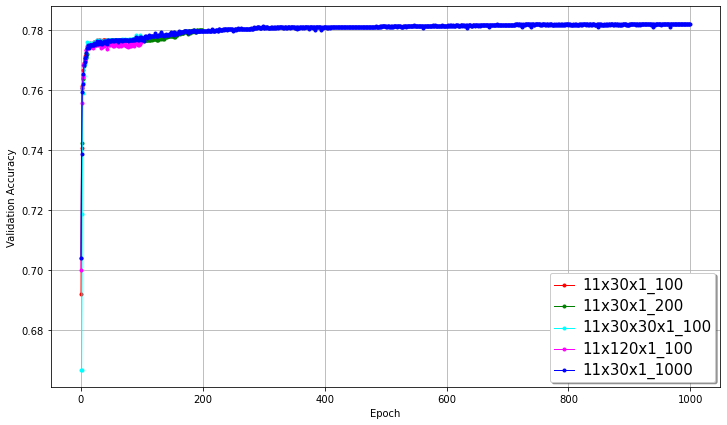

In [34]:
import numpy as np
y_vacc = []
x_len = []
y_vloss = []


plt.figure(figsize=(12,7))


colorlist = ["red",  "green", "cyan","magenta", "blue"]
marklist = ['.', '+', 'o', '*', 'x']
for idx in range(5):
    y_vacc.append(history[idx].history['val_acc'])
    x_len.append(np.arange(len(y_vacc[idx])))
    plt.plot(x_len[idx], y_vacc[idx], marker=marklist[0], lw=1.0, c=colorlist[idx], label=str(idx))    

plt.legend(('11x30x1_100', '11x30x1_200', '11x30x30x1_100', '11x120x1_100', '11x30x1_1000'),
           shadow=True, loc='lower right')
ltext = plt.gca().get_legend().get_texts()
ftsize = 15
plt.setp(ltext[0], fontsize=ftsize)
plt.setp(ltext[1], fontsize=ftsize)
plt.setp(ltext[2], fontsize=ftsize)
plt.setp(ltext[3], fontsize=ftsize)
plt.setp(ltext[4], fontsize=ftsize)

plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()
print("\n")

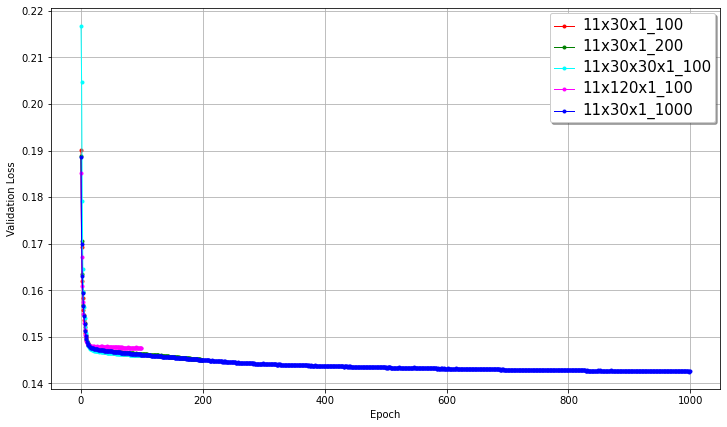

In [35]:
# loss graph
plt.figure(figsize=(12,7))
x_len = []

for idx in range(5):
    y_vloss.append(history[idx].history['val_loss'])
    x_len.append(np.arange(len(y_vloss[idx])))
    plt.plot(x_len[idx], y_vloss[idx], marker='.', lw=1.0, c=colorlist[idx], label=str(idx))

plt.legend(('11x30x1_100', '11x30x1_200', '11x30x30x1_100', '11x120x1_100', '11x30x1_1000'),
           shadow=True, loc='upper right')
ltext = plt.gca().get_legend().get_texts()
ftsize = 15
plt.setp(ltext[0], fontsize=ftsize)
plt.setp(ltext[1], fontsize=ftsize)
plt.setp(ltext[2], fontsize=ftsize)
plt.setp(ltext[3], fontsize=ftsize)
plt.setp(ltext[4], fontsize=ftsize)

plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()
print("\n")

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
model = load_model('mlp_2000.h5')
y_pred = (model.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))

[[1243548  229244]
 [  61066  122276]]
Classification Report
              precision    recall  f1-score   support

      class0       0.95      0.84      0.90   1472792
      class1       0.35      0.67      0.46    183342

    accuracy                           0.82   1656134
   macro avg       0.65      0.76      0.68   1656134
weighted avg       0.89      0.82      0.85   1656134



In [37]:
model = load_model('mlp_2000.h5')
eval_model = model.evaluate(x, y)
print("Accuracy: ", eval_model[1])

51755/51755 [==============================] - 15s 297us/step - loss: 0.1108 - acc: 0.8247
Accuracy:  0.8247061967849731


In [38]:
from sklearn.metrics import confusion_matrix, classification_report
model = load_model('mlp_relu_2000.h5')
y_pred = (model.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))

[[1240175  232617]
 [  56908  126434]]
Classification Report
              precision    recall  f1-score   support

      class0       0.96      0.84      0.90   1472792
      class1       0.35      0.69      0.47    183342

    accuracy                           0.83   1656134
   macro avg       0.65      0.77      0.68   1656134
weighted avg       0.89      0.83      0.85   1656134



In [16]:
# DT - depth 5

start = time.time() 

dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=seed)
dt.fit(X_train, Y_train)

pred_dt = dt.predict(x)

accuracy_dt = []
accuracy_dt.append(accuracy_score(y, pred_dt))
print('Accuracy: %.4f' % accuracy_dt[0])

print("time :", time.time() - start)

print("\nfeature importance: \n{}".format(dt.feature_importances_))

Accuracy: 0.8250
time : 2.069458246231079

feature importance: 
[0.00167748 0.16091822 0.01283369 0.71187456 0.02323315 0.00510259
 0.06661719 0.         0.01774312 0.         0.        ]


In [40]:
dot_data = export_graphviz(dt, out_file=None, filled=True, rounded=True, special_characters=True, class_names=["0","1"])
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('dt_depth5.png')


True

In [41]:
y_pred = (dt.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))
del dt, pred_dt

[[1248965  223827]
 [  65941  117401]]
Classification Report
              precision    recall  f1-score   support

      class0       0.95      0.85      0.90   1472792
      class1       0.34      0.64      0.45    183342

    accuracy                           0.83   1656134
   macro avg       0.65      0.74      0.67   1656134
weighted avg       0.88      0.83      0.85   1656134



In [17]:
# DT - depth 6

start = time.time() 

dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, random_state=seed)
dt.fit(X_train, Y_train)

pred_dt = dt.predict(x)

accuracy_dt.append(accuracy_score(y, pred_dt))
print('Accuracy: %.4f' % accuracy_dt[0])

print("time :", time.time() - start)

print("\nfeature importance: \n{}".format(dt.feature_importances_))

Accuracy: 0.8250
time : 2.3624141216278076

feature importance: 
[2.95477542e-03 1.65401552e-01 1.25983146e-02 6.93741064e-01
 2.47906126e-02 1.58164353e-02 6.49202589e-02 0.00000000e+00
 1.95769651e-02 0.00000000e+00 2.00021755e-04]


In [43]:
y_pred = (dt.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))
del dt, pred_dt

[[1223546  249246]
 [  55822  127520]]
Classification Report
              precision    recall  f1-score   support

      class0       0.96      0.83      0.89   1472792
      class1       0.34      0.70      0.46    183342

    accuracy                           0.82   1656134
   macro avg       0.65      0.76      0.67   1656134
weighted avg       0.89      0.82      0.84   1656134



In [18]:
# DT - depth 7

start = time.time() 

dt = DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, random_state=seed)
dt.fit(X_train, Y_train)

pred_dt = dt.predict(x)



accuracy_dt.append(accuracy_score(y, pred_dt))
print('Accuracy: %.4f' % accuracy_dt[1])
print("time :", time.time() - start) 
print("\nfeature importance: \n{}".format(dt.feature_importances_))

Accuracy: 0.8171
time : 2.6737287044525146

feature importance: 
[4.62181443e-03 1.64133170e-01 1.45774634e-02 6.84777091e-01
 2.45446055e-02 2.12405558e-02 6.48676675e-02 0.00000000e+00
 1.97788571e-02 1.97030989e-04 1.26174475e-03]


In [45]:
y_pred = (dt.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))
del dt, pred_dt

[[1218992  253800]
 [  52278  131064]]
Classification Report
              precision    recall  f1-score   support

      class0       0.96      0.83      0.89   1472792
      class1       0.34      0.71      0.46    183342

    accuracy                           0.82   1656134
   macro avg       0.65      0.77      0.67   1656134
weighted avg       0.89      0.82      0.84   1656134



In [19]:
# rf - 7
start = time.time() 
rf_clf = RandomForestClassifier(n_estimators=7, random_state=42)
rf_clf.fit(X_train, Y_train)

pred_rf = rf_clf.predict(x)
print('Accuracy: %.4f'  % accuracy_score(y, pred_rf))
print("time :", time.time() - start) 

Accuracy: 0.8131
time : 8.33188772201538


In [47]:
y_pred = (rf_clf.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))
del rf_clf, pred_rf

[[1221119  251673]
 [  56381  126961]]
Classification Report
              precision    recall  f1-score   support

      class0       0.96      0.83      0.89   1472792
      class1       0.34      0.69      0.45    183342

    accuracy                           0.81   1656134
   macro avg       0.65      0.76      0.67   1656134
weighted avg       0.89      0.81      0.84   1656134



In [20]:
# rf - 6
start = time.time()
rf_clf = RandomForestClassifier(n_estimators=6, random_state=42)
rf_clf.fit(X_train, Y_train)

pred_rf = rf_clf.predict(x)
print('Accuracy: %.4f'  % accuracy_score(y, pred_rf))
print("time :", time.time() - start) 

Accuracy: 0.8151
time : 7.866782903671265


In [49]:
y_pred = (rf_clf.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))
del rf_clf, pred_rf

[[1223430  249362]
 [  57260  126082]]
Classification Report
              precision    recall  f1-score   support

      class0       0.96      0.83      0.89   1472792
      class1       0.34      0.69      0.45    183342

    accuracy                           0.81   1656134
   macro avg       0.65      0.76      0.67   1656134
weighted avg       0.89      0.81      0.84   1656134



In [21]:
# rf - 5
start = time.time()
rf_clf = RandomForestClassifier(n_estimators=5, random_state=42)
rf_clf.fit(X_train, Y_train)

pred_rf = rf_clf.predict(x)
print('Accuracy: %.4f'  % accuracy_score(y, pred_rf))
print("time :", time.time() - start) 

Accuracy: 0.8143
time : 6.109383821487427


In [51]:
y_pred = (rf_clf.predict(x) > 0.5).astype("int32")
print(confusion_matrix(y, y_pred))
print('Classification Report')
target_names = ['class0', 'class1']
print(classification_report(y, y_pred, target_names=target_names))
del rf_clf, pred_rf

[[1223463  249329]
 [  57475  125867]]
Classification Report
              precision    recall  f1-score   support

      class0       0.96      0.83      0.89   1472792
      class1       0.34      0.69      0.45    183342

    accuracy                           0.81   1656134
   macro avg       0.65      0.76      0.67   1656134
weighted avg       0.89      0.81      0.84   1656134

